In [1]:
import numpy as np
import pandas as pd
import numpy as np

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

# Gera dados aleatórios ao invés de um grid regular
def GetRandomSamples(n_samples):
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)
    z = benchmark(x, y)
    return x, y, z

# Cria um DataFrame a partir dos pontos aleatórios
def create_random_dataframe(n_samples):
    x, y, z = GetRandomSamples(n_samples)
    data = {'x1': x, 'x2': y, 'f(x1,x2)': z}
    df = pd.DataFrame(data)
    return df

def GetGrid(grid):
    x = np.linspace(0, 1, grid)
    y = np.linspace(0, 1, grid)
    x, y = np.meshgrid(x, y)
    z = benchmark(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_training = create_random_dataframe(n_samples=30)   
df_test = create_random_dataframe(n_samples=20)       
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Exponential")

/tmp/ipykernel_11394/1555010058.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


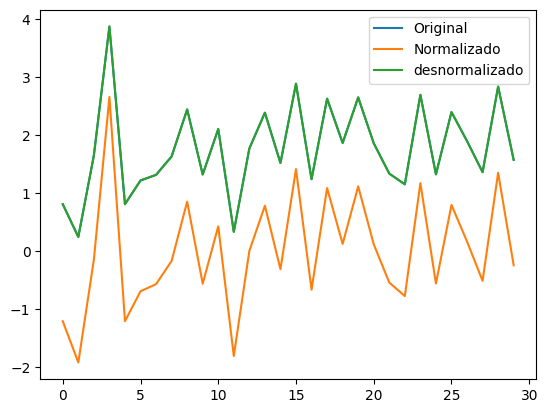

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 6.60 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-14 14:22:55.659349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:22:55.659986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:22:56.055356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:22:56.761714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 14:23:03.013517: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.276667,0.202318,-0.020613,0.277675,0.305630,0.473539,0.543077,0.290739,0.369854,0.552838,0.171567,0.556979,36.370760,85.760431
model_1_0_8,0.266967,0.190239,-0.039193,0.270080,0.309729,0.480709,0.552964,0.293796,0.370460,0.556533,0.160458,0.560702,36.344117,85.733789
model_1_0_7,0.256611,0.177646,-0.058525,0.261792,0.314104,0.488185,0.563250,0.297132,0.371155,0.560450,0.148597,0.564648,36.316059,85.705731
model_1_0_6,0.245627,0.164598,-0.078513,0.252797,0.318746,0.495931,0.573886,0.300753,0.372012,0.564576,0.136017,0.568805,36.286725,85.676396
model_1_0_5,0.233994,0.151258,-0.098795,0.242903,0.323661,0.503850,0.584679,0.304735,0.373127,0.568912,0.122694,0.573173,36.256119,85.645790
model_1_0_4,0.221871,0.137947,-0.118853,0.232062,0.328783,0.511752,0.595352,0.309098,0.374603,0.573396,0.108810,0.577691,36.224716,85.614387
model_1_0_3,0.209875,0.125205,-0.138198,0.220927,0.333851,0.519316,0.605645,0.313580,0.376365,0.577799,0.095071,0.582127,36.194118,85.583789
model_1_0_2,0.197226,0.112681,-0.156494,0.208405,0.339196,0.526751,0.615381,0.318620,0.378746,0.582406,0.080583,0.586768,36.162352,85.552024
model_1_0_1,0.163910,0.081357,-0.202863,0.175282,0.353273,0.545346,0.640054,0.331953,0.385472,0.594368,0.042427,0.598820,36.081027,85.470698
model_1_0_0,0.061035,-0.011701,-0.335757,0.050728,0.396741,0.600589,0.710768,0.382086,0.409583,0.629874,-0.075396,0.634592,35.848943,85.238614


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_1] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.388766,0.301158,0.104149,0.363597,0.258265,0.414863,0.476690,0.285462,0.339194,0.508198,0.299954,0.512005,36.707538,86.097210
model_1_1_8,0.378633,0.292075,0.092603,0.353359,0.262546,0.420255,0.482834,0.290054,0.342004,0.512393,0.288349,0.516231,36.674657,86.064328
model_1_1_7,0.368283,0.282824,0.080858,0.342911,0.266919,0.425746,0.489084,0.294740,0.344891,0.516642,0.276495,0.520512,36.641617,86.031288
model_1_1_6,0.357709,0.273397,0.068894,0.332244,0.271387,0.431343,0.495450,0.299525,0.347826,0.520948,0.264385,0.524851,36.608417,85.998088
model_1_1_5,0.346897,0.263794,0.056726,0.321349,0.275956,0.437043,0.501925,0.304412,0.350812,0.525315,0.252002,0.529250,36.575031,85.964702
model_1_1_4,0.335864,0.254010,0.044333,0.310237,0.280618,0.442852,0.508519,0.309396,0.353830,0.529733,0.239365,0.533702,36.541525,85.931196
model_1_1_3,0.324572,0.244047,0.031748,0.298883,0.285389,0.448766,0.515216,0.314490,0.356909,0.534218,0.226433,0.538220,36.507806,85.897477
model_1_1_2,0.313028,0.233898,0.018947,0.287288,0.290266,0.454791,0.522027,0.319690,0.360037,0.538764,0.213211,0.542800,36.473912,85.863584
model_1_1_1,0.301210,0.223558,0.005938,0.275439,0.295260,0.460929,0.528949,0.325005,0.363229,0.543378,0.199676,0.547449,36.439798,85.829469
model_1_1_0,0.289095,0.213032,-0.007255,0.263318,0.300379,0.467178,0.535969,0.330442,0.366499,0.548068,0.185801,0.552174,36.405421,85.795092


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_2] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.477286,0.383504,0.207797,0.470390,0.220862,0.365979,0.421538,0.237728,0.314550,0.469960,0.401337,0.473480,37.020433,86.410104
model_1_2_8,0.469028,0.375955,0.198449,0.461846,0.224352,0.370460,0.426513,0.241563,0.317068,0.473658,0.391878,0.477206,36.989079,86.378751
model_1_2_7,0.460622,0.368262,0.188907,0.453162,0.227903,0.375027,0.431590,0.245461,0.319592,0.477392,0.382251,0.480968,36.957666,86.347337
model_1_2_6,0.452081,0.360422,0.179159,0.444350,0.231512,0.379681,0.436777,0.249417,0.322111,0.481157,0.372469,0.484762,36.926244,86.315915
model_1_2_5,0.443379,0.352432,0.169210,0.435386,0.235189,0.384424,0.442071,0.253440,0.324644,0.484963,0.362502,0.488596,36.894729,86.284400
model_1_2_4,0.434544,0.344288,0.159035,0.426302,0.238922,0.389259,0.447485,0.257518,0.327163,0.488797,0.352384,0.492458,36.863236,86.252907
model_1_2_3,0.425567,0.335988,0.148631,0.417087,0.242715,0.394186,0.453021,0.261654,0.329677,0.492661,0.342103,0.496352,36.831734,86.221405
model_1_2_2,0.416487,0.327525,0.137960,0.407788,0.246552,0.399210,0.458699,0.265828,0.332148,0.496540,0.331703,0.500259,36.800367,86.190038
model_1_2_1,0.407305,0.318895,0.127001,0.398405,0.250432,0.404334,0.464530,0.270040,0.334574,0.500431,0.321186,0.504180,36.769138,86.158809
model_1_2_0,0.398033,0.310104,0.115753,0.388949,0.254349,0.409552,0.470516,0.274285,0.336947,0.504330,0.310568,0.508108,36.738095,86.127766


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.556621,0.456526,0.302844,0.574164,0.187341,0.322630,0.370963,0.159682,0.288274,0.432829,0.492199,0.436071,37.349651,86.739323
model_1_3_8,0.549451,0.449830,0.294137,0.566968,0.190370,0.326605,0.375596,0.162381,0.290706,0.436315,0.483987,0.439583,37.317567,86.707239
model_1_3_7,0.542100,0.443012,0.285283,0.559568,0.193476,0.330652,0.380307,0.165156,0.293196,0.439860,0.475568,0.443154,37.285200,86.674871
model_1_3_6,0.534597,0.436060,0.276247,0.552002,0.196647,0.334779,0.385116,0.167993,0.295710,0.443449,0.466974,0.446770,37.252693,86.642364
model_1_3_5,0.526929,0.428975,0.267033,0.544256,0.199887,0.338985,0.390018,0.170898,0.298294,0.447087,0.458192,0.450436,37.220008,86.609679
model_1_3_4,0.519103,0.421753,0.257635,0.536337,0.203194,0.343272,0.395019,0.173867,0.300908,0.450770,0.449229,0.454147,37.187191,86.576863
model_1_3_3,0.511113,0.414392,0.248049,0.528239,0.206570,0.347642,0.400120,0.176904,0.303555,0.454499,0.440078,0.457904,37.154236,86.543907
model_1_3_2,0.502921,0.406891,0.238285,0.519912,0.210031,0.352095,0.405315,0.180026,0.306261,0.458291,0.430696,0.461724,37.121001,86.510673
model_1_3_1,0.494568,0.399243,0.228317,0.511411,0.213560,0.356635,0.410619,0.183214,0.308983,0.462126,0.421129,0.465587,37.087674,86.477345
model_1_3_0,0.486014,0.391451,0.218167,0.502684,0.217174,0.361261,0.416020,0.186487,0.311756,0.466020,0.411333,0.469511,37.054109,86.443781


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.621632,0.516327,0.381603,0.606084,0.159872,0.287129,0.329054,0.145028,0.264963,0.399840,0.566655,0.402835,37.666763,87.056434
model_1_4_8,0.615805,0.510807,0.374290,0.599779,0.162334,0.290406,0.332946,0.147349,0.267076,0.402907,0.559982,0.405925,37.636199,87.025871
model_1_4_7,0.609823,0.505198,0.366879,0.593321,0.164862,0.293736,0.336889,0.149727,0.269253,0.406032,0.553130,0.409073,37.605297,86.994968
model_1_4_6,0.603686,0.499488,0.359339,0.586697,0.167454,0.297126,0.340901,0.152166,0.271486,0.409212,0.546102,0.412277,37.574087,86.963759
model_1_4_5,0.597398,0.493682,0.351692,0.579916,0.170111,0.300573,0.344970,0.154662,0.273770,0.412446,0.538900,0.415535,37.542603,86.932274
model_1_4_4,0.591004,0.487760,0.343878,0.572999,0.172813,0.304088,0.349128,0.157209,0.276050,0.415708,0.531578,0.418822,37.511091,86.900762
model_1_4_3,0.584448,0.481737,0.335946,0.565913,0.175583,0.307664,0.353349,0.159818,0.278387,0.419027,0.524068,0.422166,37.479282,86.868954
model_1_4_2,0.577731,0.475602,0.327876,0.558653,0.178422,0.311305,0.357643,0.162491,0.280774,0.422400,0.516375,0.425564,37.447213,86.836884
model_1_4_1,0.570850,0.469360,0.319678,0.551222,0.181329,0.315011,0.362005,0.165227,0.283210,0.425827,0.508495,0.429017,37.414888,86.804559
model_1_4_0,0.563821,0.463000,0.311328,0.543624,0.184299,0.318787,0.366449,0.168024,0.285699,0.429300,0.500444,0.432516,37.382393,86.772065


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_5] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.673703,0.562549,0.441279,0.654859,0.137870,0.259690,0.297300,0.122993,0.242858,0.371309,0.626293,0.374090,37.962885,87.352556
model_1_5_8,0.669042,0.558267,0.435731,0.650365,0.139840,0.262232,0.300252,0.124594,0.244837,0.373952,0.620954,0.376753,37.934514,87.324185
model_1_5_7,0.664326,0.553881,0.430018,0.645789,0.141832,0.264835,0.303292,0.126225,0.246776,0.376606,0.615553,0.379427,37.906221,87.295892
model_1_5_6,0.659303,0.549526,0.424456,0.641156,0.143955,0.267421,0.306252,0.127876,0.249033,0.379413,0.609801,0.382256,37.876515,87.266187
model_1_5_5,0.654302,0.545024,0.418631,0.636435,0.146068,0.270093,0.309351,0.129558,0.251161,0.382188,0.604072,0.385051,37.847367,87.237038
model_1_5_4,0.649054,0.540499,0.412844,0.631647,0.148285,0.272779,0.312431,0.131264,0.253511,0.385078,0.598062,0.387963,37.817237,87.206908
model_1_5_3,0.643763,0.535857,0.406865,0.626777,0.150521,0.275535,0.315612,0.133000,0.255794,0.387970,0.592002,0.390876,37.787309,87.176980
model_1_5_2,0.638378,0.531116,0.400749,0.621809,0.152796,0.278350,0.318867,0.134770,0.258076,0.390892,0.585835,0.393820,37.757301,87.146972
model_1_5_1,0.632921,0.526275,0.394485,0.616761,0.155102,0.281223,0.322200,0.136569,0.260333,0.393830,0.579585,0.396780,37.727345,87.117016
model_1_5_0,0.627310,0.521358,0.388140,0.611626,0.157473,0.284143,0.325576,0.138399,0.262665,0.396828,0.573158,0.399801,37.697005,87.086676


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_8,0.712382,0.587709,0.463638,0.708149,0.121527,0.244754,0.285403,0.130630,0.216428,0.348608,0.670591,0.351219,38.215231,87.604902
model_1_6_6,0.704426,0.584676,0.463021,0.706039,0.124889,0.246555,0.285731,0.131575,0.224222,0.353396,0.661479,0.356043,38.160661,87.550333
model_1_6_7,0.708606,0.584533,0.460114,0.705741,0.123123,0.246639,0.287278,0.131708,0.218601,0.350889,0.666266,0.353517,38.189145,87.578817
model_1_6_5,0.700386,0.581222,0.459137,0.703359,0.126596,0.248604,0.287798,0.132774,0.226375,0.355803,0.656852,0.358469,38.133507,87.523178
model_1_6_9,0.722066,0.580141,0.442100,0.695424,0.117435,0.249246,0.296863,0.136326,0.189208,0.342688,0.681683,0.345255,38.283734,87.673405
model_1_6_4,0.696177,0.578059,0.455889,0.700892,0.128374,0.250482,0.289526,0.133878,0.228955,0.358294,0.652032,0.360977,38.105610,87.495281
model_1_6_3,0.691709,0.575368,0.453663,0.698778,0.130262,0.252080,0.290711,0.134824,0.232166,0.360918,0.646915,0.363622,38.076413,87.466084
model_1_6_2,0.686894,0.573016,0.452225,0.696873,0.132297,0.253476,0.291476,0.135677,0.235918,0.363726,0.641399,0.366451,38.045413,87.435085
model_1_6_1,0.682396,0.569779,0.449056,0.694257,0.134197,0.255398,0.293162,0.136848,0.238558,0.366330,0.636248,0.369074,38.016888,87.406559
model_1_6_0,0.678035,0.566103,0.445039,0.691279,0.136040,0.257580,0.295300,0.138181,0.240694,0.368836,0.631253,0.371599,37.989611,87.379283


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_7] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.784703,0.651045,0.543989,0.817057,0.090969,0.207155,0.242648,0.089995,0.164582,0.301611,0.753421,0.303870,38.794466,88.184137
model_1_7_8,0.781933,0.647669,0.539084,0.814988,0.092140,0.209159,0.245257,0.091012,0.165329,0.303546,0.750248,0.305819,38.768894,88.158565
model_1_7_7,0.765749,0.628838,0.512072,0.801721,0.098978,0.220338,0.259631,0.097539,0.171264,0.314608,0.731713,0.316964,38.625714,88.015386
model_1_7_6,0.753728,0.616528,0.494566,0.790014,0.104057,0.227646,0.268946,0.103298,0.179165,0.322579,0.717945,0.324995,38.525630,87.915301
model_1_7_5,0.750309,0.612447,0.488656,0.787230,0.105502,0.230068,0.272091,0.104668,0.180073,0.324811,0.714029,0.327244,38.498052,87.887723
model_1_7_4,0.746846,0.608344,0.482727,0.784375,0.106965,0.232504,0.275245,0.106072,0.181010,0.327056,0.710063,0.329505,38.470501,87.860172
model_1_7_3,0.743297,0.604151,0.476659,0.781438,0.108465,0.234993,0.278474,0.107517,0.181956,0.329340,0.705998,0.331807,38.442659,87.832330
model_1_7_2,0.739626,0.599809,0.470340,0.778404,0.110016,0.237571,0.281837,0.109009,0.182910,0.331686,0.701794,0.334171,38.414261,87.803932
model_1_7_1,0.732662,0.591898,0.458931,0.772310,0.112958,0.242267,0.287908,0.112007,0.185298,0.336093,0.693818,0.338610,38.361475,87.751146
model_1_7_0,0.728784,0.587369,0.452355,0.769041,0.114597,0.244955,0.291407,0.113615,0.186311,0.338522,0.689376,0.341058,38.332668,87.722339


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.809635,0.681230,0.586326,0.815949,0.080435,0.189236,0.220119,0.074294,0.156219,0.283611,0.781975,0.285735,39.040611,88.430282
model_1_8_8,0.807357,0.678378,0.582340,0.814591,0.081397,0.190929,0.222241,0.074842,0.156926,0.285302,0.779366,0.287439,39.016823,88.406494
model_1_8_7,0.805026,0.675479,0.578267,0.813190,0.082382,0.192649,0.224408,0.075407,0.157664,0.287023,0.776697,0.289173,38.992768,88.382439
model_1_8_6,0.802869,0.672971,0.574648,0.811858,0.083294,0.194138,0.226334,0.075945,0.158768,0.288607,0.774226,0.290769,38.970759,88.360430
model_1_8_5,0.800501,0.670102,0.570593,0.810411,0.084294,0.195842,0.228491,0.076529,0.159639,0.290335,0.771514,0.292510,38.946880,88.336552
model_1_8_4,0.797993,0.667017,0.566335,0.808903,0.085354,0.197673,0.230757,0.077138,0.160356,0.292154,0.768642,0.294342,38.921900,88.311571
model_1_8_3,0.795446,0.663917,0.561975,0.807341,0.086430,0.199514,0.233077,0.077769,0.161171,0.293990,0.765724,0.296193,38.896833,88.286505
model_1_8_2,0.792962,0.660984,0.557822,0.805794,0.087480,0.201254,0.235287,0.078393,0.162165,0.295769,0.762880,0.297985,38.872700,88.262371
model_1_8_1,0.790253,0.657692,0.553268,0.804140,0.088625,0.203209,0.237710,0.079060,0.162910,0.297699,0.759776,0.299929,38.846692,88.236363
model_1_8_0,0.787551,0.654471,0.548741,0.802458,0.089766,0.205121,0.240119,0.079740,0.163802,0.299610,0.756683,0.301854,38.821099,88.210770


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.824989,0.698317,0.611298,0.804801,0.073947,0.179092,0.206832,0.095701,0.145988,0.271932,0.799560,0.273969,39.208806,88.598477
model_1_9_8,0.823331,0.696275,0.608442,0.803275,0.074648,0.180304,0.208351,0.096449,0.146592,0.273218,0.797661,0.275264,39.189943,88.579614
model_1_9_7,0.822099,0.695022,0.606458,0.801595,0.075169,0.181048,0.209407,0.097273,0.147731,0.274169,0.796250,0.276223,39.176040,88.565711
model_1_9_6,0.820454,0.693035,0.603533,0.799912,0.075864,0.182228,0.210964,0.098098,0.148496,0.275433,0.794366,0.277497,39.157639,88.547310
model_1_9_5,0.818941,0.691317,0.600979,0.798198,0.076503,0.183248,0.212323,0.098939,0.149448,0.276592,0.792633,0.278663,39.140853,88.530524
model_1_9_4,0.817219,0.689238,0.597968,0.796471,0.077231,0.184482,0.213925,0.099785,0.150238,0.277904,0.790661,0.279986,39.121920,88.511591
model_1_9_3,0.815455,0.687109,0.594914,0.794724,0.077976,0.185746,0.215550,0.100642,0.151038,0.279241,0.788641,0.281333,39.102715,88.492386
model_1_9_2,0.813676,0.684981,0.591885,0.792955,0.078728,0.187009,0.217161,0.101509,0.151860,0.280584,0.786603,0.282686,39.083522,88.473193
model_1_9_1,0.812431,0.683873,0.590199,0.791127,0.079254,0.187667,0.218059,0.102405,0.153345,0.281520,0.785177,0.283629,39.070206,88.459877
model_1_9_0,0.811184,0.682818,0.588612,0.789257,0.079781,0.188293,0.218903,0.103322,0.154939,0.282454,0.783749,0.284570,39.056951,88.446622


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.851000,0.732214,0.657914,0.898439,0.062957,0.158969,0.182027,0.032447,0.134546,0.250912,0.829350,0.252792,39.530605,88.920276
model_1_10_8,0.849666,0.730231,0.655116,0.898050,0.063521,0.160146,0.183516,0.032571,0.134864,0.252033,0.827823,0.253921,39.512782,88.902454
model_1_10_7,0.848280,0.728194,0.652228,0.897576,0.064106,0.161356,0.185053,0.032722,0.135216,0.253192,0.826235,0.255089,39.494422,88.884093
model_1_10_6,0.846939,0.726276,0.649558,0.897103,0.064673,0.162494,0.186473,0.032874,0.135591,0.254308,0.824700,0.256213,39.476831,88.866502
model_1_10_5,0.845575,0.724343,0.646871,0.896595,0.065249,0.163642,0.187903,0.033036,0.135977,0.255439,0.823138,0.257352,39.459088,88.848760
model_1_10_4,0.844165,0.722354,0.644117,0.896048,0.065845,0.164823,0.189368,0.033211,0.136361,0.256603,0.821522,0.258525,39.440904,88.830575
model_1_10_3,0.842831,0.720532,0.641610,0.895479,0.066409,0.165904,0.190703,0.033392,0.136808,0.257699,0.819994,0.259629,39.423851,88.813522
model_1_10_2,0.841289,0.718364,0.638588,0.894815,0.067060,0.167191,0.192311,0.033605,0.137197,0.258960,0.818229,0.260899,39.404332,88.794003
model_1_10_1,0.839774,0.716276,0.635701,0.894132,0.067700,0.168431,0.193847,0.033823,0.137615,0.260193,0.816493,0.262142,39.385327,88.774998
model_1_10_0,0.838238,0.714186,0.632818,0.893402,0.068349,0.169672,0.195381,0.034056,0.138063,0.261437,0.814734,0.263395,39.366249,88.755920


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_11] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.862182,0.748529,0.680032,0.822646,0.058232,0.149284,0.170258,0.077486,0.132263,0.241313,0.842158,0.243121,39.686638,89.076309
model_1_11_8,0.861324,0.747259,0.678508,0.821296,0.058595,0.150038,0.171069,0.078075,0.132385,0.242063,0.841175,0.243877,39.674223,89.063894
model_1_11_7,0.860280,0.745700,0.676270,0.819752,0.059036,0.150963,0.172260,0.078750,0.132633,0.242973,0.839979,0.244793,39.659221,89.048893
model_1_11_6,0.859221,0.744103,0.674116,0.818101,0.059483,0.151912,0.173406,0.079471,0.132815,0.243892,0.838766,0.245719,39.644120,89.033791
model_1_11_5,0.858137,0.742523,0.671881,0.816501,0.059941,0.152850,0.174595,0.080170,0.133095,0.244829,0.837525,0.246663,39.628780,89.018451
model_1_11_4,0.857031,0.740881,0.669703,0.814768,0.060409,0.153825,0.175754,0.080928,0.133279,0.245782,0.836258,0.247623,39.613242,89.002913
model_1_11_3,0.855887,0.739223,0.667411,0.813044,0.060892,0.154809,0.176973,0.081681,0.133545,0.246763,0.834948,0.248611,39.597308,88.986979
model_1_11_2,0.854720,0.737551,0.665082,0.811305,0.061385,0.155801,0.178213,0.082440,0.133835,0.247761,0.833611,0.249617,39.581169,88.970840
model_1_11_1,0.853510,0.735803,0.662725,0.809436,0.061896,0.156839,0.179467,0.083257,0.134060,0.248790,0.832225,0.250653,39.564589,88.954260
model_1_11_0,0.852269,0.734020,0.660338,0.807514,0.062421,0.157897,0.180737,0.084097,0.134283,0.249842,0.830804,0.251713,39.547714,88.937385


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.870844,0.762577,0.702067,0.868761,0.054572,0.140945,0.158533,0.048406,0.130459,0.233607,0.852078,0.235357,39.816458,89.206130
model_1_12_8,0.870055,0.761241,0.699871,0.867843,0.054906,0.141738,0.159701,0.048745,0.130629,0.234320,0.851174,0.236075,39.804270,89.193941
model_1_12_7,0.869263,0.759928,0.697788,0.866920,0.055240,0.142517,0.160810,0.049085,0.130811,0.235033,0.850267,0.236793,39.792126,89.181797
model_1_12_6,0.868436,0.758567,0.695568,0.865976,0.055590,0.143325,0.161991,0.049433,0.131010,0.235775,0.849320,0.237541,39.779515,89.169186
model_1_12_5,0.867592,0.757196,0.693343,0.865018,0.055946,0.144139,0.163175,0.049787,0.131212,0.236530,0.848353,0.238302,39.766725,89.156396
model_1_12_4,0.866778,0.755843,0.691349,0.864045,0.056290,0.144942,0.164236,0.050146,0.131311,0.237256,0.847421,0.239033,39.754461,89.144132
model_1_12_3,0.865896,0.754430,0.689093,0.863048,0.056663,0.145781,0.165436,0.050513,0.131508,0.238040,0.846411,0.239823,39.741268,89.130939
model_1_12_2,0.864995,0.752994,0.686838,0.862037,0.057044,0.146634,0.166636,0.050886,0.131716,0.238838,0.845379,0.240627,39.727880,89.117552
model_1_12_1,0.864077,0.751521,0.684576,0.860987,0.057431,0.147508,0.167840,0.051274,0.131895,0.239649,0.844328,0.241444,39.714326,89.103998
model_1_12_0,0.863155,0.750062,0.682395,0.859933,0.057821,0.148374,0.169001,0.051662,0.132067,0.240460,0.843271,0.242262,39.700800,89.090471


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.876687,0.776963,0.731192,0.882338,0.052103,0.132405,0.143035,0.045262,0.129846,0.228262,0.858770,0.229971,39.909051,89.298722
model_1_13_8,0.876383,0.775763,0.727541,0.881862,0.052232,0.133117,0.144978,0.045445,0.129956,0.228543,0.858421,0.230255,39.904121,89.293792
model_1_13_7,0.875962,0.774475,0.724170,0.881429,0.052410,0.133881,0.146771,0.045611,0.130085,0.228932,0.857939,0.230647,39.897318,89.286989
model_1_13_6,0.875434,0.773162,0.721097,0.881033,0.052633,0.134661,0.148407,0.045764,0.130311,0.229418,0.857335,0.231137,39.888831,89.278502
model_1_13_5,0.874879,0.771792,0.718218,0.880699,0.052867,0.135474,0.149939,0.045892,0.130437,0.229929,0.856699,0.231651,39.879938,89.269609
model_1_13_4,0.874332,0.770267,0.715302,0.880397,0.053099,0.136379,0.151490,0.046009,0.130336,0.230431,0.856073,0.232157,39.871213,89.260884
model_1_13_3,0.873655,0.768725,0.712231,0.879922,0.053385,0.137295,0.153124,0.046191,0.130461,0.231051,0.855297,0.232782,39.860463,89.250135
model_1_13_2,0.872993,0.767146,0.709456,0.879582,0.053664,0.138232,0.154601,0.046322,0.130432,0.231655,0.854539,0.233391,39.850017,89.239688
model_1_13_1,0.872300,0.765561,0.706794,0.879269,0.053957,0.139173,0.156018,0.046442,0.130409,0.232287,0.853745,0.234027,39.839125,89.228797
model_1_13_0,0.871606,0.764069,0.704458,0.879061,0.054250,0.140059,0.157261,0.046522,0.130385,0.232917,0.852951,0.234661,39.828298,89.217969


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.892209,0.809283,0.799705,0.878276,0.045545,0.113218,0.106579,0.035790,0.117530,0.213413,0.876547,0.215011,40.178111,89.567782
model_1_14_8,0.890201,0.805711,0.794660,0.876173,0.046393,0.115338,0.109263,0.036408,0.118715,0.215391,0.874247,0.217005,40.141199,89.530870
model_1_14_7,0.888213,0.801899,0.788356,0.874342,0.047233,0.117601,0.112618,0.036946,0.119977,0.217332,0.871971,0.218960,40.105313,89.494984
model_1_14_6,0.881744,0.789927,0.766109,0.870280,0.049967,0.124708,0.124456,0.038140,0.125396,0.223532,0.864562,0.225206,39.992804,89.382476
model_1_14_5,0.879353,0.785436,0.755960,0.869056,0.050977,0.127374,0.129856,0.038500,0.127450,0.225781,0.861823,0.227472,39.952756,89.342427
model_1_14_4,0.877530,0.781005,0.743040,0.869991,0.051747,0.130005,0.136731,0.038225,0.129667,0.227481,0.859735,0.229185,39.922760,89.312431
model_1_14_3,0.877670,0.780413,0.740375,0.871323,0.051688,0.130356,0.138149,0.037834,0.129565,0.227350,0.859896,0.229053,39.925062,89.314733
model_1_14_2,0.877611,0.779656,0.737752,0.872239,0.051713,0.130806,0.139544,0.037565,0.129536,0.227405,0.859828,0.229108,39.924091,89.313762
model_1_14_1,0.877419,0.778825,0.735473,0.872892,0.051794,0.131299,0.140757,0.037373,0.129559,0.227583,0.859609,0.229288,39.920962,89.310634
model_1_14_0,0.877084,0.777927,0.733255,0.873191,0.051936,0.131832,0.141937,0.037285,0.129704,0.227894,0.859225,0.229601,39.915504,89.305175


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.906949,0.829097,0.821983,0.809000,0.039317,0.101455,0.094724,0.047848,0.108310,0.198285,0.893428,0.199770,40.472199,89.861870
model_1_15_8,0.906003,0.827467,0.820674,0.809264,0.039716,0.102423,0.095421,0.047782,0.108745,0.199290,0.892346,0.200783,40.451978,89.841649
model_1_15_7,0.904896,0.825678,0.819244,0.809453,0.040184,0.103485,0.096182,0.047735,0.109258,0.200460,0.891078,0.201962,40.428561,89.818232
model_1_15_4,0.901921,0.824609,0.818793,0.820205,0.041441,0.104120,0.096422,0.045041,0.113000,0.203571,0.887670,0.205096,40.366955,89.756626
model_1_15_6,0.903615,0.823580,0.817409,0.809366,0.040725,0.104731,0.097158,0.047756,0.109816,0.201805,0.889611,0.203317,40.401807,89.791479
model_1_15_3,0.900330,0.822262,0.816346,0.820812,0.042113,0.105513,0.097724,0.044889,0.113879,0.205216,0.885848,0.206753,40.334776,89.724447
model_1_15_5,0.902140,0.821065,0.814950,0.808880,0.041349,0.106224,0.098467,0.047878,0.110419,0.203344,0.887921,0.204867,40.371421,89.761092
model_1_15_2,0.898524,0.819618,0.813369,0.821356,0.042877,0.107082,0.099308,0.044753,0.114770,0.207067,0.883779,0.208618,40.298846,89.688517
model_1_15_1,0.896531,0.816464,0.809340,0.821640,0.043719,0.108955,0.101452,0.044682,0.115583,0.209091,0.881497,0.210657,40.259952,89.649623
model_1_15_0,0.894281,0.812881,0.804324,0.821847,0.044669,0.111082,0.104121,0.044630,0.116498,0.211352,0.878920,0.212935,40.216930,89.606601


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_2,0.908868,0.828448,0.817737,0.952400,0.038506,0.101841,0.096984,0.017745,0.105622,0.196229,0.895627,0.197699,40.513883,89.903554
model_1_16_1,0.907248,0.827748,0.820143,0.956108,0.039191,0.102256,0.095704,0.016363,0.107015,0.197966,0.893771,0.199449,40.478637,89.868308
model_1_16_3,0.909649,0.827168,0.812475,0.947346,0.038176,0.102601,0.099784,0.019629,0.104577,0.195387,0.896521,0.196851,40.531092,89.920763
model_1_16_0,0.907009,0.826382,0.817627,0.956311,0.039291,0.103067,0.097042,0.016287,0.106643,0.198221,0.893497,0.199706,40.473494,89.863166
model_1_16_5,0.909711,0.826070,0.809036,0.940155,0.038150,0.103252,0.101614,0.022310,0.104308,0.195320,0.896592,0.196783,40.532468,89.922139
model_1_16_4,0.909282,0.824662,0.806631,0.940321,0.038331,0.104088,0.102893,0.022248,0.104383,0.195784,0.896100,0.197250,40.522980,89.912651
model_1_16_6,0.908411,0.822691,0.800790,0.929590,0.038699,0.105258,0.106001,0.026248,0.104640,0.196721,0.895103,0.198195,40.503876,89.893547
model_1_16_7,0.907876,0.820681,0.793764,0.921717,0.038925,0.106451,0.109740,0.029183,0.104708,0.197295,0.894490,0.198773,40.492222,89.881893
model_1_16_8,0.907201,0.819046,0.786854,0.912604,0.039210,0.107422,0.113417,0.032581,0.104962,0.198016,0.893718,0.199499,40.477634,89.867306
model_1_16_9,0.906871,0.818507,0.785296,0.910551,0.039350,0.107742,0.114246,0.033346,0.105095,0.198368,0.893340,0.199853,40.470535,89.860207


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.917177,0.834275,0.787541,0.942153,0.034995,0.098382,0.113051,0.028670,0.101642,0.187071,0.905142,0.188472,40.705076,90.094747
model_1_17_8,0.915567,0.830968,0.784557,0.941018,0.035676,0.100344,0.114639,0.029233,0.102301,0.188880,0.903298,0.190295,40.666573,90.056245
model_1_17_4,0.913602,0.830790,0.805241,0.942848,0.036506,0.100451,0.103633,0.028326,0.102310,0.191065,0.901049,0.192496,40.620572,90.010243
model_1_17_1,0.911162,0.829350,0.807655,0.942228,0.037537,0.101305,0.102349,0.028633,0.103640,0.193744,0.898254,0.195195,40.564866,89.954537
model_1_17_7,0.914276,0.828357,0.783670,0.940213,0.036221,0.101895,0.115111,0.029632,0.102613,0.190318,0.901820,0.191744,40.636231,90.025902
model_1_17_6,0.913866,0.827598,0.787578,0.940458,0.036394,0.102346,0.113032,0.029510,0.102171,0.190772,0.901351,0.192201,40.626700,90.016371
model_1_17_5,0.913126,0.827197,0.792502,0.940699,0.036707,0.102583,0.110412,0.029391,0.102143,0.191590,0.900504,0.193025,40.609593,89.999264
model_1_17_3,0.911924,0.826821,0.797366,0.940859,0.037215,0.102807,0.107823,0.029311,0.102777,0.192911,0.899127,0.194356,40.582101,89.971772
model_1_17_2,0.911678,0.826756,0.798501,0.940903,0.037319,0.102845,0.107219,0.029290,0.102958,0.193181,0.898845,0.194628,40.576514,89.966185
model_1_17_0,0.907705,0.820222,0.788598,0.937352,0.038997,0.106724,0.112489,0.031050,0.104749,0.197477,0.894295,0.198956,40.488529,89.878201


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.923198,0.858992,0.811974,0.867781,0.032451,0.083709,0.100050,0.042428,0.099739,0.180141,0.912039,0.181491,40.856051,90.245722
model_1_18_8,0.922358,0.856052,0.808978,0.869843,0.032806,0.085453,0.101645,0.041766,0.100204,0.181124,0.911077,0.182481,40.834294,90.223965
model_1_18_7,0.922477,0.855989,0.809239,0.870683,0.032756,0.085491,0.101506,0.041496,0.100100,0.180985,0.911213,0.182341,40.837356,90.227027
model_1_18_6,0.922837,0.854713,0.808457,0.875495,0.032604,0.086249,0.101921,0.039952,0.099734,0.180565,0.911625,0.181918,40.846650,90.236322
model_1_18_5,0.921726,0.851187,0.804742,0.877608,0.033073,0.088342,0.103898,0.039274,0.100330,0.181860,0.910353,0.183222,40.818072,90.207743
model_1_18_4,0.921809,0.851052,0.804799,0.878475,0.033038,0.088422,0.103868,0.038996,0.100225,0.181764,0.910447,0.183126,40.820181,90.209852
model_1_18_3,0.920783,0.847509,0.801017,0.881073,0.033472,0.090525,0.105880,0.038162,0.100680,0.182953,0.909273,0.184323,40.794115,90.183786
model_1_18_2,0.919913,0.844061,0.797324,0.884201,0.033839,0.092572,0.107846,0.037159,0.100933,0.183955,0.908276,0.185333,40.772265,90.161936
model_1_18_1,0.919282,0.840865,0.793951,0.888024,0.034106,0.094469,0.109641,0.035932,0.101044,0.184678,0.907554,0.186061,40.756575,90.146246
model_1_18_0,0.919204,0.838347,0.790887,0.893149,0.034139,0.095964,0.111271,0.034287,0.100698,0.184767,0.907464,0.186151,40.754640,90.144312


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_9,0.927471,0.868003,0.818084,0.908218,0.030646,0.078359,0.096799,0.028841,0.097269,0.175059,0.916933,0.176370,40.970532,90.360204
model_1_19_8,0.927339,0.867605,0.819680,0.908747,0.030702,0.078596,0.095950,0.028675,0.097417,0.175219,0.916781,0.176531,40.966883,90.356554
model_1_19_7,0.926513,0.866817,0.821375,0.908169,0.031051,0.079063,0.095048,0.028856,0.097964,0.176212,0.915835,0.177532,40.944280,90.333951
model_1_19_6,0.926028,0.865335,0.819007,0.907692,0.031255,0.079943,0.096308,0.029006,0.098242,0.176792,0.915280,0.178116,40.931135,90.320807
model_1_19_5,0.925344,0.863513,0.815700,0.906779,0.031544,0.081024,0.098068,0.029293,0.098679,0.177608,0.914496,0.178938,40.912712,90.302383
model_1_19_4,0.924408,0.861725,0.813681,0.905818,0.031940,0.082086,0.099142,0.029595,0.099244,0.178717,0.913425,0.180056,40.887800,90.277471
model_1_19_3,0.923969,0.860885,0.814660,0.906708,0.032125,0.082585,0.098621,0.029316,0.099396,0.179236,0.912922,0.180578,40.876212,90.265883
model_1_19_2,0.923268,0.859335,0.812490,0.906468,0.032421,0.083505,0.099776,0.029391,0.099771,0.180059,0.912119,0.181408,40.857874,90.247546
model_1_19_1,0.923117,0.859028,0.812076,0.906411,0.032486,0.083687,0.099996,0.029409,0.099844,0.180237,0.911946,0.181587,40.853922,90.243593
model_1_19_0,0.923133,0.858976,0.812125,0.906795,0.032479,0.083718,0.099970,0.029288,0.099806,0.180218,0.911964,0.181568,40.854343,90.244015


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_7,0.936371,0.885631,0.857391,0.898967,0.026885,0.067894,0.075884,0.024489,0.093978,0.163967,0.927126,0.165195,41.232358,90.622030
model_1_20_9,0.936484,0.885517,0.856282,0.897688,0.026837,0.067962,0.076473,0.024799,0.093851,0.163821,0.927256,0.165048,41.235926,90.625597
model_1_20_8,0.936397,0.885489,0.856426,0.898208,0.026874,0.067979,0.076397,0.024673,0.093828,0.163934,0.927155,0.165162,41.233165,90.622836
model_1_20_4,0.933999,0.879958,0.843053,0.893689,0.027887,0.071262,0.083513,0.025768,0.093524,0.166995,0.924410,0.168246,41.159173,90.548844
model_1_20_5,0.934325,0.879952,0.841947,0.892139,0.027749,0.071266,0.084102,0.026144,0.093304,0.166582,0.924783,0.167830,41.169078,90.558749
model_1_20_6,0.934601,0.879877,0.840757,0.891075,0.027633,0.071310,0.084734,0.026402,0.093086,0.166232,0.925098,0.167477,41.177481,90.567152
model_1_20_3,0.933595,0.879762,0.844425,0.896754,0.028058,0.071378,0.082783,0.025025,0.093973,0.167505,0.923947,0.168760,41.146966,90.536638
model_1_20_2,0.931481,0.875161,0.832446,0.891427,0.028951,0.074110,0.089157,0.026316,0.094410,0.170151,0.921525,0.171425,41.084278,90.473949
model_1_20_1,0.929076,0.870822,0.820337,0.885763,0.029967,0.076686,0.095600,0.027689,0.096039,0.173111,0.918771,0.174408,41.015285,90.404956
model_1_20_0,0.928707,0.870132,0.818055,0.886506,0.030123,0.077095,0.096814,0.027509,0.096528,0.173561,0.918348,0.174861,41.004907,90.394578


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.939419,0.890512,0.859362,0.945900,0.025597,0.064997,0.074835,0.026079,0.092170,0.159992,0.930616,0.161190,41.330529,90.720200
model_1_21_8,0.939344,0.890387,0.859180,0.945907,0.025629,0.065071,0.074931,0.026076,0.092193,0.160091,0.930531,0.161290,41.328059,90.717731
model_1_21_7,0.939310,0.889944,0.857789,0.945905,0.025644,0.065334,0.075672,0.026076,0.092104,0.160136,0.930491,0.161336,41.326927,90.716598
model_1_21_6,0.938439,0.887599,0.854414,0.946446,0.026011,0.066726,0.077468,0.025816,0.092449,0.161280,0.929495,0.162488,41.298451,90.688123
model_1_21_5,0.938265,0.887367,0.854194,0.946491,0.026085,0.066864,0.077585,0.025794,0.092517,0.161509,0.929294,0.162719,41.292782,90.682453
model_1_21_4,0.938153,0.887209,0.854086,0.946505,0.026132,0.066958,0.077642,0.025787,0.092573,0.161655,0.929166,0.162866,41.289167,90.678838
model_1_21_2,0.937982,0.886932,0.854013,0.946625,0.026204,0.067122,0.077681,0.025729,0.092672,0.161878,0.928971,0.163090,41.283660,90.673331
model_1_21_3,0.938036,0.886886,0.853349,0.946505,0.026182,0.067149,0.078034,0.025787,0.092564,0.161808,0.929033,0.163020,41.285389,90.675060
model_1_21_1,0.937629,0.885944,0.852090,0.946642,0.026354,0.067709,0.078704,0.025721,0.092707,0.162338,0.928566,0.163554,41.272288,90.661959
model_1_21_0,0.937524,0.885802,0.851902,0.946656,0.026398,0.067793,0.078804,0.025715,0.092739,0.162475,0.928446,0.163692,41.268921,90.658592


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.940516,0.892029,0.853820,0.926373,0.025134,0.064096,0.077784,0.012827,0.091091,0.158536,0.931873,0.159724,41.367085,90.756756
model_1_22_8,0.940331,0.891563,0.852521,0.926263,0.025212,0.064373,0.078475,0.012846,0.091093,0.158782,0.931661,0.159972,41.360882,90.750554
model_1_22_4,0.939945,0.891376,0.859576,0.928329,0.025375,0.064484,0.074721,0.012486,0.091898,0.159295,0.931219,0.160488,41.347984,90.737655
model_1_22_7,0.940209,0.891279,0.851423,0.926243,0.025264,0.064541,0.079059,0.012849,0.091006,0.158945,0.931521,0.160136,41.356788,90.746459
model_1_22_3,0.939925,0.891205,0.858980,0.928476,0.025383,0.064586,0.075038,0.012460,0.091855,0.159322,0.931196,0.160515,41.347315,90.736987
model_1_22_2,0.939836,0.891086,0.859232,0.928502,0.025421,0.064656,0.074904,0.012456,0.091932,0.159440,0.931094,0.160634,41.344355,90.734027
model_1_22_1,0.939762,0.890941,0.859007,0.928534,0.025452,0.064742,0.075024,0.012450,0.091930,0.159538,0.931010,0.160733,41.341895,90.731566
model_1_22_5,0.939936,0.890879,0.854177,0.927321,0.025379,0.064779,0.077594,0.012662,0.091353,0.159308,0.931208,0.160501,41.347667,90.737338
model_1_22_0,0.939704,0.890735,0.858463,0.928632,0.025477,0.064865,0.075313,0.012433,0.091904,0.159615,0.930943,0.160811,41.339960,90.729631
model_1_22_6,0.939954,0.890646,0.852052,0.927220,0.025371,0.064917,0.078724,0.012679,0.091147,0.159283,0.931230,0.160476,41.348289,90.737960


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.941779,0.897587,0.865738,0.944026,0.024600,0.060797,0.071442,0.024665,0.091286,0.156844,0.933320,0.158019,41.410021,90.799692
model_1_23_8,0.941768,0.897234,0.865136,0.944453,0.024605,0.061006,0.071762,0.024477,0.091286,0.156859,0.933307,0.158034,41.409627,90.799298
model_1_23_7,0.941607,0.896810,0.864482,0.944839,0.024673,0.061258,0.072110,0.024307,0.091307,0.157076,0.933122,0.158253,41.404100,90.793771
model_1_23_5,0.941449,0.896495,0.864923,0.945409,0.024740,0.061445,0.071876,0.024056,0.091516,0.157288,0.932941,0.158467,41.398699,90.788370
model_1_23_6,0.941432,0.896402,0.864370,0.945285,0.024747,0.061500,0.072170,0.024110,0.091443,0.157312,0.932922,0.158490,41.398108,90.787780
model_1_23_2,0.941131,0.896312,0.865771,0.946658,0.024874,0.061554,0.071424,0.023506,0.091671,0.157715,0.932577,0.158896,41.387870,90.777542
model_1_23_1,0.940999,0.896053,0.864880,0.947187,0.024930,0.061707,0.071899,0.023273,0.091565,0.157892,0.932426,0.159075,41.383375,90.773046
model_1_23_3,0.941195,0.895847,0.862180,0.945901,0.024847,0.061830,0.073335,0.023839,0.091278,0.157629,0.932650,0.158810,41.390039,90.779711
model_1_23_4,0.941212,0.895780,0.862995,0.945777,0.024840,0.061870,0.072902,0.023894,0.091440,0.157607,0.932670,0.158787,41.390614,90.780285
model_1_23_0,0.940694,0.895485,0.863958,0.947611,0.025059,0.062045,0.072389,0.023086,0.091642,0.158299,0.932077,0.159485,41.373072,90.762743


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.942588,0.902853,0.868262,0.918632,0.024258,0.057671,0.070099,0.034035,0.090498,0.155750,0.934246,0.156917,41.438003,90.827674
model_1_24_8,0.942516,0.901928,0.867582,0.920440,0.024289,0.058219,0.070461,0.033279,0.090497,0.155849,0.934163,0.157016,41.435479,90.825150
model_1_24_7,0.942583,0.901373,0.868194,0.923132,0.024261,0.058549,0.070135,0.032153,0.090626,0.155758,0.934240,0.156925,41.437802,90.827474
model_1_24_6,0.942557,0.901229,0.868065,0.923348,0.024271,0.058635,0.070204,0.032062,0.090640,0.155793,0.934210,0.156960,41.436907,90.826579
model_1_24_5,0.942517,0.900964,0.867503,0.923279,0.024288,0.058792,0.070503,0.032091,0.090609,0.155846,0.934165,0.157014,41.435536,90.825207
model_1_24_4,0.942358,0.900135,0.867277,0.925171,0.024356,0.059284,0.070623,0.031300,0.090809,0.156063,0.933982,0.157232,41.429991,90.819662
model_1_24_3,0.942006,0.898534,0.864088,0.924075,0.024504,0.060235,0.072320,0.031758,0.090704,0.156539,0.933579,0.157711,41.417807,90.807478
model_1_24_2,0.941776,0.897675,0.864198,0.926333,0.024601,0.060744,0.072262,0.030814,0.090987,0.156848,0.933317,0.158023,41.409917,90.799588
model_1_24_1,0.941748,0.897585,0.864409,0.926949,0.024613,0.060798,0.072149,0.030556,0.091055,0.156886,0.933284,0.158061,41.408951,90.798622
model_1_24_0,0.941684,0.897384,0.864127,0.926958,0.024640,0.060917,0.072299,0.030552,0.091069,0.156972,0.933211,0.158148,41.406759,90.796430


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  103
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  135
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  62
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.942921,0.896781,0.864780,0.932534,0.024117,0.061275,0.071952,0.036365,0.090268,0.155298,0.934628,0.156461,41.449643,90.839314
model_1_25_1,0.940420,0.891225,0.862792,0.917970,0.025174,0.064573,0.073010,0.044216,0.090993,0.158664,0.931764,0.159852,41.363874,90.753545
model_1_25_2,0.939596,0.889631,0.861424,0.913954,0.025522,0.065520,0.073738,0.046380,0.091112,0.159758,0.930819,0.160954,41.336391,90.726063
model_1_25_3,0.939400,0.889274,0.861221,0.913059,0.025606,0.065732,0.073845,0.046863,0.091161,0.160017,0.930594,0.161216,41.329894,90.719566
model_1_25_4,0.939396,0.889253,0.861151,0.913027,0.025607,0.065744,0.073883,0.046880,0.091159,0.160022,0.930591,0.161220,41.329786,90.719457
model_1_25_5,0.939126,0.888739,0.860885,0.911741,0.025721,0.066049,0.074024,0.047573,0.091238,0.160378,0.930281,0.161579,41.320897,90.710568
model_1_25_6,0.939059,0.888563,0.860602,0.911397,0.025750,0.066154,0.074175,0.047758,0.091244,0.160467,0.930204,0.161669,41.318674,90.708346
model_1_25_7,0.939043,0.888525,0.860562,0.911325,0.025756,0.066176,0.074196,0.047798,0.091246,0.160487,0.930186,0.161689,41.318164,90.707835
model_1_25_8,0.938925,0.888213,0.860042,0.910744,0.025806,0.066361,0.074473,0.048111,0.091259,0.160642,0.930051,0.161846,41.314298,90.703969
model_1_25_9,0.938902,0.888138,0.859895,0.910619,0.025816,0.066406,0.074551,0.048178,0.091257,0.160673,0.930024,0.161877,41.313534,90.703205


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.940156,0.891066,0.862399,0.927032,0.025286,0.064668,0.073219,0.029607,0.091191,0.159015,0.931461,0.160207,41.355015,90.744686
model_1_26_8,0.940111,0.890931,0.862255,0.927023,0.025305,0.064748,0.073295,0.029611,0.091188,0.159075,0.931409,0.160267,41.353517,90.743188
model_1_26_7,0.940086,0.890789,0.861975,0.927123,0.025315,0.064832,0.073444,0.029570,0.091167,0.159108,0.931381,0.160300,41.352678,90.742349
model_1_26_6,0.940053,0.890645,0.861717,0.927207,0.025329,0.064918,0.073582,0.029536,0.091148,0.159152,0.931343,0.160344,41.351576,90.741247
model_1_26_5,0.939996,0.890505,0.861611,0.927152,0.025353,0.065001,0.073638,0.029559,0.091153,0.159227,0.931278,0.160420,41.349693,90.739365
model_1_26_4,0.939943,0.890363,0.861480,0.927119,0.025376,0.065085,0.073708,0.029572,0.091154,0.159298,0.931217,0.160491,41.347917,90.737588
model_1_26_3,0.939733,0.889829,0.861120,0.926897,0.025465,0.065402,0.073899,0.029662,0.091169,0.159576,0.930976,0.160772,41.340929,90.730600
model_1_26_2,0.939337,0.888910,0.859725,0.927081,0.025632,0.065948,0.074641,0.029587,0.091135,0.160100,0.930522,0.161299,41.327825,90.717496
model_1_26_1,0.939268,0.888747,0.859585,0.927012,0.025661,0.066045,0.074716,0.029616,0.091142,0.160190,0.930444,0.161390,41.325568,90.715239
model_1_26_0,0.939145,0.888474,0.859463,0.926861,0.025713,0.066206,0.074781,0.029677,0.091169,0.160354,0.930302,0.161555,41.321496,90.711167


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_9,0.940435,0.901303,0.875029,0.934757,0.025168,0.058591,0.066498,0.025575,0.090966,0.158645,0.931780,0.159833,41.364347,90.754018
model_1_27_8,0.940418,0.901132,0.874872,0.934927,0.025175,0.058692,0.066582,0.025508,0.090973,0.158667,0.931760,0.159856,41.363784,90.753455
model_1_27_7,0.940261,0.900300,0.875171,0.935595,0.025242,0.059186,0.066422,0.025246,0.091131,0.158876,0.931581,0.160066,41.358517,90.748188
model_1_27_6,0.940227,0.898982,0.873511,0.936881,0.025256,0.059969,0.067306,0.024742,0.091109,0.158922,0.931542,0.160112,41.357378,90.747049
model_1_27_5,0.940158,0.897593,0.871784,0.938110,0.025285,0.060794,0.068225,0.024260,0.091136,0.159012,0.931463,0.160204,41.355091,90.744762
model_1_27_4,0.940279,0.896084,0.869188,0.939577,0.025234,0.061689,0.069606,0.023685,0.091075,0.158852,0.931602,0.160042,41.359131,90.748802
model_1_27_3,0.940225,0.895935,0.869351,0.939662,0.025257,0.061778,0.069520,0.023652,0.091149,0.158924,0.931540,0.160114,41.357328,90.746999
model_1_27_2,0.940205,0.895686,0.869024,0.939877,0.025265,0.061925,0.069693,0.023568,0.091161,0.158950,0.931517,0.160140,41.356670,90.746341
model_1_27_1,0.940272,0.894011,0.866908,0.941434,0.025237,0.062920,0.070820,0.022957,0.091244,0.158861,0.931594,0.160051,41.358902,90.748573
model_1_27_0,0.940300,0.891984,0.863828,0.943224,0.025225,0.064123,0.072458,0.022256,0.091266,0.158824,0.931625,0.160014,41.359828,90.749499


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 10ms/step
+++++++++++ [1_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.942910,0.902454,0.867790,0.950348,0.024122,0.057907,0.070350,0.023295,0.090147,0.155314,0.934614,0.156477,41.449226,90.838898
model_1_28_6,0.942355,0.902433,0.871022,0.952349,0.024357,0.057920,0.068630,0.022356,0.090227,0.156067,0.933979,0.157236,41.429880,90.819551
model_1_28_8,0.942757,0.902413,0.868679,0.950941,0.024187,0.057932,0.069877,0.023017,0.090114,0.155521,0.934440,0.156686,41.443904,90.833575
model_1_28_7,0.942737,0.902405,0.868784,0.951025,0.024195,0.057937,0.069821,0.022978,0.090109,0.155549,0.934417,0.156714,41.443189,90.832860
model_1_28_5,0.941773,0.902186,0.873083,0.954112,0.024603,0.058067,0.067534,0.021529,0.090392,0.156852,0.933313,0.158027,41.409810,90.799481
model_1_28_4,0.941713,0.902173,0.873308,0.954205,0.024628,0.058074,0.067414,0.021486,0.090426,0.156933,0.933244,0.158109,41.407738,90.797409
model_1_28_3,0.941599,0.902097,0.873529,0.954396,0.024676,0.058119,0.067296,0.021396,0.090470,0.157087,0.933113,0.158264,41.403823,90.793494
model_1_28_2,0.941554,0.902064,0.873611,0.954488,0.024695,0.058139,0.067253,0.021353,0.090491,0.157148,0.933061,0.158325,41.402276,90.791948
model_1_28_1,0.941495,0.902027,0.873730,0.954592,0.024720,0.058161,0.067189,0.021304,0.090516,0.157227,0.932994,0.158405,41.400264,90.789935
model_1_28_0,0.940936,0.901650,0.874376,0.955534,0.024956,0.058385,0.066846,0.020862,0.090751,0.157976,0.932354,0.159160,41.381244,90.770915


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.942690,0.905445,0.862557,0.896394,0.024215,0.056132,0.073135,0.023585,0.090197,0.155612,0.934363,0.156778,41.441560,90.831231
model_1_29_8,0.942726,0.905295,0.863115,0.897386,0.024200,0.056221,0.072838,0.023360,0.090182,0.155563,0.934404,0.156729,41.442812,90.832483
model_1_29_7,0.942789,0.905031,0.863380,0.898800,0.024174,0.056378,0.072696,0.023038,0.090148,0.155478,0.934476,0.156643,41.444992,90.834664
model_1_29_6,0.942870,0.904627,0.863745,0.901021,0.024139,0.056617,0.072503,0.022532,0.090110,0.155368,0.934569,0.156532,41.447824,90.837495
model_1_29_5,0.942872,0.904578,0.863783,0.901206,0.024138,0.056646,0.072482,0.022490,0.090106,0.155365,0.934571,0.156529,41.447908,90.837580
model_1_29_4,0.942881,0.904215,0.864200,0.902807,0.024135,0.056862,0.072260,0.022126,0.090066,0.155353,0.934582,0.156517,41.448223,90.837895
model_1_29_3,0.942882,0.904074,0.864116,0.903223,0.024134,0.056946,0.072305,0.022031,0.090053,0.155351,0.934583,0.156515,41.448268,90.837939
model_1_29_2,0.942915,0.903785,0.864805,0.905112,0.024120,0.057118,0.071938,0.021601,0.090040,0.155307,0.934620,0.156470,41.449413,90.839084
model_1_29_1,0.942998,0.903065,0.865870,0.908847,0.024085,0.057545,0.071372,0.020751,0.090025,0.155194,0.934715,0.156357,41.452314,90.841985
model_1_29_0,0.942982,0.902621,0.865727,0.910174,0.024092,0.057809,0.071448,0.020448,0.090020,0.155216,0.934697,0.156378,41.451761,90.841432


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_9,0.942374,0.906158,0.866947,0.929941,0.024349,0.055708,0.070799,0.028024,0.090145,0.156040,0.934002,0.157209,41.430569,90.820240
model_1_30_8,0.942375,0.906154,0.866920,0.929973,0.024348,0.055711,0.070813,0.028012,0.090150,0.156039,0.934002,0.157208,41.430586,90.820258
model_1_30_7,0.942374,0.906153,0.866905,0.929998,0.024349,0.055711,0.070821,0.028001,0.090162,0.156040,0.934001,0.157209,41.430566,90.820237
model_1_30_6,0.942541,0.906093,0.866151,0.931209,0.024278,0.055747,0.071222,0.027517,0.089981,0.155814,0.934192,0.156982,41.436359,90.826030
model_1_30_5,0.942477,0.906068,0.866199,0.931304,0.024305,0.055762,0.071197,0.027479,0.090241,0.155901,0.934119,0.157069,41.434139,90.823810
model_1_30_4,0.942798,0.905740,0.863590,0.935099,0.024169,0.055957,0.072585,0.025961,0.090048,0.155465,0.934487,0.156630,41.445336,90.835008
model_1_30_3,0.942795,0.905732,0.863553,0.935146,0.024171,0.055961,0.072605,0.025942,0.090056,0.155470,0.934483,0.156635,41.445206,90.834877
model_1_30_2,0.942790,0.905716,0.863493,0.935214,0.024173,0.055971,0.072637,0.025915,0.090065,0.155477,0.934477,0.156641,41.445039,90.834710
model_1_30_1,0.942752,0.905605,0.863103,0.935639,0.024189,0.056037,0.072844,0.025745,0.090125,0.155529,0.934433,0.156694,41.443700,90.833371
model_1_30_0,0.942738,0.905567,0.862966,0.935792,0.024195,0.056059,0.072917,0.025684,0.090143,0.155548,0.934418,0.156713,41.443215,90.832886


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.942551,0.904669,0.861453,0.945680,0.024274,0.056592,0.073722,0.020353,0.090318,0.155801,0.934204,0.156968,41.436704,90.826376
model_1_31_1,0.942567,0.904656,0.861531,0.945567,0.024267,0.056600,0.073681,0.020395,0.090310,0.155779,0.934222,0.156946,41.437256,90.826927
model_1_31_2,0.942583,0.904643,0.861600,0.945459,0.024260,0.056608,0.073644,0.020436,0.090303,0.155758,0.934240,0.156925,41.437813,90.827484
model_1_31_3,0.942579,0.904569,0.861451,0.945337,0.024262,0.056652,0.073723,0.020481,0.090320,0.155764,0.934235,0.156930,41.437664,90.827336
model_1_31_5,0.942603,0.904567,0.861722,0.945090,0.024252,0.056653,0.073579,0.020574,0.090295,0.155730,0.934263,0.156897,41.438521,90.828192
model_1_31_6,0.942615,0.904554,0.861794,0.944982,0.024247,0.056661,0.073541,0.020614,0.090289,0.155714,0.934277,0.156881,41.438928,90.828599
model_1_31_9,0.942621,0.904548,0.862438,0.944422,0.024244,0.056664,0.073198,0.020824,0.090236,0.155706,0.934284,0.156872,41.439139,90.828810
model_1_31_4,0.942596,0.904548,0.861473,0.945247,0.024255,0.056664,0.073712,0.020515,0.090317,0.155740,0.934255,0.156906,41.438277,90.827948
model_1_31_7,0.942628,0.904531,0.861814,0.944886,0.024241,0.056675,0.073530,0.020650,0.090285,0.155696,0.934292,0.156862,41.439396,90.829067
model_1_31_8,0.942631,0.904525,0.862129,0.944603,0.024240,0.056678,0.073362,0.020756,0.090262,0.155693,0.934295,0.156859,41.439483,90.829155


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.942802,0.902081,0.861790,0.951127,0.024168,0.058129,0.073543,0.027463,0.090026,0.155460,0.934491,0.156624,41.445468,90.835139
model_1_32_1,0.942653,0.901966,0.862533,0.950530,0.024231,0.058197,0.073148,0.027798,0.090099,0.155662,0.934321,0.156828,41.440270,90.829941
model_1_32_2,0.942600,0.901845,0.862829,0.950225,0.024253,0.058269,0.072990,0.027970,0.090157,0.155735,0.934259,0.156902,41.438398,90.828069
model_1_32_3,0.942189,0.899852,0.862971,0.947402,0.024427,0.059452,0.072914,0.029556,0.090903,0.156291,0.933789,0.157462,41.424142,90.813813
model_1_32_4,0.942200,0.898071,0.861607,0.945944,0.024422,0.060509,0.073640,0.030375,0.090819,0.156276,0.933802,0.157447,41.424528,90.814199
model_1_32_5,0.942241,0.896390,0.859429,0.944926,0.024405,0.061507,0.074799,0.030947,0.090589,0.156220,0.933849,0.157390,41.425955,90.815626
model_1_32_6,0.942059,0.895728,0.859526,0.943974,0.024482,0.061901,0.074747,0.031482,0.090889,0.156467,0.933640,0.157639,41.419633,90.809304
model_1_32_7,0.941792,0.894479,0.859375,0.942497,0.024595,0.062642,0.074828,0.032312,0.091200,0.156827,0.933334,0.158002,41.410441,90.800112
model_1_32_8,0.941787,0.894378,0.859336,0.942413,0.024597,0.062702,0.074849,0.032359,0.091197,0.156833,0.933329,0.158008,41.410290,90.799961
model_1_32_9,0.941876,0.892546,0.856908,0.941497,0.024559,0.063790,0.076141,0.032874,0.090886,0.156713,0.933431,0.157887,41.413356,90.803027


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_33] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.943067,0.895999,0.857608,0.914926,0.024056,0.061739,0.075768,0.025183,0.089714,0.155099,0.934795,0.156261,41.454766,90.844437
model_1_33_8,0.942973,0.895146,0.856479,0.915706,0.024096,0.062246,0.076369,0.024952,0.089764,0.155228,0.934687,0.156390,41.451450,90.841121
model_1_33_7,0.942940,0.894952,0.856425,0.916058,0.024109,0.062361,0.076397,0.024848,0.089783,0.155272,0.934650,0.156435,41.450302,90.839973
model_1_33_6,0.942805,0.894654,0.856683,0.916508,0.024167,0.062538,0.076260,0.024715,0.089911,0.155456,0.934495,0.156620,41.445573,90.835244
model_1_33_5,0.942767,0.894495,0.856539,0.916637,0.024183,0.062633,0.076337,0.024677,0.089930,0.155507,0.934451,0.156672,41.444245,90.833917
model_1_33_3,0.942690,0.894356,0.856781,0.916936,0.024215,0.062715,0.076208,0.024588,0.090014,0.155612,0.934363,0.156778,41.441560,90.831232
model_1_33_4,0.942738,0.894348,0.856372,0.916756,0.024195,0.062720,0.076426,0.024641,0.089944,0.155547,0.934418,0.156712,41.443239,90.832910
model_1_33_2,0.942665,0.894287,0.856762,0.916991,0.024226,0.062756,0.076218,0.024572,0.090031,0.155646,0.934334,0.156812,41.440674,90.830345
model_1_33_1,0.942633,0.894089,0.856418,0.917183,0.024239,0.062873,0.076401,0.024515,0.090024,0.155689,0.934298,0.156855,41.439578,90.829249
model_1_33_0,0.942453,0.893894,0.857178,0.917893,0.024315,0.062989,0.075997,0.024305,0.090233,0.155933,0.934092,0.157101,41.433313,90.822984


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_1,0.943077,0.894444,0.854024,0.947043,0.024052,0.062662,0.077675,0.017535,0.090207,0.155086,0.934806,0.156248,41.455092,90.844763
model_1_34_0,0.943000,0.894331,0.853536,0.947039,0.024084,0.062730,0.077935,0.017536,0.090233,0.155191,0.934718,0.156353,41.452403,90.842074
model_1_34_7,0.943153,0.894276,0.856681,0.941655,0.024020,0.062763,0.076262,0.019319,0.090420,0.154983,0.934893,0.156144,41.457764,90.847436
model_1_34_4,0.943242,0.894221,0.855429,0.945922,0.023982,0.062795,0.076928,0.017906,0.090142,0.154861,0.934995,0.156021,41.460909,90.850580
model_1_34_2,0.943215,0.894208,0.855291,0.946268,0.023994,0.062803,0.077001,0.017792,0.090140,0.154899,0.934964,0.156059,41.459939,90.849611
model_1_34_3,0.943225,0.894203,0.855296,0.945995,0.023989,0.062805,0.076998,0.017882,0.090145,0.154885,0.934975,0.156045,41.460290,90.849962
model_1_34_8,0.942818,0.894011,0.857418,0.936754,0.024161,0.062919,0.075869,0.020942,0.090797,0.155439,0.934509,0.156603,41.446008,90.835679
model_1_34_5,0.943159,0.893965,0.854738,0.944942,0.024017,0.062947,0.077295,0.018231,0.090228,0.154975,0.934900,0.156136,41.457968,90.847640
model_1_34_6,0.943045,0.893691,0.854363,0.942245,0.024065,0.063110,0.077495,0.019124,0.090389,0.155130,0.934769,0.156292,41.453971,90.843643
model_1_34_9,0.942642,0.893211,0.857414,0.934207,0.024236,0.063395,0.075871,0.021785,0.090873,0.155678,0.934308,0.156844,41.439864,90.829535


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  46
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_3,0.942056,0.895388,0.866664,0.917950,0.024483,0.062102,0.070949,0.037448,0.091129,0.156471,0.933637,0.157643,41.419543,90.809214
model_1_35_5,0.940566,0.895266,0.863208,0.902857,0.025113,0.062175,0.072788,0.044337,0.090189,0.158469,0.931931,0.159656,41.368777,90.758449
model_1_35_4,0.940871,0.895244,0.863947,0.905268,0.024984,0.062188,0.072395,0.043236,0.090243,0.158062,0.932280,0.159246,41.379067,90.768738
model_1_35_7,0.939916,0.895047,0.861554,0.898405,0.025387,0.062305,0.073669,0.046369,0.090222,0.159334,0.931186,0.160528,41.347007,90.736679
model_1_35_1,0.942060,0.894968,0.867980,0.922600,0.024481,0.062351,0.070249,0.035326,0.091711,0.156465,0.933642,0.157637,41.419699,90.809370
model_1_35_6,0.940542,0.894851,0.860331,0.901519,0.025123,0.062421,0.074319,0.044948,0.089844,0.158502,0.931902,0.159690,41.367945,90.757616
model_1_35_0,0.942082,0.894784,0.867625,0.923011,0.024472,0.062461,0.070438,0.035139,0.091699,0.156435,0.933667,0.157607,41.420455,90.810126
model_1_35_2,0.942377,0.894723,0.863625,0.922281,0.024348,0.062497,0.072566,0.035471,0.090953,0.156037,0.934004,0.157206,41.430644,90.820315
model_1_35_8,0.938362,0.893437,0.853190,0.887219,0.026044,0.063260,0.078119,0.051474,0.089540,0.161381,0.929406,0.162590,41.295938,90.685609
model_1_35_9,0.938272,0.893268,0.852288,0.886524,0.026082,0.063360,0.078599,0.051791,0.089507,0.161499,0.929303,0.162708,41.293036,90.682708


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.938335,0.893245,0.852257,0.901605,0.026055,0.063374,0.078615,0.045217,0.089451,0.161417,0.929375,0.162626,41.295060,90.684731
model_1_36_1,0.938363,0.893214,0.852321,0.901266,0.026043,0.063393,0.078581,0.045372,0.089388,0.161380,0.929407,0.162589,41.295982,90.685653
model_1_36_5,0.937989,0.893108,0.854838,0.897967,0.026202,0.063456,0.077242,0.046889,0.089661,0.161869,0.928979,0.163082,41.283870,90.673542
model_1_36_4,0.937936,0.893091,0.854919,0.898072,0.026224,0.063466,0.077199,0.046840,0.089716,0.161939,0.928918,0.163152,41.282152,90.671823
model_1_36_3,0.938011,0.893077,0.854635,0.898418,0.026192,0.063474,0.077350,0.046681,0.089632,0.161840,0.929004,0.163053,41.284577,90.674248
model_1_36_2,0.938411,0.893020,0.851967,0.901198,0.026023,0.063508,0.078770,0.045404,0.089372,0.161317,0.929462,0.162525,41.297536,90.687207
model_1_36_6,0.938356,0.891910,0.851373,0.896660,0.026046,0.064167,0.079086,0.047489,0.089039,0.161389,0.929400,0.162597,41.295762,90.685433
model_1_36_9,0.938080,0.888640,0.846617,0.892361,0.026163,0.066108,0.081616,0.049465,0.089212,0.161750,0.929083,0.162961,41.286820,90.676491
model_1_36_7,0.937955,0.888627,0.846973,0.892467,0.026216,0.066116,0.081427,0.049416,0.089291,0.161913,0.928940,0.163126,41.282793,90.672464
model_1_36_8,0.937985,0.888623,0.846887,0.892325,0.026203,0.066118,0.081473,0.049481,0.089276,0.161873,0.928975,0.163086,41.283761,90.673432


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.940820,0.897393,0.859319,0.942385,0.025005,0.060912,0.074857,0.020956,0.089237,0.158131,0.932221,0.159316,41.377320,90.766992
model_1_37_8,0.940820,0.897143,0.858646,0.942412,0.025005,0.061061,0.075216,0.020946,0.089177,0.158131,0.932221,0.159316,41.377320,90.766991
model_1_37_7,0.940772,0.895595,0.855272,0.943177,0.025026,0.061979,0.077011,0.020668,0.088936,0.158195,0.932166,0.159380,41.375705,90.765376
model_1_37_6,0.940650,0.895028,0.854111,0.943300,0.025077,0.062316,0.077629,0.020623,0.088861,0.158357,0.932027,0.159543,41.371607,90.761279
model_1_37_5,0.940362,0.893523,0.851034,0.943250,0.025199,0.063210,0.079266,0.020641,0.088822,0.158741,0.931697,0.159930,41.361919,90.751590
model_1_37_4,0.940302,0.893333,0.850694,0.943202,0.025224,0.063322,0.079447,0.020659,0.088823,0.158821,0.931628,0.160010,41.359916,90.749587
model_1_37_3,0.940248,0.893126,0.850184,0.943131,0.025247,0.063445,0.079719,0.020684,0.088822,0.158894,0.931566,0.160084,41.358084,90.747756
model_1_37_2,0.939500,0.891227,0.848260,0.943456,0.025563,0.064572,0.080742,0.020566,0.088802,0.159885,0.930709,0.161082,41.333208,90.722879
model_1_37_1,0.938810,0.890447,0.849152,0.943937,0.025854,0.065035,0.080267,0.020391,0.089087,0.160793,0.929920,0.161998,41.310542,90.700214
model_1_37_0,0.938272,0.889119,0.847309,0.943661,0.026082,0.065824,0.081248,0.020492,0.089172,0.161500,0.929302,0.162709,41.293009,90.682680


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 10ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.942765,0.900387,0.860969,0.922931,0.024183,0.059134,0.073980,0.025558,0.088933,0.155510,0.934449,0.156675,41.444181,90.833852
model_1_38_8,0.942726,0.900337,0.860977,0.923008,0.024200,0.059164,0.073975,0.025533,0.088932,0.155564,0.934404,0.156729,41.442794,90.832465
model_1_38_7,0.942558,0.900101,0.860862,0.923276,0.024271,0.059305,0.074036,0.025444,0.088898,0.155791,0.934212,0.156958,41.436957,90.826628
model_1_38_6,0.942506,0.899997,0.860738,0.923324,0.024293,0.059366,0.074103,0.025428,0.088893,0.155862,0.934152,0.157029,41.435146,90.824817
model_1_38_5,0.941531,0.899448,0.863560,0.921716,0.024705,0.059692,0.072601,0.025961,0.089606,0.157179,0.933035,0.158356,41.401491,90.791163
model_1_38_4,0.941449,0.899340,0.863494,0.921727,0.024740,0.059756,0.072636,0.025957,0.089624,0.157288,0.932942,0.158466,41.398703,90.788374
model_1_38_3,0.941378,0.899251,0.863450,0.921769,0.024769,0.059809,0.072659,0.025944,0.089634,0.157383,0.932861,0.158562,41.396295,90.785966
model_1_38_2,0.941370,0.899114,0.863101,0.921885,0.024773,0.059891,0.072845,0.025905,0.089600,0.157394,0.932851,0.158573,41.396011,90.785682
model_1_38_1,0.941080,0.898439,0.862105,0.922817,0.024895,0.060291,0.073375,0.025596,0.089513,0.157783,0.932519,0.158965,41.386140,90.775811
model_1_38_0,0.940798,0.897573,0.859955,0.923975,0.025015,0.060805,0.074519,0.025212,0.089298,0.158161,0.932196,0.159345,41.376576,90.766248


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.943510,0.904643,0.869710,0.952704,0.023869,0.056608,0.069328,0.018091,0.089883,0.154495,0.935302,0.155653,41.470365,90.860036
model_1_39_8,0.943468,0.904276,0.869217,0.952654,0.023887,0.056826,0.069591,0.018110,0.089687,0.154553,0.935254,0.155710,41.468882,90.858553
model_1_39_7,0.943187,0.903975,0.869489,0.952634,0.024005,0.057004,0.069446,0.018117,0.089851,0.154937,0.934932,0.156097,41.458953,90.848624
model_1_39_6,0.943147,0.903601,0.868808,0.952660,0.024022,0.057227,0.069808,0.018107,0.089673,0.154991,0.934886,0.156152,41.457565,90.847236
model_1_39_5,0.943098,0.902933,0.867417,0.952888,0.024043,0.057623,0.070548,0.018020,0.089485,0.155058,0.934830,0.156219,41.455836,90.845507
model_1_39_4,0.943091,0.902843,0.867238,0.952913,0.024046,0.057676,0.070644,0.018011,0.089465,0.155067,0.934822,0.156228,41.455600,90.845271
model_1_39_3,0.942955,0.902313,0.866446,0.952836,0.024103,0.057991,0.071065,0.018040,0.089377,0.155252,0.934667,0.156415,41.450830,90.840501
model_1_39_2,0.942940,0.902199,0.866222,0.952851,0.024110,0.058059,0.071185,0.018035,0.089357,0.155273,0.934649,0.156436,41.450285,90.839957
model_1_39_1,0.942878,0.901920,0.865674,0.952900,0.024136,0.058225,0.071476,0.018016,0.089311,0.155357,0.934578,0.156521,41.448106,90.837778
model_1_39_0,0.942832,0.901838,0.865624,0.952882,0.024155,0.058273,0.071503,0.018023,0.089321,0.155420,0.934525,0.156584,41.446497,90.836168


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_40] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.943480,0.904428,0.869570,0.947413,0.023881,0.056736,0.069403,0.028365,0.089969,0.154536,0.935268,0.155694,41.469313,90.858985
model_1_40_1,0.943190,0.904226,0.871332,0.946048,0.024004,0.056856,0.068465,0.029101,0.090653,0.154933,0.934935,0.156093,41.459058,90.848729
model_1_40_2,0.943112,0.903406,0.870364,0.945192,0.024037,0.057342,0.068980,0.029563,0.090850,0.155038,0.934847,0.156199,41.456342,90.846013
model_1_40_3,0.942972,0.902768,0.869957,0.944286,0.024096,0.057721,0.069197,0.030052,0.091113,0.155229,0.934686,0.156392,41.451412,90.841084
model_1_40_4,0.942966,0.902583,0.869691,0.944120,0.024099,0.057831,0.069339,0.030141,0.091128,0.155238,0.934679,0.156400,41.451194,90.840866
model_1_40_5,0.943016,0.902157,0.869316,0.943675,0.024077,0.058084,0.069538,0.030381,0.091162,0.155169,0.934736,0.156332,41.452955,90.842627
model_1_40_6,0.943025,0.902088,0.869187,0.943628,0.024074,0.058125,0.069607,0.030407,0.091158,0.155157,0.934747,0.156319,41.453277,90.842948
model_1_40_7,0.943101,0.901991,0.868829,0.943691,0.024041,0.058182,0.069797,0.030373,0.091049,0.155053,0.934834,0.156215,41.455950,90.845621
model_1_40_8,0.943228,0.901483,0.867700,0.943452,0.023988,0.058484,0.070398,0.030502,0.090926,0.154881,0.934979,0.156041,41.460403,90.850074
model_1_40_9,0.943208,0.901440,0.867699,0.943365,0.023996,0.058509,0.070399,0.030549,0.090965,0.154907,0.934956,0.156068,41.459717,90.849388


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_1,0.943059,0.901565,0.868493,0.930423,0.024059,0.058435,0.069976,0.029425,0.091304,0.155110,0.934786,0.156272,41.454478,90.844149
model_1_41_2,0.943070,0.901522,0.868379,0.930262,0.024055,0.058461,0.070037,0.029494,0.091291,0.155095,0.934798,0.156257,41.454862,90.844533
model_1_41_3,0.943102,0.901502,0.868257,0.930266,0.024041,0.058473,0.070102,0.029492,0.091240,0.155052,0.934835,0.156214,41.455974,90.845645
model_1_41_0,0.943224,0.901427,0.867640,0.931589,0.023990,0.058517,0.070430,0.028933,0.090944,0.154886,0.934974,0.156046,41.460257,90.849928
model_1_41_4,0.943145,0.901357,0.867906,0.929876,0.024023,0.058559,0.070288,0.029657,0.091163,0.154993,0.934884,0.156154,41.457505,90.847177
model_1_41_5,0.943248,0.901174,0.867229,0.929457,0.023980,0.058668,0.070649,0.029834,0.090974,0.154853,0.935002,0.156013,41.461111,90.850783
model_1_41_6,0.943258,0.901156,0.867161,0.929417,0.023975,0.058678,0.070685,0.029851,0.090952,0.154839,0.935013,0.155999,41.461470,90.851141
model_1_41_7,0.943478,0.900913,0.866000,0.929720,0.023882,0.058822,0.071302,0.029723,0.090570,0.154538,0.935266,0.155696,41.469253,90.858924
model_1_41_8,0.943751,0.900170,0.863625,0.930312,0.023767,0.059264,0.072566,0.029472,0.089737,0.154165,0.935578,0.155320,41.478927,90.868599
model_1_41_9,0.943687,0.900130,0.863681,0.929407,0.023794,0.059287,0.072536,0.029855,0.089809,0.154253,0.935504,0.155409,41.476635,90.866306


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.943683,0.900074,0.863725,0.938954,0.023796,0.059320,0.072513,0.033020,0.089833,0.154259,0.935500,0.155414,41.476496,90.866167
model_1_42_2,0.943782,0.899788,0.862713,0.938827,0.023754,0.059490,0.073052,0.033089,0.089507,0.154123,0.935613,0.155278,41.480014,90.869685
model_1_42_1,0.943789,0.899786,0.862661,0.938895,0.023751,0.059492,0.073079,0.033052,0.089497,0.154113,0.935622,0.155268,41.480274,90.869946
model_1_42_3,0.943819,0.899641,0.862214,0.938570,0.023738,0.059578,0.073317,0.033228,0.089401,0.154072,0.935656,0.155226,41.481344,90.871015
model_1_42_5,0.943810,0.899637,0.862260,0.938448,0.023742,0.059580,0.073293,0.033294,0.089416,0.154084,0.935646,0.155238,41.481040,90.870711
model_1_42_6,0.943814,0.899635,0.862231,0.938333,0.023740,0.059581,0.073308,0.033356,0.089416,0.154079,0.935650,0.155233,41.481159,90.870830
model_1_42_4,0.943820,0.899631,0.862186,0.938513,0.023738,0.059583,0.073332,0.033259,0.089401,0.154070,0.935657,0.155225,41.481380,90.871052
model_1_42_7,0.943820,0.899616,0.862147,0.938277,0.023738,0.059592,0.073353,0.033387,0.089403,0.154070,0.935657,0.155224,41.481385,90.871057
model_1_42_8,0.943817,0.899607,0.862119,0.938045,0.023739,0.059597,0.073368,0.033512,0.089407,0.154074,0.935654,0.155228,41.481281,90.870952
model_1_42_9,0.943815,0.899592,0.862018,0.937645,0.023740,0.059606,0.073422,0.033729,0.089404,0.154077,0.935652,0.155231,41.481216,90.870887


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_43] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.944132,0.903535,0.865191,0.938015,0.023606,0.057266,0.071733,0.022239,0.090033,0.153642,0.936015,0.154793,41.492530,90.882201
model_1_43_8,0.944134,0.903474,0.865149,0.938108,0.023605,0.057302,0.071755,0.022206,0.090023,0.153639,0.936017,0.154790,41.492587,90.882259
model_1_43_7,0.944164,0.903124,0.864481,0.938518,0.023592,0.057510,0.072111,0.022059,0.089905,0.153598,0.936051,0.154748,41.493671,90.883343
model_1_43_6,0.944152,0.902694,0.864567,0.939438,0.023597,0.057765,0.072065,0.021729,0.089800,0.153614,0.936038,0.154765,41.493238,90.882910
model_1_43_5,0.944150,0.902622,0.864503,0.939543,0.023598,0.057808,0.072099,0.021691,0.089780,0.153618,0.936035,0.154769,41.493149,90.882821
model_1_43_4,0.944065,0.901984,0.864535,0.940572,0.023634,0.058187,0.072082,0.021321,0.089789,0.153734,0.935938,0.154886,41.490115,90.879786
model_1_43_3,0.943979,0.901949,0.865070,0.940600,0.023671,0.058207,0.071798,0.021312,0.089937,0.153852,0.935839,0.155005,41.487049,90.876721
model_1_43_2,0.943980,0.901849,0.864926,0.940732,0.023670,0.058267,0.071874,0.021264,0.089906,0.153851,0.935841,0.155003,41.487091,90.876762
model_1_43_1,0.944026,0.900851,0.862964,0.941847,0.023651,0.058859,0.072918,0.020864,0.089596,0.153788,0.935893,0.154939,41.488734,90.878405
model_1_43_0,0.943917,0.900140,0.862369,0.942756,0.023697,0.059281,0.073235,0.020538,0.089455,0.153938,0.935768,0.155091,41.484829,90.874500


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_7,0.943417,0.904394,0.867296,0.928032,0.023908,0.056756,0.070613,0.022545,0.089718,0.154622,0.935196,0.155780,41.467099,90.856771
model_1_44_3,0.943966,0.904353,0.867351,0.936238,0.023676,0.056780,0.070584,0.019975,0.089816,0.153870,0.935825,0.155022,41.486596,90.876267
model_1_44_2,0.943972,0.904350,0.867373,0.936435,0.023674,0.056782,0.070572,0.019913,0.089827,0.153863,0.935831,0.155015,41.486780,90.876451
model_1_44_1,0.943996,0.904308,0.867251,0.936850,0.023663,0.056807,0.070637,0.019783,0.089813,0.153829,0.935859,0.154981,41.487651,90.877322
model_1_44_9,0.942914,0.904301,0.867888,0.923179,0.024121,0.056811,0.070298,0.024066,0.089854,0.155308,0.934619,0.156472,41.449370,90.839042
model_1_44_8,0.942937,0.904246,0.867711,0.923361,0.024111,0.056844,0.070392,0.024008,0.089827,0.155276,0.934646,0.156439,41.450199,90.839870
model_1_44_0,0.944083,0.904213,0.866712,0.938911,0.023626,0.056864,0.070924,0.019137,0.089773,0.153709,0.935959,0.154860,41.490774,90.880445
model_1_44_6,0.943644,0.904190,0.866336,0.930581,0.023812,0.056877,0.071124,0.021747,0.089586,0.154312,0.935455,0.155468,41.475114,90.864785
model_1_44_5,0.943657,0.904179,0.866325,0.930755,0.023807,0.056883,0.071130,0.021692,0.089584,0.154294,0.935471,0.155450,41.475588,90.865259
model_1_44_4,0.943860,0.903893,0.865060,0.933934,0.023721,0.057053,0.071803,0.020696,0.089495,0.154016,0.935703,0.155170,41.482795,90.872467


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.942910,0.903552,0.867004,0.943103,0.024122,0.057256,0.070768,0.035861,0.089705,0.155313,0.934615,0.156477,41.449248,90.838920
model_1_45_1,0.942972,0.902499,0.866745,0.942036,0.024096,0.057881,0.070906,0.036533,0.089711,0.155229,0.934686,0.156392,41.451421,90.841092
model_1_45_2,0.942975,0.902464,0.866853,0.941933,0.024095,0.057902,0.070849,0.036599,0.089709,0.155224,0.934690,0.156387,41.451534,90.841205
model_1_45_3,0.942979,0.902419,0.866964,0.941849,0.024093,0.057928,0.070790,0.036651,0.089715,0.155220,0.934694,0.156382,41.451658,90.841329
model_1_45_4,0.942974,0.901846,0.867895,0.941121,0.024095,0.058268,0.070294,0.037110,0.089874,0.155226,0.934689,0.156389,41.451496,90.841167
model_1_45_5,0.942846,0.901031,0.865057,0.939186,0.024149,0.058752,0.071804,0.038330,0.089520,0.155400,0.934542,0.156564,41.447011,90.836682
model_1_45_6,0.942799,0.900312,0.864278,0.938259,0.024169,0.059179,0.072219,0.038914,0.089500,0.155464,0.934488,0.156628,41.445366,90.835037
model_1_45_7,0.942791,0.900091,0.864166,0.937978,0.024173,0.059310,0.072278,0.039091,0.089490,0.155475,0.934479,0.156640,41.445077,90.834749
model_1_45_8,0.942781,0.900011,0.864097,0.937844,0.024177,0.059358,0.072315,0.039175,0.089487,0.155489,0.934467,0.156654,41.444725,90.834396
model_1_45_9,0.942776,0.899967,0.864135,0.937761,0.024179,0.059384,0.072295,0.039228,0.089489,0.155495,0.934461,0.156660,41.444555,90.834226


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.943497,0.901948,0.871550,0.922821,0.023874,0.058208,0.068350,0.028300,0.091049,0.154513,0.935287,0.155670,41.469910,90.859581
model_1_46_8,0.943156,0.901505,0.872006,0.924396,0.024018,0.058471,0.068107,0.027723,0.091273,0.154979,0.934896,0.156140,41.457864,90.847535
model_1_46_7,0.943161,0.901396,0.871742,0.924739,0.024016,0.058536,0.068247,0.027597,0.091200,0.154972,0.934902,0.156133,41.458039,90.847710
model_1_46_6,0.943106,0.901016,0.871006,0.925833,0.024039,0.058761,0.068639,0.027196,0.091048,0.155047,0.934839,0.156208,41.456114,90.845785
model_1_46_5,0.943079,0.900947,0.870927,0.926106,0.024051,0.058802,0.068681,0.027096,0.091031,0.155083,0.934808,0.156245,41.455171,90.844842
model_1_46_4,0.943056,0.900885,0.870835,0.926375,0.024061,0.058839,0.068730,0.026997,0.091006,0.155115,0.934782,0.156277,41.454356,90.844028
model_1_46_3,0.942757,0.899926,0.869369,0.928752,0.024187,0.059408,0.069510,0.026126,0.090779,0.155522,0.934439,0.156687,41.443873,90.833544
model_1_46_2,0.942719,0.899757,0.868673,0.929749,0.024203,0.059508,0.069880,0.025760,0.090528,0.155573,0.934396,0.156739,41.442555,90.832226
model_1_46_1,0.942665,0.898343,0.863080,0.931855,0.024226,0.060348,0.072857,0.024988,0.089597,0.155646,0.934334,0.156812,41.440675,90.830346
model_1_46_0,0.942608,0.898231,0.862945,0.932097,0.024250,0.060415,0.072928,0.024899,0.089600,0.155724,0.934269,0.156890,41.438680,90.828352


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.943723,0.904135,0.872900,0.944118,0.023779,0.056910,0.067631,0.019772,0.090816,0.154204,0.935546,0.155359,41.477914,90.867585
model_1_47_8,0.943682,0.903661,0.872656,0.944415,0.023796,0.057191,0.067761,0.019667,0.090869,0.154260,0.935499,0.155416,41.476455,90.866126
model_1_47_7,0.943691,0.903511,0.872435,0.944520,0.023792,0.057280,0.067878,0.019630,0.090838,0.154248,0.935509,0.155403,41.476776,90.866447
model_1_47_6,0.943678,0.903398,0.872401,0.944587,0.023798,0.057347,0.067897,0.019606,0.090854,0.154266,0.935494,0.155421,41.476316,90.865988
model_1_47_5,0.943664,0.903322,0.872402,0.944626,0.023804,0.057392,0.067896,0.019592,0.090874,0.154284,0.935479,0.155440,41.475845,90.865516
model_1_47_4,0.943668,0.903278,0.872331,0.944666,0.023802,0.057419,0.067934,0.019578,0.090863,0.154279,0.935483,0.155435,41.475958,90.865630
model_1_47_3,0.943662,0.903244,0.872334,0.944692,0.023804,0.057439,0.067932,0.019569,0.090872,0.154287,0.935476,0.155443,41.475763,90.865435
model_1_47_2,0.943649,0.903091,0.872245,0.944811,0.023810,0.057529,0.067980,0.019527,0.090882,0.154305,0.935461,0.155461,41.475288,90.864959
model_1_47_1,0.943629,0.902977,0.872237,0.944887,0.023819,0.057597,0.067984,0.019500,0.090913,0.154333,0.935438,0.155489,41.474573,90.864244
model_1_47_0,0.943574,0.902526,0.871996,0.945163,0.023842,0.057865,0.068112,0.019402,0.090959,0.154408,0.935375,0.155564,41.472638,90.862309


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_48] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.943729,0.904061,0.872843,0.920259,0.023776,0.056953,0.067662,0.035395,0.090822,0.154195,0.935553,0.155350,41.478138,90.867809
model_1_48_1,0.943671,0.904001,0.873146,0.919963,0.023801,0.056989,0.067500,0.035526,0.090976,0.154275,0.935486,0.155431,41.476069,90.865741
model_1_48_2,0.943569,0.903261,0.873824,0.918243,0.023844,0.057429,0.067140,0.036290,0.091478,0.154415,0.935369,0.155571,41.472456,90.862127
model_1_48_3,0.943567,0.902966,0.873530,0.918050,0.023845,0.057604,0.067296,0.036375,0.091502,0.154417,0.935367,0.155574,41.472385,90.862057
model_1_48_4,0.943597,0.902549,0.872801,0.917350,0.023832,0.057851,0.067684,0.036686,0.091555,0.154376,0.935401,0.155533,41.473445,90.863116
model_1_48_5,0.943502,0.902268,0.872966,0.916528,0.023872,0.058018,0.067596,0.037051,0.091811,0.154506,0.935293,0.155663,41.470097,90.859768
model_1_48_6,0.943420,0.901726,0.872595,0.915670,0.023907,0.058340,0.067793,0.037432,0.092026,0.154618,0.935199,0.155777,41.467179,90.856850
model_1_48_7,0.943414,0.901678,0.872554,0.915594,0.023909,0.058368,0.067815,0.037466,0.092042,0.154626,0.935193,0.155784,41.466989,90.856661
model_1_48_8,0.943537,0.901202,0.871183,0.915537,0.023857,0.058651,0.068545,0.037491,0.091652,0.154458,0.935333,0.155615,41.471344,90.861015
model_1_48_9,0.943481,0.900933,0.871184,0.915038,0.023881,0.058810,0.068544,0.037712,0.091798,0.154535,0.935269,0.155692,41.469341,90.859013


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.943506,0.900256,0.870295,0.925582,0.023870,0.059212,0.069017,0.039828,0.091733,0.154500,0.935298,0.155658,41.470234,90.859905
model_1_49_3,0.943779,0.896209,0.861901,0.924299,0.023755,0.061615,0.073484,0.040515,0.090086,0.154127,0.935610,0.155281,41.479916,90.869588
model_1_49_1,0.943784,0.896159,0.861592,0.924415,0.023753,0.061644,0.073648,0.040453,0.090052,0.154120,0.935616,0.155275,41.480089,90.869760
model_1_49_2,0.943782,0.896132,0.861584,0.924373,0.023754,0.061660,0.073652,0.040475,0.090050,0.154123,0.935614,0.155277,41.480026,90.869697
model_1_49_4,0.943757,0.896098,0.862635,0.923970,0.023764,0.061680,0.073093,0.040691,0.090230,0.154157,0.935585,0.155312,41.479125,90.868796
model_1_49_5,0.943753,0.896068,0.862619,0.923929,0.023766,0.061699,0.073101,0.040713,0.090231,0.154162,0.935581,0.155317,41.479001,90.868673
model_1_49_6,0.943753,0.896009,0.862442,0.923897,0.023766,0.061734,0.073196,0.040730,0.090194,0.154162,0.935581,0.155317,41.479005,90.868676
model_1_49_7,0.943751,0.895926,0.862286,0.923871,0.023767,0.061783,0.073279,0.040744,0.090183,0.154166,0.935578,0.155321,41.478907,90.868578
model_1_49_8,0.943729,0.895720,0.862042,0.923631,0.023776,0.061905,0.073409,0.040872,0.090141,0.154195,0.935553,0.155350,41.478157,90.867828
model_1_49_9,0.943726,0.895670,0.861962,0.923593,0.023778,0.061935,0.073451,0.040893,0.090129,0.154200,0.935549,0.155355,41.478030,90.867701


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_8,0.540222,0.415602,0.157010,0.530523,0.194270,0.346924,0.448563,0.269018,0.272450,0.440761,0.389998,0.444062,69.277013,165.151081
model_2_0_7,0.518495,0.372563,0.114723,0.496716,0.203450,0.372474,0.471064,0.288390,0.277299,0.451055,0.361172,0.454433,69.184666,165.058734
model_2_0_6,0.501536,0.315218,0.080444,0.471338,0.210616,0.406516,0.489304,0.302932,0.269910,0.458929,0.338672,0.462367,69.115438,164.989505
model_2_0_5,0.487481,0.301463,0.064272,0.463259,0.216555,0.414682,0.497909,0.307561,0.278011,0.465354,0.320025,0.468840,69.059825,164.933893
model_2_0_4,0.417647,0.242186,0.065637,0.410819,0.246062,0.449871,0.497183,0.337610,0.301923,0.496046,0.227373,0.499762,68.804345,164.678413
model_2_0_3,0.214913,0.192971,0.135504,0.348172,0.331723,0.479087,0.460006,0.373508,0.398056,0.575954,-0.041601,0.580268,68.206910,164.080978
model_2_0_1,0.155010,0.173455,0.166699,0.330558,0.357034,0.490673,0.443407,0.383601,0.412505,0.597523,-0.121076,0.601999,68.059850,163.933918
model_2_0_2,0.168326,0.172216,0.126314,0.329384,0.351407,0.491408,0.464896,0.384274,0.407741,0.592796,-0.103409,0.597237,68.091619,163.965686
model_2_0_0,-0.156559,-0.299370,-1.116692,-0.231807,0.488681,0.771362,1.126311,0.705845,0.397672,0.699057,-0.534445,0.704294,67.432090,163.306158


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.744116,0.581444,0.334217,0.731085,0.108119,0.248473,0.354269,0.123605,0.175205,0.328814,0.660510,0.331277,70.449048,166.323116
model_2_1_8,0.723838,0.577593,0.354507,0.709339,0.116687,0.250759,0.343472,0.133600,0.196204,0.341594,0.633607,0.344153,70.296525,166.170593
model_2_1_7,0.720499,0.575913,0.354376,0.706084,0.118098,0.251756,0.343542,0.135097,0.198906,0.343654,0.629176,0.346228,70.272485,166.146553
model_2_1_6,0.649965,0.501883,0.240921,0.648044,0.147901,0.295704,0.403913,0.161774,0.210929,0.384578,0.535597,0.387459,69.822431,165.696499
model_2_1_5,0.620102,0.470928,0.202251,0.621175,0.160518,0.314080,0.424489,0.174124,0.222053,0.400647,0.495977,0.403648,69.658696,165.532763
model_2_1_4,0.615005,0.466051,0.196283,0.616583,0.162672,0.316975,0.427665,0.176235,0.224004,0.403326,0.489214,0.406348,69.632037,165.506105
model_2_1_1,0.588239,0.442785,0.172648,0.572344,0.173981,0.330787,0.440241,0.196569,0.251125,0.417111,0.453704,0.420235,69.497615,165.371682
model_2_1_3,0.595666,0.436100,0.150153,0.593854,0.170843,0.334755,0.452211,0.186682,0.228765,0.413332,0.463557,0.416428,69.534019,165.408086
model_2_1_2,0.591758,0.423302,0.124314,0.584077,0.172495,0.342353,0.465960,0.191176,0.233298,0.415325,0.458372,0.418436,69.514778,165.388846
model_2_1_0,0.546688,0.421184,0.163466,0.527570,0.191538,0.343610,0.445127,0.217149,0.270177,0.437651,0.398576,0.440929,69.305338,165.179406


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.856757,0.725744,0.677547,0.861781,0.060525,0.162810,0.171580,0.042925,0.153311,0.246017,0.809955,0.247860,71.609413,167.483481
model_2_2_7,0.846812,0.723023,0.658357,0.834016,0.064726,0.164425,0.181791,0.051547,0.164065,0.254414,0.796761,0.256319,71.475174,167.349242
model_2_2_8,0.854470,0.722834,0.675904,0.859585,0.061491,0.164538,0.172455,0.043606,0.154674,0.247974,0.806920,0.249831,71.577731,167.451799
model_2_2_6,0.844649,0.720999,0.656427,0.831137,0.065640,0.165627,0.182818,0.052441,0.165554,0.256204,0.793891,0.258123,71.447127,167.321195
model_2_2_5,0.842116,0.718260,0.654414,0.828013,0.066711,0.167253,0.183890,0.053411,0.167133,0.258284,0.790531,0.260219,71.414784,167.288852
model_2_2_4,0.838759,0.717469,0.655676,0.820786,0.068129,0.167723,0.183218,0.055656,0.170131,0.261016,0.786076,0.262971,71.372699,167.246767
model_2_2_3,0.836069,0.714625,0.653489,0.817319,0.069266,0.169411,0.184382,0.056732,0.171736,0.263184,0.782507,0.265155,71.339609,167.213677
model_2_2_2,0.811779,0.695366,0.651246,0.769499,0.079529,0.180844,0.185575,0.071583,0.187516,0.282009,0.750281,0.284121,71.063268,166.937336
model_2_2_1,0.808572,0.654642,0.479451,0.781804,0.080884,0.205020,0.276988,0.067762,0.158204,0.284401,0.746026,0.286532,71.029477,166.903545
model_2_2_0,0.777511,0.618757,0.393955,0.736810,0.094008,0.226322,0.322482,0.081735,0.165141,0.306608,0.704817,0.308904,70.728745,166.602813


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_9,0.924314,0.805407,0.727525,0.945303,0.031980,0.115519,0.144986,0.016353,0.098805,0.178828,0.899585,0.180168,72.885319,168.759387
model_2_3_8,0.922874,0.802795,0.725033,0.943780,0.032588,0.117070,0.146313,0.016809,0.099911,0.180521,0.897675,0.181874,72.847624,168.721692
model_2_3_7,0.921244,0.799164,0.722043,0.941823,0.033277,0.119225,0.147904,0.017394,0.101495,0.182420,0.895511,0.183786,72.805781,168.679849
model_2_3_6,0.905172,0.775896,0.697396,0.925435,0.040068,0.133038,0.161018,0.022293,0.109577,0.200170,0.874188,0.201669,72.434360,168.308428
model_2_3_5,0.901794,0.770621,0.691976,0.921739,0.041495,0.136169,0.163902,0.023398,0.112355,0.203704,0.869706,0.205230,72.364356,168.238423
model_2_3_4,0.898131,0.764885,0.685310,0.916627,0.043043,0.139575,0.167449,0.024927,0.116499,0.207467,0.864848,0.209021,72.291131,168.165199
model_2_3_2,0.892064,0.762943,0.694064,0.907484,0.045606,0.140727,0.162791,0.027660,0.127575,0.213556,0.856798,0.215155,72.175429,168.049496
model_2_3_3,0.895626,0.762358,0.684196,0.913869,0.044101,0.141075,0.168042,0.025751,0.118671,0.210003,0.861523,0.211576,72.242535,168.116602
model_2_3_1,0.883061,0.753513,0.684372,0.894744,0.049410,0.146325,0.167948,0.031469,0.135026,0.222284,0.844854,0.223949,72.015202,167.889269
model_2_3_0,0.869431,0.738617,0.694364,0.879636,0.055169,0.155168,0.162631,0.035986,0.146238,0.234882,0.826770,0.236641,71.794693,167.668761


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.936958,0.837010,0.742536,0.910233,0.026637,0.096758,0.136999,0.029310,0.089493,0.163208,0.916361,0.164431,73.250908,169.124976
model_2_4_8,0.934960,0.833650,0.739676,0.907954,0.027482,0.098752,0.138521,0.030054,0.090893,0.165776,0.913709,0.167017,73.188483,169.062551
model_2_4_7,0.933085,0.831487,0.740466,0.905936,0.028273,0.100037,0.138100,0.030713,0.092372,0.168147,0.911222,0.169407,73.131664,169.005732
model_2_4_6,0.931690,0.828285,0.738666,0.905503,0.028863,0.101937,0.139058,0.030854,0.093238,0.169891,0.909371,0.171164,73.090394,168.964462
model_2_4_5,0.931372,0.825979,0.738373,0.907883,0.028997,0.103307,0.139214,0.030077,0.093412,0.170286,0.908949,0.171561,73.081109,168.955177
model_2_4_4,0.930073,0.822701,0.736470,0.908100,0.029546,0.105252,0.140226,0.030006,0.094180,0.171891,0.907225,0.173178,73.043588,168.917655
model_2_4_3,0.927947,0.818438,0.733374,0.906412,0.030445,0.107783,0.141874,0.030557,0.095309,0.174484,0.904404,0.175791,72.983684,168.857752
model_2_4_2,0.925500,0.813641,0.729819,0.904236,0.031478,0.110631,0.143766,0.031268,0.096498,0.177421,0.901159,0.178750,72.916909,168.790977
model_2_4_1,0.926249,0.811811,0.730307,0.910094,0.031162,0.111717,0.143506,0.029355,0.096165,0.176528,0.902152,0.177850,72.937101,168.811169
model_2_4_0,0.925913,0.809191,0.729618,0.913857,0.031304,0.113272,0.143872,0.028127,0.096988,0.176929,0.901707,0.178254,72.928030,168.802098


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.952042,0.847534,0.744067,0.961990,0.020264,0.090510,0.136184,0.014571,0.078583,0.142350,0.936373,0.143416,73.797861,169.671928
model_2_5_8,0.951983,0.847467,0.744096,0.961952,0.020289,0.090550,0.136169,0.014586,0.078677,0.142438,0.936295,0.143505,73.795397,169.669465
model_2_5_7,0.951791,0.847183,0.743670,0.961776,0.020370,0.090719,0.136396,0.014654,0.078847,0.142723,0.936039,0.143792,73.787401,169.661469
model_2_5_6,0.951608,0.846911,0.743292,0.961600,0.020447,0.090880,0.136596,0.014721,0.079018,0.142993,0.935797,0.144064,73.779845,169.653912
model_2_5_5,0.951424,0.846642,0.742905,0.961469,0.020525,0.091040,0.136803,0.014771,0.079191,0.143265,0.935553,0.144338,73.772242,169.646310
model_2_5_4,0.949109,0.842520,0.734762,0.959660,0.021503,0.093487,0.141135,0.015465,0.080655,0.146639,0.932481,0.147738,73.679118,169.553185
model_2_5_2,0.941871,0.841786,0.745534,0.963193,0.024561,0.093922,0.135404,0.014110,0.086465,0.156721,0.922878,0.157895,73.413162,169.287230
model_2_5_1,0.941617,0.841452,0.745536,0.963169,0.024669,0.094121,0.135403,0.014120,0.086584,0.157062,0.922541,0.158239,73.404453,169.278521
model_2_5_0,0.938665,0.838598,0.742826,0.961593,0.025916,0.095815,0.136844,0.014724,0.088362,0.160984,0.918625,0.162189,73.305812,169.179879
model_2_5_3,0.944030,0.837754,0.730680,0.958069,0.023649,0.096316,0.143307,0.016075,0.084179,0.153782,0.925743,0.154934,73.488873,169.362941


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_9,0.958570,0.866040,0.770831,0.937070,0.017505,0.079524,0.121943,0.019922,0.073153,0.132308,0.945033,0.133299,74.090490,169.964558
model_2_6_8,0.958200,0.864140,0.768608,0.938383,0.017662,0.080652,0.123126,0.019506,0.073396,0.132898,0.944542,0.133894,74.072685,169.946752
model_2_6_7,0.958142,0.864008,0.768524,0.938333,0.017686,0.080731,0.123170,0.019522,0.073505,0.132989,0.944466,0.133986,74.069943,169.944011
model_2_6_6,0.957755,0.862385,0.766494,0.939142,0.017850,0.081694,0.124250,0.019266,0.073749,0.133602,0.943953,0.134603,74.051549,169.925617
model_2_6_5,0.957503,0.861312,0.763432,0.938605,0.017956,0.082331,0.125880,0.019435,0.073761,0.134001,0.943618,0.135005,74.039631,169.913699
model_2_6_4,0.957119,0.859700,0.761099,0.939096,0.018119,0.083288,0.127122,0.019280,0.074016,0.134606,0.943108,0.135614,74.021619,169.895687
model_2_6_3,0.956531,0.857678,0.758327,0.939858,0.018367,0.084488,0.128596,0.019039,0.074511,0.135524,0.942329,0.136539,73.994427,169.868494
model_2_6_2,0.956241,0.856821,0.757115,0.939929,0.018490,0.084997,0.129241,0.019016,0.074774,0.135976,0.941943,0.136995,73.981093,169.855161
model_2_6_1,0.956010,0.856190,0.756243,0.939893,0.018587,0.085372,0.129705,0.019028,0.075021,0.136334,0.941637,0.137355,73.970591,169.844658
model_2_6_0,0.955203,0.853781,0.752753,0.939549,0.018928,0.086802,0.131562,0.019137,0.075802,0.137579,0.940567,0.138609,73.934231,169.808299


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_7,0.960053,0.866768,0.777489,0.974167,0.016879,0.079092,0.118400,0.016407,0.072602,0.129918,0.947001,0.130891,74.163405,170.037473
model_2_7_9,0.960160,0.866754,0.777817,0.973817,0.016834,0.079101,0.118225,0.016629,0.072517,0.129745,0.947143,0.130717,74.168742,170.042810
model_2_7_8,0.960066,0.866753,0.777523,0.974109,0.016873,0.079101,0.118382,0.016444,0.072589,0.129897,0.947019,0.130870,74.164056,170.038123
model_2_7_6,0.960038,0.866748,0.777422,0.974204,0.016885,0.079104,0.118436,0.016383,0.072608,0.129942,0.946982,0.130916,74.162660,170.036728
model_2_7_5,0.959875,0.866485,0.775503,0.974513,0.016954,0.079260,0.119457,0.016187,0.072607,0.130207,0.946765,0.131183,74.154511,170.028579
model_2_7_4,0.959645,0.866377,0.774515,0.974997,0.017051,0.079325,0.119982,0.015880,0.072685,0.130580,0.946460,0.131558,74.143072,170.017139
model_2_7_3,0.959380,0.866154,0.773135,0.975269,0.017163,0.079457,0.120717,0.015707,0.072749,0.131008,0.946108,0.131990,74.129973,170.004040
model_2_7_2,0.959348,0.866143,0.773035,0.975328,0.017177,0.079463,0.120770,0.015669,0.072764,0.131060,0.946066,0.132041,74.128408,170.002475
model_2_7_1,0.959314,0.866130,0.772952,0.975365,0.017191,0.079471,0.120814,0.015646,0.072785,0.131114,0.946021,0.132096,74.126748,170.000816
model_2_7_0,0.958718,0.865725,0.770611,0.975947,0.017443,0.079711,0.122060,0.015276,0.073046,0.132071,0.945230,0.133060,74.097661,169.971728


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_9,0.960257,0.867559,0.777326,0.960752,0.016792,0.078623,0.118487,0.020260,0.072555,0.129586,0.947272,0.130556,74.173650,170.047718
model_2_8_2,0.960394,0.867546,0.779804,0.964853,0.016735,0.078630,0.117168,0.018143,0.072618,0.129362,0.947454,0.130331,74.180559,170.054627
model_2_8_5,0.960431,0.867434,0.778511,0.963867,0.016719,0.078697,0.117857,0.018652,0.072524,0.129303,0.947502,0.130272,74.182389,170.056457
model_2_8_1,0.960351,0.867371,0.780345,0.965172,0.016753,0.078735,0.116881,0.017978,0.072581,0.129433,0.947397,0.130402,74.178377,170.052445
model_2_8_4,0.960416,0.867358,0.778391,0.963999,0.016725,0.078742,0.117920,0.018584,0.072524,0.129327,0.947482,0.130296,74.181642,170.055710
model_2_8_8,0.960361,0.867306,0.777522,0.962055,0.016749,0.078773,0.118383,0.019588,0.072450,0.129417,0.947409,0.130386,74.178860,170.052928
model_2_8_7,0.960403,0.867271,0.778142,0.962916,0.016731,0.078794,0.118052,0.019143,0.072447,0.129348,0.947465,0.130317,74.180987,170.055055
model_2_8_3,0.960396,0.867254,0.778194,0.964135,0.016734,0.078804,0.118025,0.018514,0.072520,0.129360,0.947456,0.130329,74.180640,170.054707
model_2_8_6,0.960398,0.867252,0.778121,0.963051,0.016733,0.078805,0.118064,0.019073,0.072447,0.129357,0.947458,0.130326,74.180730,170.054797
model_2_8_0,0.960228,0.866649,0.777493,0.966772,0.016805,0.079163,0.118398,0.017152,0.072420,0.129633,0.947234,0.130604,74.172195,170.046263


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 31ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.960236,0.869965,0.788822,0.953507,0.016801,0.077195,0.112370,0.017979,0.071796,0.129620,0.947244,0.130591,74.172581,170.046648
model_2_9_8,0.960240,0.869928,0.788668,0.953573,0.016800,0.077216,0.112451,0.017953,0.071803,0.129615,0.947249,0.130586,74.172759,170.046827
model_2_9_7,0.960166,0.869381,0.786419,0.953746,0.016831,0.077541,0.113648,0.017886,0.071878,0.129734,0.947151,0.130706,74.169067,170.043135
model_2_9_6,0.960184,0.869167,0.785661,0.954247,0.016824,0.077668,0.114052,0.017692,0.071949,0.129706,0.947174,0.130678,74.169939,170.044007
model_2_9_0,0.960418,0.868840,0.782142,0.958324,0.016725,0.077862,0.115924,0.016116,0.072336,0.129323,0.947485,0.130292,74.181755,170.055823
model_2_9_1,0.960389,0.868760,0.782195,0.958055,0.016737,0.077910,0.115896,0.016220,0.072327,0.129370,0.947447,0.130339,74.180305,170.054373
model_2_9_2,0.960267,0.868747,0.783406,0.956021,0.016788,0.077917,0.115251,0.017006,0.072129,0.129570,0.947285,0.130540,74.174150,170.048218
model_2_9_3,0.960267,0.868726,0.783162,0.955960,0.016788,0.077930,0.115381,0.017030,0.072161,0.129569,0.947285,0.130540,74.174154,170.048221
model_2_9_4,0.960180,0.868725,0.783907,0.954988,0.016825,0.077931,0.114985,0.017406,0.072071,0.129712,0.947170,0.130683,74.169763,170.043830
model_2_9_5,0.960150,0.868648,0.783684,0.954805,0.016838,0.077976,0.115104,0.017477,0.072041,0.129760,0.947130,0.130732,74.168268,170.042336


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.960088,0.867718,0.782920,0.958969,0.016864,0.078528,0.115510,0.020757,0.071434,0.129861,0.947048,0.130834,74.165164,170.039232
model_2_10_1,0.960112,0.867351,0.782047,0.958364,0.016854,0.078746,0.115975,0.021063,0.071286,0.129823,0.947079,0.130795,74.166335,170.040402
model_2_10_2,0.960172,0.867317,0.781950,0.958079,0.016829,0.078766,0.116027,0.021207,0.071204,0.129725,0.947159,0.130697,74.169357,170.043425
model_2_10_3,0.960205,0.867247,0.781831,0.957758,0.016815,0.078808,0.116090,0.021370,0.071144,0.129671,0.947203,0.130643,74.171014,170.045081
model_2_10_4,0.960181,0.866866,0.780643,0.957156,0.016825,0.079034,0.116722,0.021674,0.071075,0.129711,0.947170,0.130682,74.169790,170.043858
model_2_10_5,0.958582,0.861701,0.770632,0.950464,0.017500,0.082100,0.122049,0.025060,0.071110,0.132289,0.945049,0.133280,74.091065,169.965133
model_2_10_6,0.957786,0.858323,0.762414,0.943436,0.017837,0.084105,0.126422,0.028615,0.070675,0.133554,0.943993,0.134555,74.052984,169.927052
model_2_10_7,0.957493,0.856129,0.756477,0.937960,0.017960,0.085408,0.129581,0.031385,0.070131,0.134017,0.943605,0.135020,74.039169,169.913236
model_2_10_8,0.956927,0.854087,0.751776,0.932605,0.018200,0.086620,0.132082,0.034094,0.069853,0.134907,0.942853,0.135917,74.012685,169.886753
model_2_10_9,0.956477,0.852974,0.749087,0.930031,0.018390,0.087281,0.133513,0.035397,0.069936,0.135609,0.942256,0.136625,73.991905,169.865973


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++


2024-10-14 15:02:17.918063: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  28
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 10 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_9,0.954830,0.854213,0.761831,0.900016,0.019086,0.086545,0.126732,0.048214,0.069625,0.138151,0.940072,0.139186,73.917642,169.791710
model_2_11_5,0.955897,0.854193,0.758147,0.907277,0.018635,0.086557,0.128692,0.044713,0.069631,0.136510,0.941487,0.137532,73.965436,169.839504
model_2_11_6,0.955178,0.854176,0.760720,0.902038,0.018939,0.086567,0.127323,0.047239,0.069570,0.137617,0.940533,0.138648,73.933111,169.807179
model_2_11_4,0.955913,0.854173,0.758021,0.907429,0.018628,0.086569,0.128759,0.044639,0.069632,0.136485,0.941508,0.137508,73.966155,169.840223
model_2_11_7,0.954997,0.854141,0.761152,0.901043,0.019015,0.086588,0.127093,0.047719,0.069607,0.137895,0.940293,0.138928,73.925046,169.799113
model_2_11_8,0.954982,0.854131,0.761180,0.900947,0.019022,0.086594,0.127078,0.047765,0.069609,0.137919,0.940273,0.138952,73.924364,169.798432
model_2_11_1,0.956486,0.853281,0.752257,0.914828,0.018386,0.087099,0.131826,0.041071,0.069620,0.135595,0.942268,0.136611,73.992318,169.866386
model_2_11_3,0.955985,0.853154,0.754343,0.909730,0.018598,0.087174,0.130716,0.043530,0.069754,0.136373,0.941604,0.137395,73.969436,169.843504
model_2_11_2,0.956081,0.853089,0.753591,0.911155,0.018557,0.087213,0.131116,0.042843,0.069815,0.136224,0.941731,0.137245,73.973809,169.847877
model_2_11_0,0.956503,0.853032,0.749260,0.920535,0.018379,0.087247,0.133421,0.038319,0.069907,0.135568,0.942291,0.136584,73.993116,169.867184


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_4,0.955571,0.854673,0.766684,0.928468,0.018773,0.086272,0.124150,0.050921,0.069812,0.137014,0.941054,0.138040,73.950698,169.824765
model_2_12_5,0.955584,0.854642,0.766932,0.928313,0.018767,0.086291,0.124017,0.051032,0.069837,0.136992,0.941072,0.138019,73.951321,169.825389
model_2_12_6,0.955791,0.854563,0.767742,0.928315,0.018680,0.086338,0.123586,0.051030,0.069937,0.136673,0.941347,0.137697,73.960656,169.834724
model_2_12_2,0.955072,0.854224,0.763014,0.928650,0.018983,0.086539,0.126102,0.050791,0.069642,0.137780,0.940393,0.138812,73.928379,169.802447
model_2_12_3,0.955177,0.854218,0.763608,0.928544,0.018939,0.086543,0.125786,0.050867,0.069630,0.137620,0.940531,0.138651,73.933035,169.807103
model_2_12_1,0.954899,0.854205,0.762078,0.928979,0.019056,0.086550,0.126600,0.050557,0.069618,0.138045,0.940163,0.139079,73.920695,169.794762
model_2_12_0,0.954860,0.854189,0.761909,0.928988,0.019073,0.086560,0.126690,0.050551,0.069622,0.138105,0.940111,0.139140,73.918954,169.793021
model_2_12_7,0.955796,0.854144,0.768185,0.927864,0.018677,0.086587,0.123351,0.051351,0.070124,0.136665,0.941353,0.137689,73.960881,169.834949
model_2_12_8,0.955747,0.853863,0.768080,0.927552,0.018698,0.086753,0.123406,0.051573,0.070196,0.136742,0.941288,0.137766,73.958652,169.832719
model_2_12_9,0.955748,0.853832,0.768083,0.927535,0.018698,0.086771,0.123405,0.051585,0.070206,0.136740,0.941289,0.137765,73.958689,169.832757


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_13] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_9,0.957518,0.865007,0.790127,0.906138,0.017950,0.080138,0.111675,0.033293,0.073615,0.133977,0.943638,0.134981,74.040346,169.914413
model_2_13_6,0.958945,0.864489,0.782860,0.930678,0.017347,0.080445,0.115542,0.024588,0.071249,0.131707,0.945531,0.132694,74.108687,169.982755
model_2_13_8,0.958808,0.864376,0.782078,0.925311,0.017405,0.080512,0.115958,0.026492,0.071993,0.131928,0.945349,0.132917,74.101987,169.976055
model_2_13_7,0.958784,0.864002,0.781274,0.927052,0.017415,0.080734,0.116386,0.025875,0.071823,0.131966,0.945317,0.132955,74.100843,169.974911
model_2_13_5,0.958823,0.863791,0.781579,0.933823,0.017399,0.080860,0.116224,0.023473,0.070885,0.131904,0.945369,0.132892,74.102726,169.976793
model_2_13_4,0.958134,0.860836,0.776569,0.940381,0.017689,0.082614,0.118890,0.021147,0.070294,0.133002,0.944456,0.133998,74.069574,169.943641
model_2_13_3,0.958017,0.860619,0.776424,0.941309,0.017739,0.082742,0.118967,0.020818,0.070248,0.133188,0.944300,0.134186,74.063977,169.938045
model_2_13_2,0.957942,0.860282,0.775863,0.941701,0.017771,0.082943,0.119265,0.020679,0.070212,0.133307,0.944200,0.134306,74.060404,169.934472
model_2_13_1,0.956914,0.856379,0.768953,0.945150,0.018205,0.085260,0.122942,0.019455,0.069841,0.134926,0.942837,0.135936,74.012123,169.886191
model_2_13_0,0.956858,0.856106,0.769149,0.945304,0.018229,0.085421,0.122838,0.019401,0.070040,0.135014,0.942762,0.136025,74.009518,169.883586


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_9,0.959354,0.874595,0.801834,0.934972,0.017174,0.074446,0.105446,0.024379,0.074168,0.131050,0.946074,0.132032,74.128703,170.002771
model_2_14_8,0.959331,0.874340,0.802122,0.935852,0.017184,0.074597,0.105293,0.024049,0.074121,0.131087,0.946043,0.132069,74.127579,170.001647
model_2_14_7,0.959124,0.873182,0.801671,0.938402,0.017272,0.075284,0.105533,0.023093,0.074043,0.131421,0.945768,0.132406,74.117395,169.991463
model_2_14_6,0.958801,0.872384,0.802462,0.939745,0.017408,0.075758,0.105112,0.022589,0.074054,0.131939,0.945340,0.132927,74.101660,169.975727
model_2_14_5,0.958114,0.871776,0.805364,0.940229,0.017698,0.076120,0.103568,0.022408,0.074216,0.133033,0.944429,0.134030,74.068618,169.942686
model_2_14_4,0.958581,0.869459,0.795429,0.944042,0.017501,0.077495,0.108854,0.020978,0.073785,0.132291,0.945048,0.133282,74.091009,169.965076
model_2_14_2,0.958226,0.867425,0.793590,0.947440,0.017651,0.078702,0.109833,0.019705,0.073574,0.132856,0.944577,0.133852,74.073944,169.948011
model_2_14_3,0.957983,0.867201,0.793676,0.945528,0.017753,0.078835,0.109787,0.020421,0.073955,0.133241,0.944255,0.134240,74.062368,169.936436
model_2_14_1,0.958112,0.866785,0.791560,0.947887,0.017699,0.079082,0.110913,0.019537,0.073589,0.133038,0.944425,0.134035,74.068478,169.942546
model_2_14_0,0.958077,0.866672,0.791428,0.948041,0.017714,0.079150,0.110983,0.019479,0.073611,0.133093,0.944379,0.134090,74.066825,169.940893


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 10ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_0,0.959426,0.870283,0.789305,0.972468,0.017144,0.077005,0.112113,0.010649,0.073439,0.130935,0.946169,0.131916,74.132225,170.006293
model_2_15_1,0.959607,0.870198,0.788932,0.971990,0.017067,0.077056,0.112311,0.010834,0.073237,0.130641,0.946410,0.131620,74.141200,170.015268
model_2_15_2,0.959927,0.869988,0.788472,0.971353,0.016932,0.077181,0.112556,0.011080,0.072965,0.130123,0.946834,0.131098,74.157097,170.031165
model_2_15_3,0.960058,0.869213,0.786289,0.970394,0.016877,0.077641,0.113718,0.011451,0.072797,0.129910,0.947008,0.130884,74.163639,170.037707
model_2_15_4,0.960192,0.868741,0.785042,0.969685,0.016820,0.077921,0.114381,0.011726,0.072646,0.129693,0.947185,0.130664,74.170345,170.044413
model_2_15_5,0.960284,0.868234,0.783698,0.968950,0.016781,0.078222,0.115096,0.012010,0.072508,0.129542,0.947308,0.130512,74.175010,170.049077
model_2_15_6,0.960356,0.867789,0.782604,0.968303,0.016751,0.078486,0.115678,0.012260,0.072393,0.129424,0.947403,0.130394,74.178636,170.052703
model_2_15_7,0.960406,0.867375,0.781592,0.967688,0.016730,0.078732,0.116217,0.012498,0.072289,0.129343,0.947470,0.130312,74.181156,170.055223
model_2_15_8,0.960390,0.866638,0.779653,0.966414,0.016736,0.079169,0.117249,0.012991,0.072197,0.129369,0.947449,0.130338,74.180351,170.054419
model_2_15_9,0.960389,0.866563,0.779460,0.966322,0.016737,0.079214,0.117351,0.013026,0.072182,0.129370,0.947447,0.130339,74.180308,170.054376


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_16] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_0,0.960460,0.866282,0.779166,0.960753,0.016707,0.079381,0.117508,0.021647,0.072093,0.129255,0.947541,0.130223,74.183883,170.057951
model_2_16_1,0.960348,0.863965,0.775382,0.957510,0.016754,0.080756,0.119521,0.023436,0.071852,0.129438,0.947393,0.130407,74.178224,170.052291
model_2_16_2,0.960028,0.860579,0.772903,0.950069,0.016890,0.082766,0.120840,0.027540,0.071206,0.129960,0.946967,0.130933,74.162121,170.036189
model_2_16_3,0.959506,0.858360,0.770052,0.946150,0.017110,0.084084,0.122357,0.029701,0.070941,0.130805,0.946276,0.131785,74.136200,170.010268
model_2_16_4,0.959034,0.856746,0.767476,0.943499,0.017309,0.085042,0.123728,0.031163,0.070767,0.131565,0.945649,0.132550,74.113019,169.987087
model_2_16_5,0.959004,0.856641,0.767419,0.943195,0.017322,0.085104,0.123759,0.031331,0.070736,0.131614,0.945609,0.132600,74.111528,169.985596
model_2_16_6,0.958971,0.856525,0.767356,0.942884,0.017336,0.085173,0.123792,0.031502,0.070702,0.131666,0.945566,0.132652,74.109960,169.984028
model_2_16_7,0.958437,0.855308,0.770474,0.937018,0.017561,0.085896,0.122133,0.034738,0.070234,0.132520,0.944858,0.133512,74.084101,169.958168
model_2_16_8,0.957600,0.853205,0.768140,0.932832,0.017915,0.087144,0.123375,0.037047,0.070031,0.133848,0.943747,0.134850,74.044215,169.918283
model_2_16_9,0.957263,0.852660,0.768229,0.930835,0.018058,0.087467,0.123328,0.038148,0.069917,0.134380,0.943299,0.135386,74.028348,169.902415


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.957479,0.871499,0.779822,0.921061,0.017966,0.076284,0.117159,0.022628,0.072530,0.134039,0.943586,0.135043,74.038493,169.912561
model_2_17_8,0.957617,0.871187,0.779505,0.922672,0.017908,0.076469,0.117327,0.022166,0.072399,0.133821,0.943769,0.134824,74.045004,169.919072
model_2_17_7,0.957729,0.871006,0.779289,0.923804,0.017861,0.076576,0.117442,0.021842,0.072276,0.133644,0.943918,0.134645,74.050302,169.924370
model_2_17_6,0.957871,0.868462,0.775178,0.930503,0.017801,0.078087,0.119630,0.019922,0.071961,0.133419,0.944107,0.134418,74.057049,169.931116
model_2_17_5,0.958019,0.868078,0.776113,0.933300,0.017738,0.078314,0.119132,0.019120,0.071911,0.133185,0.944303,0.134182,74.064074,169.938141
model_2_17_4,0.958664,0.865922,0.773969,0.942923,0.017466,0.079594,0.120273,0.016361,0.071292,0.132157,0.945159,0.133147,74.095046,169.969114
model_2_17_3,0.959180,0.863123,0.775576,0.955661,0.017248,0.081256,0.119418,0.012710,0.070732,0.131331,0.945842,0.132315,74.120145,169.994213
model_2_17_2,0.959202,0.862947,0.779989,0.958825,0.017238,0.081360,0.117070,0.011803,0.070746,0.131295,0.945872,0.132279,74.121223,169.995290
model_2_17_1,0.957506,0.853842,0.769181,0.970885,0.017955,0.086766,0.122821,0.008346,0.069839,0.133996,0.943622,0.135000,74.039785,169.913853
model_2_17_0,0.957357,0.853299,0.769446,0.971722,0.018018,0.087088,0.122680,0.008106,0.069828,0.134231,0.943424,0.135236,74.032783,169.906851


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  49
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_9,0.959128,0.875317,0.796624,0.953261,0.017270,0.074017,0.108218,0.018942,0.072712,0.131414,0.945774,0.132398,74.117611,169.991678
model_2_18_8,0.959119,0.875268,0.796415,0.953308,0.017274,0.074046,0.108329,0.018923,0.072720,0.131429,0.945761,0.132414,74.117150,169.991217
model_2_18_7,0.959111,0.875198,0.796225,0.953501,0.017277,0.074088,0.108430,0.018845,0.072717,0.131441,0.945751,0.132426,74.116781,169.990849
model_2_18_6,0.959172,0.875107,0.795452,0.954383,0.017251,0.074142,0.108842,0.018487,0.072603,0.131343,0.945832,0.132327,74.119772,169.993840
model_2_18_5,0.959108,0.874351,0.792446,0.957182,0.017278,0.074591,0.110441,0.017353,0.072230,0.131446,0.945747,0.132431,74.116639,169.990707
model_2_18_2,0.958275,0.873514,0.785015,0.962711,0.017630,0.075087,0.114395,0.015112,0.072338,0.132778,0.944642,0.133773,74.076299,169.950367
model_2_18_1,0.958237,0.873501,0.784915,0.962809,0.017646,0.075095,0.114449,0.015073,0.072360,0.132839,0.944592,0.133834,74.074483,169.948550
model_2_18_4,0.958859,0.873489,0.788878,0.960490,0.017384,0.075102,0.112340,0.016012,0.072080,0.131847,0.945416,0.132834,74.104467,169.978534
model_2_18_3,0.958628,0.873299,0.785120,0.961613,0.017481,0.075215,0.114340,0.015557,0.072020,0.132216,0.945110,0.133206,74.093281,169.967348
model_2_18_0,0.957015,0.872043,0.779710,0.965467,0.018162,0.075961,0.117218,0.013995,0.072877,0.134768,0.942970,0.135778,74.016801,169.890868


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_0,0.959414,0.878028,0.805603,0.973061,0.017149,0.072408,0.103440,0.008645,0.072658,0.130954,0.946153,0.131935,74.131636,170.005703
model_2_19_2,0.959899,0.877143,0.806170,0.971271,0.016944,0.072933,0.103138,0.009220,0.071805,0.130168,0.946797,0.131143,74.155710,170.029777
model_2_19_3,0.959929,0.877121,0.805941,0.971127,0.016931,0.072946,0.103260,0.009266,0.071747,0.130121,0.946836,0.131095,74.157172,170.031240
model_2_19_6,0.960144,0.876594,0.802339,0.969387,0.016841,0.073259,0.105177,0.009824,0.071192,0.129771,0.947121,0.130743,74.167934,170.042001
model_2_19_7,0.960155,0.876584,0.802131,0.969267,0.016836,0.073265,0.105288,0.009863,0.071157,0.129753,0.947136,0.130724,74.168505,170.042573
model_2_19_5,0.960146,0.876300,0.801317,0.969437,0.016840,0.073434,0.105721,0.009808,0.071107,0.129768,0.947124,0.130740,74.168037,170.042104
model_2_19_9,0.960047,0.876118,0.798713,0.966880,0.016881,0.073542,0.107107,0.010629,0.070974,0.129928,0.946993,0.130902,74.163086,170.037154
model_2_19_8,0.960167,0.875971,0.798925,0.968452,0.016831,0.073629,0.106994,0.010124,0.070865,0.129734,0.947152,0.130705,74.169087,170.043155
model_2_19_4,0.960016,0.875865,0.801298,0.969906,0.016895,0.073692,0.105731,0.009658,0.071211,0.129979,0.946951,0.130953,74.161523,170.035591
model_2_19_1,0.959582,0.873555,0.792752,0.971999,0.017078,0.075063,0.110278,0.008986,0.071247,0.130682,0.946376,0.131661,74.139943,170.014011


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_6,0.960559,0.878224,0.797128,0.961602,0.016665,0.072291,0.107950,0.012824,0.070658,0.129093,0.947673,0.130060,74.188900,170.062968
model_2_20_5,0.960555,0.878167,0.797253,0.961765,0.016667,0.072325,0.107884,0.012770,0.070654,0.129100,0.947667,0.130067,74.188678,170.062745
model_2_20_4,0.960543,0.878050,0.797489,0.962074,0.016672,0.072395,0.107758,0.012666,0.070652,0.129120,0.947651,0.130087,74.188063,170.062131
model_2_20_9,0.960472,0.877810,0.793235,0.959267,0.016702,0.072538,0.110022,0.013604,0.070785,0.129235,0.947557,0.130203,74.184487,170.058554
model_2_20_8,0.960474,0.877703,0.793650,0.959744,0.016701,0.072601,0.109801,0.013445,0.070746,0.129232,0.947560,0.130200,74.184598,170.058666
model_2_20_7,0.960470,0.877632,0.793704,0.959889,0.016703,0.072643,0.109772,0.013396,0.070731,0.129239,0.947554,0.130207,74.184366,170.058434
model_2_20_3,0.960327,0.877050,0.797598,0.963400,0.016763,0.072988,0.107700,0.012224,0.070745,0.129472,0.947365,0.130442,74.177170,170.051238
model_2_20_2,0.960301,0.876926,0.797566,0.963519,0.016774,0.073062,0.107717,0.012184,0.070756,0.129515,0.947329,0.130485,74.175827,170.049895
model_2_20_1,0.960104,0.876292,0.798633,0.965068,0.016857,0.073438,0.107149,0.011667,0.070926,0.129836,0.947068,0.130809,74.165929,170.039997
model_2_20_0,0.960056,0.876136,0.798526,0.965185,0.016878,0.073531,0.107206,0.011627,0.070957,0.129914,0.947005,0.130887,74.163543,170.037611


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_5,0.960166,0.882877,0.800693,0.960967,0.016831,0.069529,0.106053,0.017181,0.070653,0.129734,0.947151,0.130706,74.169075,170.043143
model_2_21_6,0.960048,0.882626,0.799077,0.959884,0.016881,0.069678,0.106913,0.017658,0.070778,0.129927,0.946994,0.130900,74.163145,170.037212
model_2_21_7,0.959975,0.882626,0.798706,0.959268,0.016912,0.069678,0.107110,0.017929,0.070822,0.130046,0.946897,0.131020,74.159483,170.033551
model_2_21_4,0.960408,0.882615,0.801536,0.963301,0.016729,0.069685,0.105604,0.016154,0.070520,0.129340,0.947472,0.130309,74.181252,170.055320
model_2_21_9,0.959798,0.882606,0.797776,0.957848,0.016987,0.069690,0.107605,0.018554,0.070940,0.130333,0.946662,0.131309,74.150648,170.024716
model_2_21_8,0.959826,0.882580,0.797784,0.958059,0.016975,0.069705,0.107601,0.018461,0.070927,0.130288,0.946699,0.131264,74.152043,170.026110
model_2_21_3,0.960596,0.882481,0.803054,0.966187,0.016649,0.069765,0.104797,0.014883,0.070615,0.129032,0.947721,0.129999,74.190766,170.064833
model_2_21_2,0.960530,0.882419,0.804971,0.968157,0.016677,0.069801,0.103777,0.014016,0.070956,0.129140,0.947634,0.130107,74.187430,170.061498
model_2_21_1,0.960685,0.880725,0.800186,0.970342,0.016612,0.070807,0.106323,0.013055,0.070742,0.128887,0.947840,0.129852,74.195292,170.069360
model_2_21_0,0.960646,0.880574,0.800161,0.970673,0.016628,0.070896,0.106336,0.012909,0.070782,0.128950,0.947788,0.129916,74.193320,170.067388


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_22] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_4,0.959382,0.882847,0.801257,0.951882,0.017162,0.069547,0.105753,0.013046,0.071084,0.131005,0.946111,0.131986,74.130079,170.004147
model_2_22_5,0.959464,0.882780,0.801122,0.951917,0.017128,0.069587,0.105825,0.013036,0.071025,0.130873,0.946219,0.131853,74.134111,170.008178
model_2_22_6,0.959497,0.882754,0.801025,0.951798,0.017114,0.069602,0.105876,0.013068,0.071012,0.130820,0.946263,0.131799,74.135746,170.009813
model_2_22_0,0.959665,0.882514,0.796926,0.956858,0.017043,0.069745,0.108057,0.011696,0.071046,0.130548,0.946486,0.131525,74.144070,170.018138
model_2_22_1,0.959695,0.882497,0.796908,0.956694,0.017030,0.069755,0.108067,0.011741,0.071038,0.130499,0.946526,0.131477,74.145545,170.019612
model_2_22_2,0.959782,0.882261,0.796227,0.956315,0.016993,0.069895,0.108430,0.011844,0.071027,0.130358,0.946641,0.131335,74.149869,170.023937
model_2_22_3,0.959804,0.882203,0.796216,0.956291,0.016984,0.069930,0.108435,0.011850,0.071017,0.130323,0.946670,0.131299,74.150954,170.025021
model_2_22_7,0.959931,0.882137,0.799543,0.951236,0.016930,0.069968,0.106665,0.013221,0.070736,0.130116,0.946840,0.131091,74.157315,170.031382
model_2_22_8,0.959955,0.882064,0.799345,0.950868,0.016920,0.070012,0.106770,0.013320,0.070750,0.130077,0.946871,0.131052,74.158505,170.032573
model_2_22_9,0.960169,0.879466,0.792023,0.949579,0.016830,0.071554,0.110667,0.013670,0.070999,0.129730,0.947155,0.130701,74.169212,170.043280


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_4,0.961019,0.879909,0.795583,0.963973,0.016471,0.071291,0.108772,0.011464,0.071312,0.128339,0.948282,0.129300,74.212326,170.086393
model_2_23_2,0.960978,0.879852,0.794918,0.965217,0.016488,0.071325,0.109126,0.011068,0.071052,0.128405,0.948228,0.129367,74.210249,170.084316
model_2_23_3,0.960987,0.879852,0.794937,0.965060,0.016484,0.071325,0.109116,0.011118,0.071074,0.128390,0.948241,0.129352,74.210724,170.084791
model_2_23_0,0.960189,0.879398,0.791759,0.970380,0.016821,0.071594,0.110807,0.009425,0.071028,0.129697,0.947181,0.130669,74.170215,170.044282
model_2_23_6,0.960954,0.879121,0.796038,0.960642,0.016498,0.071759,0.108530,0.012524,0.072005,0.128445,0.948197,0.129407,74.209031,170.083099
model_2_23_5,0.960990,0.879027,0.794748,0.961621,0.016483,0.071815,0.109216,0.012212,0.071738,0.128386,0.948244,0.129348,74.210848,170.084916
model_2_23_1,0.960874,0.879026,0.791694,0.966449,0.016532,0.071815,0.110841,0.010676,0.070864,0.128577,0.948090,0.129540,74.204917,170.078985
model_2_23_7,0.960926,0.878960,0.795924,0.959326,0.016510,0.071855,0.108591,0.012942,0.072202,0.128491,0.948159,0.129454,74.207583,170.081650
model_2_23_8,0.960891,0.878870,0.795830,0.958375,0.016525,0.071908,0.108641,0.013245,0.072334,0.128548,0.948113,0.129511,74.205806,170.079874
model_2_23_9,0.960846,0.878788,0.795863,0.957539,0.016544,0.071957,0.108623,0.013511,0.072456,0.128622,0.948053,0.129586,74.203503,170.077570


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_8,0.959565,0.882932,0.811739,0.924895,0.017085,0.069497,0.100175,0.027494,0.075531,0.130710,0.946353,0.131689,74.139103,170.013171
model_2_24_9,0.959552,0.882881,0.811602,0.924775,0.017091,0.069527,0.100248,0.027538,0.075533,0.130731,0.946336,0.131710,74.138448,170.012516
model_2_24_7,0.959610,0.882855,0.811438,0.925321,0.017066,0.069542,0.100336,0.027338,0.075462,0.130637,0.946413,0.131616,74.141320,170.015387
model_2_24_6,0.959632,0.882821,0.811305,0.925531,0.017057,0.069562,0.100406,0.027261,0.075428,0.130602,0.946442,0.131580,74.142413,170.016481
model_2_24_5,0.959699,0.882719,0.810890,0.926181,0.017028,0.069623,0.100627,0.027023,0.075320,0.130492,0.946532,0.131470,74.145771,170.019838
model_2_24_4,0.959858,0.882476,0.809871,0.927769,0.016961,0.069767,0.101169,0.026442,0.075058,0.130236,0.946742,0.131212,74.153629,170.027696
model_2_24_3,0.960321,0.881390,0.805972,0.933397,0.016766,0.070412,0.103244,0.024381,0.074204,0.129482,0.947356,0.130452,74.176840,170.050907
model_2_24_2,0.960802,0.880031,0.799477,0.939948,0.016562,0.071219,0.106700,0.021983,0.073028,0.128695,0.947995,0.129659,74.201247,170.075315
model_2_24_1,0.960822,0.879858,0.798900,0.940623,0.016554,0.071322,0.107007,0.021736,0.072931,0.128662,0.948022,0.129625,74.202280,170.076348
model_2_24_0,0.960847,0.879092,0.796697,0.943006,0.016543,0.071776,0.108179,0.020864,0.072576,0.128620,0.948055,0.129584,74.203562,170.077630


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_0,0.959436,0.883077,0.812326,0.961134,0.017140,0.069411,0.099863,0.015317,0.075708,0.130918,0.946182,0.131899,74.132727,170.006795
model_2_25_1,0.959469,0.883043,0.812223,0.960972,0.017126,0.069430,0.099918,0.015380,0.075691,0.130865,0.946226,0.131845,74.134354,170.008422
model_2_25_2,0.959672,0.882913,0.811995,0.959582,0.017040,0.069508,0.100039,0.015928,0.075663,0.130537,0.946495,0.131515,74.144386,170.018454
model_2_25_3,0.959715,0.882701,0.812051,0.958483,0.017021,0.069634,0.100010,0.016361,0.075753,0.130466,0.946553,0.131444,74.146561,170.020629
model_2_25_4,0.959862,0.882627,0.811718,0.956568,0.016959,0.069678,0.100187,0.017116,0.075744,0.130229,0.946748,0.131204,74.153856,170.027924
model_2_25_5,0.959871,0.882621,0.811673,0.956431,0.016956,0.069681,0.100210,0.017170,0.075741,0.130214,0.946760,0.131189,74.154302,170.028370
model_2_25_6,0.959915,0.882509,0.811350,0.954634,0.016937,0.069748,0.100382,0.017878,0.075781,0.130142,0.946818,0.131117,74.156514,170.030581
model_2_25_7,0.959915,0.882357,0.810893,0.953575,0.016937,0.069838,0.100625,0.018295,0.075804,0.130143,0.946818,0.131118,74.156486,170.030553
model_2_25_8,0.959901,0.882214,0.810388,0.952588,0.016943,0.069923,0.100894,0.018684,0.075820,0.130165,0.946800,0.131140,74.155815,170.029882
model_2_25_9,0.959863,0.882021,0.809770,0.951483,0.016959,0.070038,0.101223,0.019120,0.075851,0.130227,0.946749,0.131202,74.153908,170.027976


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_0,0.959881,0.881925,0.809338,0.971979,0.016952,0.070094,0.101453,0.013910,0.075799,0.130198,0.946772,0.131174,74.154783,170.028850
model_2_26_1,0.960143,0.881639,0.807848,0.971948,0.016841,0.070264,0.102246,0.013926,0.075196,0.129772,0.947120,0.130745,74.167891,170.041958
model_2_26_3,0.960529,0.881274,0.805460,0.971505,0.016678,0.070481,0.103516,0.014146,0.074264,0.129142,0.947633,0.130109,74.187375,170.061443
model_2_26_2,0.960344,0.881161,0.805739,0.971939,0.016756,0.070548,0.103368,0.013930,0.074614,0.129445,0.947387,0.130415,74.177994,170.052062
model_2_26_5,0.960784,0.880758,0.802721,0.970532,0.016570,0.070787,0.104974,0.014629,0.073159,0.128724,0.947971,0.129688,74.200346,170.074414
model_2_26_4,0.960585,0.880673,0.803563,0.971339,0.016654,0.070837,0.104526,0.014228,0.073784,0.129050,0.947707,0.130017,74.190218,170.064286
model_2_26_6,0.960815,0.880474,0.801507,0.970214,0.016557,0.070956,0.105620,0.014787,0.072800,0.128674,0.948011,0.129638,74.201889,170.075957
model_2_26_8,0.960883,0.880438,0.800751,0.969470,0.016528,0.070977,0.106022,0.015156,0.072428,0.128561,0.948102,0.129524,74.205397,170.079464
model_2_26_7,0.960879,0.880417,0.800739,0.969549,0.016530,0.070990,0.106028,0.015117,0.072450,0.128568,0.948097,0.129531,74.205202,170.079270
model_2_26_9,0.960851,0.880187,0.799875,0.969112,0.016542,0.071126,0.106488,0.015333,0.072207,0.128614,0.948060,0.129577,74.203756,170.077824


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_27] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_0,0.960867,0.881207,0.803141,0.980020,0.016535,0.070521,0.104750,0.008626,0.072393,0.128588,0.948081,0.129551,74.204576,170.078644
model_2_27_1,0.960876,0.879917,0.798977,0.979340,0.016531,0.071287,0.106966,0.008920,0.071965,0.128574,0.948093,0.129537,74.205016,170.079084
model_2_27_2,0.960525,0.879224,0.801227,0.975686,0.016679,0.071698,0.105769,0.010497,0.072397,0.129148,0.947627,0.130116,74.187175,170.061243
model_2_27_3,0.960387,0.878355,0.799163,0.973842,0.016738,0.072214,0.106867,0.011294,0.072364,0.129374,0.947444,0.130343,74.180193,170.054260
model_2_27_4,0.960382,0.878309,0.799035,0.973722,0.016740,0.072241,0.106935,0.011345,0.072357,0.129382,0.947438,0.130352,74.179933,170.054000
model_2_27_5,0.960342,0.877538,0.797489,0.972359,0.016757,0.072699,0.107758,0.011934,0.072280,0.129448,0.947384,0.130417,74.177912,170.051980
model_2_27_6,0.960020,0.876824,0.797365,0.969737,0.016893,0.073123,0.107824,0.013066,0.072448,0.129973,0.946957,0.130946,74.161721,170.035788
model_2_27_7,0.960055,0.876459,0.796334,0.969621,0.016878,0.073339,0.108372,0.013116,0.072345,0.129915,0.947004,0.130888,74.163504,170.037572
model_2_27_8,0.959948,0.876208,0.795777,0.968638,0.016923,0.073488,0.108669,0.013540,0.072389,0.130089,0.946862,0.131063,74.158155,170.032223
model_2_27_9,0.959736,0.875763,0.794889,0.966963,0.017013,0.073752,0.109142,0.014263,0.072493,0.130433,0.946580,0.131410,74.147574,170.021642


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_7,0.960500,0.877718,0.794461,0.971145,0.016690,0.072592,0.109369,0.011435,0.072397,0.129190,0.947594,0.130158,74.185878,170.059945
model_2_28_8,0.960491,0.877709,0.794378,0.971037,0.016694,0.072597,0.109413,0.011478,0.072405,0.129204,0.947582,0.130172,74.185439,170.059506
model_2_28_9,0.960435,0.877551,0.793359,0.970289,0.016718,0.072691,0.109956,0.011774,0.072414,0.129296,0.947507,0.130265,74.182591,170.056659
model_2_28_6,0.960352,0.877007,0.792991,0.971086,0.016752,0.073014,0.110151,0.011459,0.072424,0.129431,0.947398,0.130400,74.178436,170.052503
model_2_28_2,0.959977,0.875907,0.792920,0.972906,0.016911,0.073667,0.110189,0.010737,0.072488,0.130042,0.946900,0.131016,74.159582,170.033649
model_2_28_1,0.959640,0.875568,0.794688,0.974293,0.017053,0.073868,0.109248,0.010188,0.072581,0.130589,0.946453,0.131567,74.142814,170.016882
model_2_28_0,0.959604,0.875553,0.794839,0.974352,0.017068,0.073877,0.109168,0.010164,0.072606,0.130646,0.946406,0.131625,74.141056,170.015124
model_2_28_5,0.959773,0.875145,0.788089,0.969960,0.016997,0.074119,0.112760,0.011905,0.072741,0.130372,0.946630,0.131349,74.149440,170.023508
model_2_28_4,0.959790,0.875134,0.788113,0.970080,0.016990,0.074126,0.112747,0.011857,0.072729,0.130345,0.946652,0.131321,74.150283,170.024351
model_2_28_3,0.959584,0.874139,0.786471,0.970225,0.017077,0.074717,0.113621,0.011800,0.072829,0.130679,0.946378,0.131658,74.140037,170.014105


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_0,0.960131,0.876224,0.790312,0.957840,0.016846,0.073479,0.111577,0.019887,0.072432,0.129791,0.947105,0.130764,74.167311,170.041378
model_2_29_1,0.960080,0.875107,0.786610,0.956553,0.016868,0.074142,0.113547,0.020494,0.072319,0.129875,0.947036,0.130848,74.164727,170.038794
model_2_29_2,0.960066,0.874477,0.785063,0.955440,0.016873,0.074516,0.114370,0.021019,0.072149,0.129897,0.947018,0.130870,74.164048,170.038115
model_2_29_3,0.959358,0.869820,0.771659,0.949221,0.017172,0.077281,0.121503,0.023953,0.071873,0.131044,0.946079,0.132025,74.128901,170.002969
model_2_29_4,0.959200,0.869205,0.770588,0.948226,0.017239,0.077645,0.122072,0.024422,0.071849,0.131299,0.945869,0.132282,74.121117,169.995184
model_2_29_7,0.959954,0.868449,0.775138,0.940144,0.016920,0.078095,0.119651,0.028234,0.069967,0.130079,0.946870,0.131053,74.158461,170.032528
model_2_29_6,0.959523,0.867850,0.770411,0.944306,0.017103,0.078450,0.122166,0.026271,0.070897,0.130778,0.946297,0.131758,74.137008,170.011076
model_2_29_5,0.959138,0.867521,0.768035,0.943754,0.017266,0.078645,0.123431,0.026531,0.071200,0.131398,0.945787,0.132383,74.118089,169.992157
model_2_29_8,0.959019,0.864137,0.770436,0.934071,0.017316,0.080654,0.122153,0.031099,0.069768,0.131590,0.945629,0.132575,74.112266,169.986334
model_2_29_9,0.958612,0.862748,0.768010,0.931543,0.017488,0.081479,0.123444,0.032292,0.069574,0.132240,0.945090,0.133231,74.092536,169.966603


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_9,0.959473,0.866380,0.771223,0.960534,0.017124,0.079323,0.121734,0.009417,0.069710,0.130859,0.946231,0.131839,74.134542,170.008610
model_2_30_8,0.959431,0.866185,0.770974,0.960646,0.017142,0.079438,0.121867,0.009390,0.069697,0.130926,0.946176,0.131906,74.132501,170.006569
model_2_30_7,0.959400,0.866006,0.770752,0.960782,0.017155,0.079545,0.121985,0.009358,0.069685,0.130976,0.946134,0.131957,74.130958,170.005026
model_2_30_6,0.959365,0.865895,0.770731,0.960973,0.017170,0.079610,0.121996,0.009312,0.069693,0.131033,0.946088,0.132014,74.129226,170.003294
model_2_30_5,0.959038,0.864848,0.769861,0.961912,0.017307,0.080232,0.122459,0.009088,0.069636,0.131558,0.945655,0.132543,74.113233,169.987301
model_2_30_4,0.959016,0.864677,0.769688,0.962105,0.017317,0.080333,0.122551,0.009042,0.069615,0.131595,0.945625,0.132580,74.112115,169.986183
model_2_30_3,0.958920,0.864338,0.769417,0.962418,0.017357,0.080535,0.122695,0.008967,0.069617,0.131748,0.945498,0.132735,74.107466,169.981533
model_2_30_2,0.958536,0.862329,0.767052,0.963488,0.017520,0.081727,0.123954,0.008712,0.069367,0.132363,0.944988,0.133354,74.088837,169.962904
model_2_30_1,0.958466,0.862078,0.766747,0.963597,0.017549,0.081876,0.124116,0.008686,0.069370,0.132474,0.944895,0.133467,74.085464,169.959532
model_2_30_0,0.958413,0.861917,0.766634,0.963763,0.017572,0.081972,0.124176,0.008646,0.069380,0.132558,0.944826,0.133551,74.082940,169.957008


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_9,0.960528,0.868073,0.772669,0.974358,0.016678,0.078317,0.120965,0.011172,0.069888,0.129145,0.947631,0.130112,74.187293,170.061361
model_2_31_8,0.960488,0.867866,0.772173,0.974462,0.016695,0.078440,0.121229,0.011127,0.069863,0.129210,0.947578,0.130178,74.185268,170.059336
model_2_31_7,0.960470,0.867855,0.772232,0.974614,0.016703,0.078447,0.121197,0.011061,0.069873,0.129239,0.947554,0.130207,74.184365,170.058432
model_2_31_6,0.960429,0.867690,0.772153,0.974823,0.016720,0.078545,0.121239,0.010969,0.069878,0.129305,0.947500,0.130274,74.182318,170.056386
model_2_31_5,0.960412,0.867626,0.772075,0.974887,0.016727,0.078583,0.121281,0.010941,0.069875,0.129333,0.947477,0.130302,74.181448,170.055516
model_2_31_4,0.960146,0.867377,0.772293,0.976204,0.016840,0.078731,0.121165,0.010368,0.069870,0.129768,0.947124,0.130740,74.168037,170.042104
model_2_31_1,0.959951,0.867354,0.772488,0.976920,0.016922,0.078744,0.121061,0.010056,0.069760,0.130084,0.946866,0.131059,74.158289,170.032357
model_2_31_3,0.960052,0.867131,0.772114,0.976445,0.016879,0.078877,0.121260,0.010263,0.069855,0.129921,0.946999,0.130894,74.163328,170.037395
model_2_31_2,0.960028,0.867107,0.772164,0.976535,0.016890,0.078891,0.121234,0.010223,0.069853,0.129960,0.946967,0.130933,74.162119,170.036187
model_2_31_0,0.959534,0.866493,0.771012,0.977535,0.017098,0.079255,0.121847,0.009788,0.069694,0.130760,0.946312,0.131739,74.137575,170.011643


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_9,0.960389,0.871724,0.774607,0.965610,0.016737,0.076150,0.119934,0.012755,0.070821,0.129372,0.947446,0.130341,74.180269,170.054336
model_2_32_8,0.960617,0.871571,0.775111,0.968158,0.016640,0.076241,0.119665,0.011810,0.070665,0.128998,0.947750,0.129964,74.191849,170.065917
model_2_32_7,0.960631,0.871489,0.775013,0.968381,0.016635,0.076290,0.119718,0.011727,0.070644,0.128976,0.947768,0.129942,74.192531,170.066598
model_2_32_6,0.960745,0.870929,0.774924,0.971049,0.016587,0.076622,0.119765,0.010738,0.070462,0.128789,0.947918,0.129754,74.198317,170.072385
model_2_32_5,0.960755,0.870653,0.774655,0.971769,0.016582,0.076786,0.119908,0.010471,0.070418,0.128771,0.947933,0.129736,74.198875,170.072942
model_2_32_4,0.960756,0.870573,0.774586,0.972026,0.016582,0.076833,0.119945,0.010376,0.070401,0.128769,0.947934,0.129734,74.198928,170.072995
model_2_32_3,0.960727,0.869795,0.773945,0.973854,0.016594,0.077295,0.120286,0.009697,0.070201,0.128817,0.947896,0.129782,74.197439,170.071507
model_2_32_2,0.960708,0.869287,0.773906,0.975522,0.016602,0.077597,0.120307,0.009079,0.070101,0.128849,0.947870,0.129814,74.196451,170.070519
model_2_32_1,0.960678,0.869082,0.774866,0.977544,0.016615,0.077719,0.119796,0.008329,0.070045,0.128898,0.947831,0.129863,74.194944,170.069012
model_2_32_0,0.960654,0.868850,0.774336,0.977702,0.016625,0.077857,0.120078,0.008270,0.070008,0.128937,0.947799,0.129903,74.193727,170.067795


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_9,0.960687,0.876822,0.783368,0.979691,0.016611,0.073124,0.115272,0.008012,0.071731,0.128883,0.947843,0.129848,74.195403,170.069471
model_2_33_8,0.960672,0.876452,0.782689,0.979887,0.016617,0.073343,0.115633,0.007934,0.071652,0.128907,0.947823,0.129873,74.194644,170.068711
model_2_33_7,0.960681,0.876375,0.782563,0.979941,0.016613,0.073389,0.115700,0.007913,0.071605,0.128893,0.947835,0.129858,74.195096,170.069163
model_2_33_6,0.960677,0.876301,0.782419,0.979965,0.016615,0.073433,0.115777,0.007903,0.071595,0.128900,0.947829,0.129865,74.194882,170.068950
model_2_33_5,0.960648,0.875771,0.781686,0.980446,0.016627,0.073748,0.116167,0.007714,0.071470,0.128947,0.947791,0.129913,74.193414,170.067482
model_2_33_4,0.960641,0.875710,0.781565,0.980472,0.016630,0.073784,0.116231,0.007703,0.071463,0.128958,0.947782,0.129924,74.193075,170.067143
model_2_33_2,0.960568,0.875420,0.782236,0.980877,0.016661,0.073956,0.115874,0.007544,0.071619,0.129078,0.947684,0.130045,74.189344,170.063412
model_2_33_3,0.960638,0.875325,0.781327,0.980787,0.016632,0.074012,0.116358,0.007579,0.071381,0.128963,0.947777,0.129929,74.192906,170.066974
model_2_33_1,0.960486,0.874425,0.780104,0.981183,0.016696,0.074547,0.117008,0.007423,0.071430,0.129212,0.947576,0.130180,74.185213,170.059281
model_2_33_0,0.960369,0.872568,0.775673,0.981671,0.016745,0.075649,0.119366,0.007230,0.070962,0.129404,0.947420,0.130373,74.179267,170.053335


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  45
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_34]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_9,0.959759,0.877969,0.784898,0.954430,0.017003,0.072443,0.114458,0.020317,0.070235,0.130395,0.946611,0.131372,74.148736,170.022804
model_2_34_8,0.960100,0.876099,0.781779,0.956920,0.016859,0.073553,0.116117,0.019207,0.070443,0.129841,0.947064,0.130814,74.165769,170.039837
model_2_34_7,0.960208,0.876072,0.781774,0.957639,0.016813,0.073569,0.116120,0.018887,0.070503,0.129666,0.947207,0.130638,74.171166,170.045234
model_2_34_6,0.960212,0.876060,0.781753,0.957668,0.016812,0.073576,0.116131,0.018874,0.070507,0.129660,0.947211,0.130631,74.171351,170.045419
model_2_34_5,0.960302,0.875802,0.781165,0.958398,0.016773,0.073729,0.116444,0.018548,0.070576,0.129512,0.947332,0.130483,74.175914,170.049982
model_2_34_4,0.960355,0.875779,0.781014,0.958733,0.016751,0.073743,0.116525,0.018399,0.070586,0.129427,0.947401,0.130396,74.178558,170.052626
model_2_34_3,0.960400,0.875765,0.780948,0.959140,0.016732,0.073751,0.116559,0.018217,0.070629,0.129353,0.947462,0.130322,74.180851,170.054919
model_2_34_2,0.960626,0.875765,0.780515,0.961895,0.016637,0.073751,0.116790,0.016989,0.070918,0.128983,0.947762,0.129949,74.192301,170.066369
model_2_34_1,0.960654,0.875659,0.780207,0.963067,0.016625,0.073814,0.116954,0.016467,0.071144,0.128938,0.947798,0.129904,74.193691,170.067759
model_2_34_0,0.960651,0.875455,0.779384,0.964381,0.016626,0.073936,0.117392,0.015881,0.071343,0.128942,0.947795,0.129908,74.193566,170.067633


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_9,0.959705,0.882619,0.797798,0.877943,0.017026,0.069682,0.107594,0.026144,0.072779,0.130482,0.946540,0.131460,74.146065,170.020133
model_2_35_8,0.959767,0.881467,0.794737,0.881878,0.017000,0.070366,0.109222,0.025301,0.072466,0.130383,0.946621,0.131360,74.149107,170.023175
model_2_35_7,0.959769,0.881206,0.794051,0.882673,0.016999,0.070521,0.109587,0.025130,0.072405,0.130380,0.946624,0.131356,74.149219,170.023287
model_2_35_6,0.959769,0.881118,0.793836,0.882930,0.016999,0.070573,0.109702,0.025075,0.072386,0.130380,0.946624,0.131357,74.149201,170.023269
model_2_35_5,0.959773,0.880328,0.791653,0.885890,0.016997,0.071043,0.110863,0.024441,0.072147,0.130373,0.946629,0.131350,74.149414,170.023482
model_2_35_4,0.959734,0.879534,0.789267,0.888458,0.017014,0.071514,0.112133,0.023891,0.071915,0.130436,0.946578,0.131413,74.147490,170.021558
model_2_35_2,0.959854,0.878775,0.786037,0.895374,0.016963,0.071965,0.113852,0.022410,0.071393,0.130241,0.946738,0.131217,74.153475,170.027543
model_2_35_3,0.959671,0.878758,0.787391,0.890694,0.017040,0.071975,0.113131,0.023412,0.071771,0.130538,0.946494,0.131516,74.144361,170.018428
model_2_35_1,0.959845,0.878515,0.785261,0.898393,0.016967,0.072119,0.114264,0.021763,0.071203,0.130256,0.946725,0.131232,74.153000,170.027068
model_2_35_0,0.959907,0.877929,0.783438,0.907043,0.016940,0.072467,0.115235,0.019911,0.070443,0.130155,0.946808,0.131130,74.156118,170.030186


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  56
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_9,0.958762,0.884332,0.805885,0.928666,0.017424,0.068665,0.103290,0.022458,0.073304,0.132001,0.945288,0.132990,74.099777,169.973845
model_2_36_8,0.958767,0.884316,0.805830,0.928718,0.017422,0.068675,0.103320,0.022442,0.073300,0.131994,0.945294,0.132982,74.100005,169.974072
model_2_36_6,0.958840,0.884146,0.805059,0.929471,0.017391,0.068776,0.103730,0.022205,0.073236,0.131876,0.945392,0.132864,74.103578,169.977646
model_2_36_7,0.958836,0.884144,0.805068,0.929428,0.017393,0.068777,0.103725,0.022218,0.073238,0.131883,0.945386,0.132871,74.103357,169.977425
model_2_36_5,0.958885,0.883964,0.804487,0.930007,0.017372,0.068884,0.104034,0.022036,0.073191,0.131804,0.945452,0.132791,74.105761,169.979829
model_2_36_4,0.958924,0.883953,0.804501,0.930306,0.017356,0.068891,0.104027,0.021942,0.073163,0.131741,0.945503,0.132728,74.107661,169.981729
model_2_36_3,0.959042,0.883498,0.802955,0.931793,0.017306,0.069161,0.104849,0.021474,0.073051,0.131552,0.945660,0.132538,74.113405,169.987472
model_2_36_2,0.959056,0.883471,0.802887,0.931949,0.017300,0.069177,0.104885,0.021425,0.073039,0.131530,0.945678,0.132516,74.114067,169.988135
model_2_36_1,0.959111,0.883386,0.802582,0.932533,0.017277,0.069227,0.105048,0.021241,0.072995,0.131441,0.945751,0.132426,74.116776,169.990843
model_2_36_0,0.959118,0.883373,0.802528,0.932609,0.017274,0.069235,0.105076,0.021217,0.072999,0.131431,0.945760,0.132415,74.117096,169.991164


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_37] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_0,0.958859,0.884214,0.805658,0.958196,0.017384,0.068736,0.103411,0.018509,0.073279,0.131847,0.945416,0.132834,74.104466,169.978534
model_2_37_1,0.959024,0.883922,0.805033,0.958122,0.017314,0.068909,0.103744,0.018542,0.073216,0.131582,0.945635,0.132567,74.112511,169.986579
model_2_37_2,0.959356,0.883534,0.804492,0.957728,0.017173,0.069139,0.104031,0.018716,0.073137,0.131047,0.946076,0.132029,74.128786,170.002854
model_2_37_4,0.959587,0.883514,0.806007,0.957191,0.017076,0.069151,0.103226,0.018954,0.073146,0.130674,0.946383,0.131653,74.140198,170.014266
model_2_37_3,0.959370,0.883500,0.804922,0.957626,0.017167,0.069160,0.103803,0.018761,0.073148,0.131024,0.946095,0.132006,74.129489,170.003557
model_2_37_5,0.959696,0.881005,0.801615,0.954031,0.017030,0.070640,0.105562,0.020353,0.073273,0.130498,0.946527,0.131476,74.145577,170.019644
model_2_37_6,0.959735,0.880973,0.801472,0.953990,0.017013,0.070659,0.105639,0.020371,0.073259,0.130434,0.946579,0.131411,74.147545,170.021613
model_2_37_8,0.959949,0.880961,0.801106,0.953843,0.016923,0.070667,0.105833,0.020436,0.073189,0.130088,0.946863,0.131062,74.158182,170.032249
model_2_37_9,0.960008,0.880960,0.800970,0.953768,0.016898,0.070667,0.105905,0.020469,0.073168,0.129991,0.946941,0.130965,74.161146,170.035213
model_2_37_7,0.959933,0.880957,0.801128,0.953862,0.016930,0.070669,0.105821,0.020428,0.073194,0.130114,0.946841,0.131089,74.157377,170.031444


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_0,0.960348,0.879998,0.798091,0.970074,0.016754,0.071238,0.107437,0.014128,0.072697,0.129437,0.947393,0.130407,74.178232,170.052299
model_2_38_1,0.960359,0.879877,0.797738,0.969972,0.016749,0.071310,0.107626,0.014177,0.072695,0.129420,0.947407,0.130389,74.178779,170.052847
model_2_38_2,0.960368,0.879831,0.797685,0.969903,0.016746,0.071338,0.107654,0.014209,0.072691,0.129405,0.947419,0.130375,74.179225,170.053293
model_2_38_5,0.960504,0.879705,0.799391,0.969111,0.016688,0.071412,0.106746,0.014583,0.072930,0.129182,0.947600,0.130150,74.186121,170.060189
model_2_38_6,0.960507,0.879384,0.798566,0.968966,0.016687,0.071603,0.107185,0.014651,0.072913,0.129178,0.947604,0.130146,74.186259,170.060326
model_2_38_3,0.960408,0.878953,0.795340,0.969212,0.016729,0.071859,0.108901,0.014535,0.072748,0.129340,0.947472,0.130309,74.181246,170.055314
model_2_38_4,0.960416,0.878883,0.795143,0.969131,0.016725,0.071901,0.109006,0.014574,0.072753,0.129327,0.947482,0.130296,74.181645,170.055713
model_2_38_7,0.960531,0.878277,0.795344,0.968100,0.016677,0.072260,0.108899,0.015060,0.072943,0.129139,0.947635,0.130106,74.187460,170.061527
model_2_38_8,0.960487,0.877191,0.792158,0.967082,0.016695,0.072905,0.110594,0.015541,0.072935,0.129210,0.947577,0.130178,74.185257,170.059325
model_2_38_9,0.960496,0.877171,0.792097,0.967033,0.016692,0.072917,0.110627,0.015564,0.072929,0.129196,0.947589,0.130164,74.185694,170.059761


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_9,0.959804,0.880112,0.792062,0.943330,0.016984,0.071170,0.110646,0.017734,0.073052,0.130323,0.946670,0.131300,74.150945,170.025013
model_2_39_8,0.959993,0.879862,0.793080,0.945572,0.016904,0.071319,0.110104,0.017033,0.073063,0.130016,0.946921,0.130990,74.160387,170.034454
model_2_39_7,0.960010,0.879801,0.793027,0.945756,0.016897,0.071355,0.110132,0.016975,0.073058,0.129989,0.946944,0.130962,74.161232,170.035300
model_2_39_6,0.959969,0.879621,0.792694,0.945685,0.016914,0.071462,0.110309,0.016997,0.073072,0.130056,0.946889,0.131030,74.159176,170.033243
model_2_39_5,0.959946,0.879463,0.792416,0.945708,0.016924,0.071556,0.110457,0.016990,0.073076,0.130093,0.946859,0.131067,74.158023,170.032091
model_2_39_4,0.960260,0.879308,0.792804,0.948246,0.016791,0.071648,0.110251,0.016196,0.072948,0.129582,0.947275,0.130552,74.173773,170.047841
model_2_39_3,0.960482,0.878996,0.792727,0.950433,0.016698,0.071833,0.110292,0.015511,0.072820,0.129219,0.947570,0.130187,74.184988,170.059055
model_2_39_2,0.960418,0.878234,0.792134,0.951043,0.016725,0.072285,0.110607,0.015321,0.072897,0.129324,0.947485,0.130292,74.181750,170.055818
model_2_39_1,0.960503,0.877557,0.791537,0.952863,0.016689,0.072687,0.110925,0.014751,0.072860,0.129185,0.947597,0.130153,74.186025,170.060093
model_2_39_0,0.960513,0.876883,0.791051,0.954218,0.016684,0.073088,0.111184,0.014327,0.072881,0.129168,0.947612,0.130135,74.186572,170.060640


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_40] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_0,0.959839,0.880083,0.791938,0.970725,0.016969,0.071188,0.110711,0.010490,0.073013,0.130267,0.946717,0.131242,74.152691,170.026759
model_2_40_1,0.959828,0.879955,0.791680,0.970551,0.016974,0.071264,0.110849,0.010553,0.072990,0.130284,0.946702,0.131260,74.152140,170.026208
model_2_40_2,0.959852,0.879781,0.791005,0.970227,0.016964,0.071367,0.111208,0.010669,0.072916,0.130245,0.946735,0.131220,74.153366,170.027434
model_2_40_3,0.959905,0.879775,0.790936,0.969975,0.016941,0.071371,0.111245,0.010759,0.072863,0.130159,0.946805,0.131134,74.155995,170.030063
model_2_40_4,0.960392,0.878781,0.786986,0.965712,0.016735,0.071961,0.113347,0.012287,0.072132,0.129366,0.947451,0.130335,74.180452,170.054519
model_2_40_5,0.960382,0.878684,0.786694,0.965427,0.016740,0.072019,0.113502,0.012389,0.072122,0.129383,0.947437,0.130352,74.179925,170.053992
model_2_40_6,0.960346,0.878499,0.786092,0.964824,0.016755,0.072128,0.113822,0.012605,0.072115,0.129441,0.947390,0.130410,74.178129,170.052197
model_2_40_7,0.960296,0.878123,0.785042,0.963292,0.016776,0.072352,0.114381,0.013154,0.072018,0.129522,0.947324,0.130493,74.175608,170.049676
model_2_40_9,0.960309,0.878113,0.784966,0.962960,0.016771,0.072357,0.114422,0.013273,0.071984,0.129501,0.947341,0.130471,74.176255,170.050323
model_2_40_8,0.960305,0.878107,0.784985,0.963072,0.016772,0.072361,0.114411,0.013232,0.071997,0.129508,0.947336,0.130478,74.176060,170.050128


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_41] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_0,0.960368,0.877710,0.784274,0.969199,0.016746,0.072596,0.114790,0.016498,0.071892,0.129406,0.947419,0.130375,74.179210,170.053278
model_2_41_1,0.960515,0.876899,0.783332,0.968630,0.016684,0.073078,0.115291,0.016802,0.071795,0.129165,0.947614,0.130133,74.186657,170.060725
model_2_41_2,0.960670,0.875812,0.782109,0.967949,0.016618,0.073723,0.115942,0.017167,0.071808,0.128911,0.947819,0.129877,74.194518,170.068585
model_2_41_3,0.960623,0.874274,0.779381,0.967224,0.016638,0.074636,0.117393,0.017555,0.071909,0.128988,0.947758,0.129954,74.192155,170.066223
model_2_41_4,0.960679,0.873446,0.778519,0.966524,0.016614,0.075128,0.117852,0.017930,0.072080,0.128896,0.947832,0.129862,74.194986,170.069053
model_2_41_5,0.960742,0.872870,0.778088,0.966233,0.016588,0.075470,0.118081,0.018086,0.072257,0.128793,0.947916,0.129757,74.198205,170.072272
model_2_41_6,0.960741,0.872776,0.777957,0.966157,0.016588,0.075525,0.118151,0.018127,0.072278,0.128794,0.947914,0.129759,74.198156,170.072224
model_2_41_7,0.960668,0.871393,0.775529,0.965541,0.016619,0.076347,0.119443,0.018457,0.072413,0.128914,0.947817,0.129880,74.194442,170.068509
model_2_41_8,0.960586,0.870486,0.774013,0.964741,0.016654,0.076885,0.120250,0.018885,0.072610,0.129050,0.947708,0.130016,74.190234,170.064302
model_2_41_9,0.960568,0.870050,0.773493,0.964333,0.016661,0.077144,0.120527,0.019104,0.072736,0.129078,0.947685,0.130045,74.189363,170.063431


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_9,0.960969,0.872260,0.778463,0.985459,0.016492,0.075832,0.117882,0.004965,0.071930,0.128420,0.948216,0.129382,74.209793,170.083860
model_2_42_7,0.960921,0.871930,0.777680,0.985565,0.016512,0.076028,0.118298,0.004929,0.071960,0.128499,0.948153,0.129461,74.207343,170.081410
model_2_42_8,0.960924,0.871906,0.777560,0.985531,0.016511,0.076042,0.118363,0.004940,0.071943,0.128495,0.948156,0.129457,74.207473,170.081540
model_2_42_6,0.960917,0.871895,0.777606,0.985583,0.016514,0.076049,0.118338,0.004922,0.071970,0.128507,0.948147,0.129469,74.207101,170.081168
model_2_42_5,0.960862,0.871510,0.776437,0.985794,0.016537,0.076277,0.118960,0.004851,0.072036,0.128596,0.948074,0.129559,74.204313,170.078380
model_2_42_4,0.960764,0.870872,0.775013,0.985994,0.016578,0.076656,0.119718,0.004782,0.072190,0.128756,0.947945,0.129721,74.199333,170.073401
model_2_42_1,0.960662,0.870416,0.774069,0.986415,0.016622,0.076926,0.120220,0.004638,0.072550,0.128925,0.947808,0.129891,74.194094,170.068162
model_2_42_3,0.960672,0.870337,0.773768,0.986032,0.016617,0.076974,0.120380,0.004769,0.072295,0.128908,0.947822,0.129874,74.194616,170.068684
model_2_42_2,0.960645,0.870135,0.773180,0.986162,0.016629,0.077094,0.120693,0.004725,0.072374,0.128953,0.947786,0.129919,74.193240,170.067308
model_2_42_0,0.960586,0.870129,0.773663,0.986623,0.016653,0.077097,0.120436,0.004567,0.072711,0.129048,0.947709,0.130015,74.190271,170.064339


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_9,0.961051,0.873417,0.778226,0.973369,0.016457,0.075145,0.118008,0.008556,0.071694,0.128286,0.948325,0.129246,74.213987,170.088055
model_2_43_8,0.961101,0.873328,0.778544,0.974378,0.016436,0.075198,0.117839,0.008231,0.071704,0.128204,0.948391,0.129164,74.216543,170.090611
model_2_43_7,0.961129,0.873275,0.778814,0.975063,0.016424,0.075229,0.117695,0.008011,0.071710,0.128157,0.948428,0.129117,74.217999,170.092067
model_2_43_6,0.961109,0.872934,0.778696,0.975947,0.016433,0.075432,0.117758,0.007727,0.071691,0.128190,0.948402,0.129150,74.216964,170.091031
model_2_43_5,0.961095,0.872882,0.778605,0.976096,0.016439,0.075462,0.117806,0.007680,0.071698,0.128213,0.948383,0.129174,74.216246,170.090313
model_2_43_4,0.961079,0.872835,0.778458,0.976218,0.016445,0.075491,0.117885,0.007640,0.071699,0.128239,0.948362,0.129200,74.215428,170.089496
model_2_43_3,0.961070,0.872720,0.778712,0.977230,0.016449,0.075559,0.117749,0.007315,0.071726,0.128253,0.948351,0.129214,74.214994,170.089062
model_2_43_2,0.961024,0.872553,0.778712,0.978293,0.016468,0.075658,0.117749,0.006974,0.071781,0.128329,0.948290,0.129291,74.212624,170.086692
model_2_43_1,0.961012,0.872509,0.778674,0.978403,0.016474,0.075684,0.117770,0.006938,0.071801,0.128350,0.948273,0.129311,74.211991,170.086058
model_2_43_0,0.960996,0.872442,0.778566,0.978524,0.016480,0.075724,0.117827,0.006899,0.071814,0.128375,0.948252,0.129337,74.211184,170.085251


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_44] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_0,0.961067,0.873219,0.777765,0.961546,0.016450,0.075263,0.118253,0.012683,0.071767,0.128259,0.948346,0.129220,74.214805,170.088873
model_2_44_1,0.961128,0.873106,0.777962,0.959900,0.016425,0.075330,0.118148,0.013226,0.072038,0.128158,0.948427,0.129118,74.217956,170.092024
model_2_44_2,0.961022,0.872362,0.776758,0.957504,0.016469,0.075771,0.118789,0.014016,0.072182,0.128333,0.948286,0.129295,74.212497,170.086565
model_2_44_3,0.960948,0.872022,0.776461,0.955681,0.016501,0.075973,0.118947,0.014617,0.072321,0.128455,0.948188,0.129418,74.208695,170.082763
model_2_44_4,0.960902,0.872015,0.777895,0.953859,0.016520,0.075978,0.118184,0.015218,0.072568,0.128530,0.948128,0.129493,74.206380,170.080447
model_2_44_5,0.960788,0.871747,0.777818,0.952153,0.016568,0.076136,0.118225,0.015781,0.072732,0.128718,0.947976,0.129682,74.200521,170.074589
model_2_44_8,0.960452,0.871544,0.781135,0.948259,0.016710,0.076257,0.116460,0.017065,0.073303,0.129268,0.947531,0.130236,74.183481,170.057549
model_2_44_6,0.960664,0.871374,0.777279,0.950893,0.016621,0.076358,0.118512,0.016196,0.072808,0.128921,0.947812,0.129887,74.194219,170.068287
model_2_44_7,0.960562,0.871317,0.778380,0.949507,0.016664,0.076392,0.117926,0.016653,0.073008,0.129088,0.947676,0.130055,74.189040,170.063107
model_2_44_9,0.960202,0.870498,0.778871,0.945995,0.016816,0.076878,0.117664,0.017812,0.073396,0.129675,0.947199,0.130647,74.170884,170.044952


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_45] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_0,0.960200,0.870293,0.778362,0.949908,0.016817,0.077000,0.117936,0.028782,0.073323,0.129678,0.947197,0.130650,74.170788,170.044856
model_2_45_1,0.960235,0.870045,0.777393,0.949211,0.016802,0.077147,0.118451,0.029182,0.073177,0.129621,0.947243,0.130592,74.172547,170.046615
model_2_45_2,0.960412,0.868462,0.772385,0.941734,0.016727,0.078087,0.121116,0.033479,0.072002,0.129333,0.947478,0.130302,74.181457,170.055525
model_2_45_3,0.958378,0.866678,0.762793,0.932161,0.017587,0.079146,0.126220,0.038979,0.072903,0.132615,0.944779,0.133608,74.081235,169.955302
model_2_45_5,0.958278,0.865718,0.767131,0.919548,0.017629,0.079716,0.123912,0.046226,0.070442,0.132774,0.944646,0.133769,74.076423,169.950491
model_2_45_6,0.957843,0.865412,0.768053,0.915985,0.017813,0.079897,0.123421,0.048273,0.070184,0.133463,0.944069,0.134463,74.055709,169.929777
model_2_45_7,0.957467,0.864949,0.767750,0.913366,0.017971,0.080172,0.123582,0.049778,0.069977,0.134058,0.943570,0.135062,74.037945,169.912013
model_2_45_4,0.958256,0.864821,0.761131,0.925478,0.017638,0.080248,0.127104,0.042819,0.071432,0.132809,0.944617,0.133804,74.075379,169.949446
model_2_45_8,0.956902,0.863996,0.765759,0.910413,0.018210,0.080738,0.124642,0.051475,0.069789,0.134945,0.942820,0.135956,74.011539,169.885607
model_2_45_9,0.956685,0.863593,0.765082,0.908878,0.018302,0.080977,0.125002,0.052357,0.069717,0.135285,0.942532,0.136298,74.001496,169.875564


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_9,0.959279,0.869470,0.773412,0.974043,0.017206,0.077488,0.120569,0.010122,0.070807,0.131172,0.945974,0.132154,74.124992,169.999060
model_2_46_8,0.959241,0.869388,0.773367,0.974145,0.017222,0.077537,0.120594,0.010082,0.070785,0.131232,0.945924,0.132215,74.123160,169.997228
model_2_46_7,0.959183,0.869257,0.773182,0.974236,0.017246,0.077615,0.120692,0.010047,0.070773,0.131326,0.945847,0.132309,74.120299,169.994366
model_2_46_6,0.959121,0.869194,0.773139,0.974338,0.017272,0.077652,0.120715,0.010007,0.070761,0.131425,0.945765,0.132409,74.117287,169.991355
model_2_46_5,0.959047,0.869042,0.772891,0.974419,0.017304,0.077742,0.120847,0.009975,0.070755,0.131545,0.945666,0.132530,74.113634,169.987701
model_2_46_4,0.958653,0.866253,0.767159,0.975227,0.017470,0.079398,0.123897,0.009660,0.069870,0.132175,0.945144,0.133165,74.094524,169.968592
model_2_46_3,0.958523,0.865947,0.768520,0.976077,0.017525,0.079580,0.123173,0.009329,0.069823,0.132384,0.944971,0.133375,74.088204,169.962272
model_2_46_2,0.957661,0.864593,0.766120,0.976720,0.017889,0.080384,0.124449,0.009078,0.069832,0.133751,0.943828,0.134753,74.047097,169.921165
model_2_46_1,0.957609,0.864293,0.765490,0.976792,0.017912,0.080562,0.124785,0.009050,0.069791,0.133834,0.943758,0.134837,74.044608,169.918676
model_2_46_0,0.956724,0.863692,0.765205,0.977874,0.018285,0.080919,0.124936,0.008628,0.069756,0.135224,0.942584,0.136237,74.003296,169.877364


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_47] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_0,0.959034,0.866899,0.770787,0.938331,0.017309,0.079015,0.121966,0.034367,0.070231,0.131564,0.945650,0.132550,74.113034,169.987102
model_2_47_1,0.958974,0.866533,0.770161,0.937945,0.017335,0.079232,0.122299,0.034582,0.070232,0.131661,0.945570,0.132647,74.110112,169.984179
model_2_47_2,0.958405,0.864673,0.768980,0.933286,0.017575,0.080336,0.122928,0.037178,0.070118,0.132571,0.944815,0.133564,74.082547,169.956614
model_2_47_3,0.958371,0.864549,0.768863,0.932994,0.017590,0.080409,0.122990,0.037341,0.070105,0.132626,0.944769,0.133619,74.080897,169.954964
model_2_47_4,0.957713,0.862605,0.766967,0.928385,0.017867,0.081564,0.123999,0.039910,0.069908,0.133669,0.943897,0.134670,74.049560,169.923628
model_2_47_5,0.957127,0.860905,0.764851,0.924836,0.018115,0.082573,0.125125,0.041887,0.069786,0.134593,0.943119,0.135601,74.022014,169.896082
model_2_47_6,0.956451,0.859305,0.763246,0.921163,0.018401,0.083523,0.125979,0.043934,0.069624,0.135650,0.942222,0.136666,73.990705,169.864773
model_2_47_7,0.956406,0.859195,0.763124,0.920920,0.018420,0.083588,0.126044,0.044070,0.069613,0.135719,0.942163,0.136736,73.988674,169.862742
model_2_47_8,0.954061,0.853486,0.757444,0.909552,0.019411,0.086977,0.129066,0.050405,0.069504,0.139323,0.939051,0.140366,73.883851,169.757919
model_2_47_9,0.952820,0.850358,0.753582,0.904198,0.019935,0.088834,0.131121,0.053389,0.069480,0.141192,0.937404,0.142249,73.830549,169.704617


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_9,0.957821,0.856277,0.761869,0.959864,0.017822,0.085320,0.126712,0.017131,0.069769,0.133498,0.944040,0.134499,74.054660,169.928728
model_2_48_8,0.957383,0.855406,0.759848,0.960899,0.018007,0.085837,0.127787,0.016689,0.069558,0.134190,0.943459,0.135195,74.034005,169.908072
model_2_48_7,0.957331,0.855288,0.759694,0.960907,0.018029,0.085907,0.127869,0.016686,0.069518,0.134272,0.943389,0.135278,74.031540,169.905608
model_2_48_6,0.956695,0.853893,0.756645,0.961665,0.018297,0.086735,0.129491,0.016362,0.069253,0.135268,0.942547,0.136281,74.001987,169.876054
model_2_48_5,0.956594,0.853716,0.756316,0.961764,0.018340,0.086840,0.129666,0.016320,0.069225,0.135426,0.942412,0.136440,73.997318,169.871386
model_2_48_4,0.956315,0.853228,0.755533,0.962022,0.018458,0.087130,0.130083,0.016210,0.069165,0.135860,0.942042,0.136878,73.984513,169.858580
model_2_48_3,0.955426,0.852308,0.754231,0.962978,0.018834,0.087677,0.130776,0.015802,0.069226,0.137237,0.940862,0.138265,73.944198,169.818265
model_2_48_2,0.954428,0.851115,0.752504,0.963342,0.019256,0.088384,0.131695,0.015646,0.069278,0.138765,0.939538,0.139804,73.899900,169.773968
model_2_48_0,0.953316,0.850770,0.753602,0.964027,0.019725,0.088590,0.131111,0.015354,0.069392,0.140447,0.938063,0.141499,73.851710,169.725778
model_2_48_1,0.953351,0.850460,0.752532,0.963859,0.019710,0.088773,0.131680,0.015426,0.069348,0.140394,0.938110,0.141446,73.853209,169.727276


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_9,0.959404,0.861458,0.765732,0.980214,0.017153,0.082244,0.124656,0.010195,0.070641,0.130969,0.946141,0.131950,74.131184,170.005252
model_2_49_5,0.959067,0.861399,0.768604,0.982146,0.017295,0.082280,0.123128,0.009200,0.071190,0.131512,0.945693,0.132497,74.114623,169.988691
model_2_49_6,0.959109,0.861368,0.767309,0.981403,0.017278,0.082298,0.123817,0.009582,0.071174,0.131445,0.945748,0.132430,74.116664,169.990732
model_2_49_8,0.959164,0.861362,0.766937,0.981225,0.017254,0.082302,0.124015,0.009674,0.071081,0.131356,0.945822,0.132340,74.119372,169.993440
model_2_49_7,0.959145,0.861281,0.766853,0.981341,0.017262,0.082350,0.124060,0.009614,0.071078,0.131386,0.945797,0.132370,74.118459,169.992526
model_2_49_4,0.958853,0.860135,0.767386,0.983534,0.017386,0.083030,0.123776,0.008484,0.070759,0.131855,0.945409,0.132843,74.104198,169.978266
model_2_49_3,0.958822,0.859992,0.767219,0.983666,0.017399,0.083115,0.123865,0.008416,0.070724,0.131905,0.945368,0.132893,74.102706,169.976773
model_2_49_2,0.958591,0.859155,0.766573,0.984558,0.017497,0.083611,0.124209,0.007957,0.070544,0.132275,0.945061,0.133265,74.091504,169.965571
model_2_49_1,0.958502,0.858775,0.765747,0.984753,0.017534,0.083837,0.124648,0.007856,0.070474,0.132417,0.944943,0.133408,74.087212,169.961280
model_2_49_0,0.958115,0.857269,0.763686,0.985707,0.017698,0.084731,0.125745,0.007364,0.069981,0.133033,0.944430,0.134029,74.068647,169.942714


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [=

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_0_8,0.281543,0.061356,-0.453843,0.133854,0.303570,0.557220,0.773603,0.490530,0.303118,0.550972,-0.132626,0.555099,100.384288,242.742752
model_3_0_7,0.268716,0.049409,-0.471576,0.120894,0.308990,0.564312,0.783039,0.497869,0.305942,0.555868,-0.152848,0.560032,100.348896,242.707360
model_3_0_6,0.255649,0.037198,-0.489786,0.107679,0.314511,0.571561,0.792728,0.505353,0.308782,0.560813,-0.173448,0.565013,100.313474,242.671938
model_3_0_5,0.123379,-0.073237,-0.677741,0.016280,0.370399,0.637120,0.892741,0.557116,0.342411,0.608604,-0.381967,0.613163,99.986350,242.344815
model_3_0_4,0.065606,-0.142877,-0.828254,-0.044927,0.394809,0.678461,0.972830,0.591780,0.340201,0.628339,-0.473044,0.633045,99.858704,242.217168
model_3_0_3,0.015072,-0.199607,-0.945671,-0.054490,0.416162,0.712139,1.035309,0.597196,0.355355,0.645106,-0.552711,0.649938,99.753362,242.111826
model_3_0_2,-0.005120,-0.205324,-0.972832,-0.079198,0.424693,0.715532,1.049762,0.611189,0.353175,0.651685,-0.584542,0.656567,99.712775,242.071240
model_3_0_0,-0.175774,-0.329832,-1.119063,-0.192448,0.496800,0.789446,1.127572,0.675326,0.399117,0.704840,-0.853573,0.710120,99.399136,241.757600
model_3_0_1,-0.149515,-0.330641,-1.140267,-0.219465,0.485705,0.789926,1.138855,0.690627,0.379641,0.696925,-0.812176,0.702146,99.444310,241.802774


DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_1] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_9,0.714643,0.486637,0.205493,0.645966,0.120572,0.304754,0.422764,0.123758,0.165106,0.347235,0.550143,0.349836,102.231017,244.589481
model_3_1_8,0.621603,0.371713,-0.003130,0.571043,0.159884,0.372978,0.533774,0.149948,0.202629,0.399855,0.403468,0.402851,101.666610,244.025074
model_3_1_6,0.615629,0.366509,-0.011354,0.563786,0.162408,0.376068,0.538150,0.152485,0.202321,0.402999,0.394051,0.406018,101.635285,243.993749
model_3_1_7,0.616154,0.365233,-0.014702,0.565289,0.162186,0.376825,0.539932,0.151960,0.203479,0.402724,0.394879,0.405740,101.638019,243.996483
model_3_1_5,0.605441,0.358923,-0.020431,0.563346,0.166713,0.380571,0.542980,0.152639,0.213584,0.408305,0.377990,0.411363,101.582963,243.941428
model_3_1_4,0.587757,0.338809,-0.057184,0.546632,0.174185,0.392511,0.562537,0.158482,0.219351,0.417355,0.350111,0.420481,101.495273,243.853737
model_3_1_3,0.475312,0.235787,-0.211501,0.435714,0.221697,0.453670,0.644650,0.197255,0.257697,0.470847,0.172845,0.474374,101.012892,243.371356
model_3_1_2,0.459442,0.231897,-0.199677,0.425337,0.228402,0.455979,0.638359,0.200883,0.270012,0.477914,0.147826,0.481494,100.953294,243.311758
model_3_1_1,0.297562,0.043222,-0.518551,0.226171,0.296801,0.567985,0.808034,0.270504,0.279113,0.544795,-0.107372,0.548875,100.429386,242.787850
model_3_1_0,0.289758,0.038306,-0.535640,0.214159,0.300099,0.570903,0.817128,0.274703,0.282073,0.547813,-0.119676,0.551916,100.407288,242.765752


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_9,0.861384,0.661512,0.459061,0.758633,0.058569,0.200941,0.287838,0.064482,0.123361,0.242011,0.781477,0.243824,103.675092,246.033556
model_3_2_8,0.859820,0.658875,0.454845,0.754704,0.059230,0.202506,0.290082,0.065532,0.124098,0.243373,0.779010,0.245196,103.652641,246.011105
model_3_2_7,0.839814,0.632258,0.414219,0.729141,0.067683,0.218307,0.311699,0.072361,0.129923,0.260160,0.747472,0.262109,103.385829,245.744293
model_3_2_6,0.830649,0.618251,0.398235,0.729149,0.071556,0.226622,0.320205,0.072359,0.132925,0.267499,0.733024,0.269503,103.274556,245.633020
model_3_2_5,0.823639,0.608017,0.387632,0.725610,0.074518,0.232698,0.325846,0.073305,0.136232,0.272980,0.721971,0.275025,103.193428,245.551892
model_3_2_4,0.823065,0.605004,0.387471,0.727372,0.074760,0.234487,0.325932,0.072834,0.139665,0.273424,0.721067,0.275472,103.186932,245.545396
model_3_2_3,0.821775,0.603049,0.385718,0.727380,0.075305,0.235648,0.326865,0.072832,0.139887,0.274418,0.719034,0.276474,103.172409,245.530873
model_3_2_2,0.809086,0.588877,0.363242,0.728516,0.080667,0.244060,0.338825,0.072528,0.144254,0.284020,0.699029,0.286147,103.034849,245.393314
model_3_2_0,0.745496,0.520311,0.253383,0.670996,0.107536,0.284764,0.397282,0.087895,0.156949,0.327926,0.598782,0.330382,102.459868,244.818333
model_3_2_1,0.748077,0.512838,0.232355,0.637619,0.106445,0.289200,0.408471,0.096812,0.157906,0.326260,0.602850,0.328703,102.480249,244.838713


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++


2024-10-14 15:33:10.043987: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++


2024-10-14 15:33:15.673843: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_3] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_9,0.924966,0.786135,0.662194,0.921623,0.031704,0.126959,0.179750,0.028571,0.105719,0.178057,0.881711,0.179390,104.902615,247.261080
model_3_3_8,0.920270,0.771822,0.635197,0.913795,0.033688,0.135456,0.194115,0.031425,0.105372,0.183544,0.874308,0.184919,104.781211,247.139676
model_3_3_7,0.912186,0.761120,0.612360,0.900600,0.037104,0.141810,0.206266,0.036235,0.109885,0.192624,0.861564,0.194067,104.588061,246.946525
model_3_3_6,0.911594,0.759133,0.608239,0.899964,0.037354,0.142989,0.208460,0.036467,0.109555,0.193272,0.860631,0.194720,104.574622,246.933086
model_3_3_5,0.911638,0.755917,0.613525,0.901857,0.037336,0.144898,0.205647,0.035777,0.112509,0.193224,0.860700,0.194672,104.575613,246.934077
model_3_3_4,0.904336,0.743576,0.589894,0.891621,0.040421,0.152225,0.218221,0.039509,0.115917,0.201050,0.849188,0.202556,104.416812,246.775276
model_3_3_3,0.902133,0.736400,0.575601,0.888201,0.041352,0.156484,0.225826,0.040755,0.114691,0.203351,0.845716,0.204874,104.371288,246.729752
model_3_3_2,0.883505,0.705441,0.525255,0.864667,0.049223,0.174863,0.252616,0.049334,0.123001,0.221862,0.816349,0.223524,104.022803,246.381267
model_3_3_1,0.881635,0.702712,0.521557,0.862430,0.050013,0.176483,0.254584,0.050150,0.124037,0.223635,0.813402,0.225310,103.990960,246.349424
model_3_3_0,0.876394,0.694044,0.505848,0.854878,0.052227,0.181629,0.262943,0.052903,0.124608,0.228533,0.805138,0.230245,103.904296,246.262760


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_4] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_9,0.955815,0.829344,0.731123,0.967446,0.018670,0.101309,0.143072,0.012210,0.076341,0.136637,0.930343,0.137661,105.961710,248.320174
model_3_4_8,0.954435,0.828096,0.727988,0.964974,0.019253,0.102050,0.144740,0.013137,0.078346,0.138754,0.928168,0.139793,105.900220,248.258684
model_3_4_7,0.954217,0.827601,0.727149,0.965032,0.019345,0.102344,0.145187,0.013115,0.078539,0.139085,0.927824,0.140127,105.890675,248.249139
model_3_4_5,0.952310,0.826449,0.729233,0.962559,0.020150,0.103028,0.144077,0.014043,0.082041,0.141952,0.924819,0.143015,105.809069,248.167533
model_3_4_6,0.952914,0.826184,0.725735,0.963405,0.019895,0.103185,0.145939,0.013726,0.080368,0.141051,0.925770,0.142107,105.834546,248.193010
model_3_4_4,0.951994,0.826129,0.728750,0.962284,0.020284,0.103217,0.144334,0.014146,0.082459,0.142421,0.924321,0.143488,105.795867,248.154331
model_3_4_3,0.950515,0.823900,0.727837,0.960977,0.020909,0.104541,0.144820,0.014636,0.084698,0.144600,0.921988,0.145683,105.735144,248.093608
model_3_4_2,0.946710,0.818303,0.719959,0.957022,0.022517,0.107863,0.149012,0.016120,0.089347,0.150055,0.915990,0.151179,105.587006,247.945470
model_3_4_1,0.942821,0.814309,0.712617,0.952360,0.024160,0.110234,0.152919,0.017868,0.093490,0.155435,0.909859,0.156599,105.446117,247.804581
model_3_4_0,0.940158,0.809717,0.705666,0.948786,0.025285,0.112960,0.156618,0.019209,0.096725,0.159012,0.905661,0.160203,105.355097,247.713561


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_9,0.958627,0.833444,0.739862,0.966159,0.017481,0.098875,0.138422,0.019399,0.073009,0.132218,0.934776,0.133208,106.093224,248.451688
model_3_5_8,0.958395,0.833111,0.739435,0.966069,0.017579,0.099073,0.138649,0.019451,0.073289,0.132586,0.934412,0.133580,106.082081,248.440545
model_3_5_7,0.957625,0.831844,0.736284,0.965497,0.017905,0.099825,0.140326,0.019779,0.074223,0.133808,0.933198,0.134810,106.045396,248.403860
model_3_5_6,0.957445,0.831536,0.735953,0.965447,0.017981,0.100007,0.140502,0.019807,0.074446,0.134092,0.932913,0.135097,106.036910,248.395374
model_3_5_5,0.957181,0.831135,0.734914,0.965217,0.018092,0.100246,0.141055,0.019939,0.074764,0.134507,0.932498,0.135515,106.024548,248.383012
model_3_5_4,0.956918,0.830740,0.734134,0.965041,0.018203,0.100480,0.141470,0.020040,0.075064,0.134920,0.932083,0.135930,106.012308,248.370772
model_3_5_3,0.956755,0.830642,0.733763,0.964946,0.018272,0.100538,0.141667,0.020094,0.075297,0.135176,0.931825,0.136188,106.004724,248.363188
model_3_5_1,0.956280,0.829905,0.732356,0.964886,0.018473,0.100976,0.142416,0.020129,0.075796,0.135916,0.931076,0.136934,105.982872,248.341336
model_3_5_2,0.956410,0.829749,0.731597,0.964757,0.018418,0.101068,0.142820,0.020203,0.075554,0.135713,0.931281,0.136730,105.988837,248.347301
model_3_5_0,0.956066,0.829734,0.731945,0.964789,0.018564,0.101077,0.142634,0.020185,0.076083,0.136248,0.930739,0.137269,105.973100,248.331565


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_6] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_9,0.962247,0.839296,0.754162,0.962295,0.015952,0.095401,0.130813,0.013442,0.067007,0.126301,0.940483,0.127247,106.276346,248.634810
model_3_6_8,0.962081,0.838949,0.753773,0.962289,0.016022,0.095607,0.131020,0.013444,0.067251,0.126578,0.940222,0.127526,106.267588,248.626052
model_3_6_7,0.961387,0.837827,0.749612,0.962665,0.016315,0.096273,0.133234,0.013310,0.068356,0.127730,0.939128,0.128687,106.231345,248.589809
model_3_6_6,0.960905,0.836718,0.746326,0.963171,0.016519,0.096931,0.134982,0.013130,0.068965,0.128526,0.938367,0.129489,106.206494,248.564958
model_3_6_0,0.960059,0.836482,0.748057,0.966569,0.016876,0.097071,0.134061,0.011919,0.071173,0.129908,0.937035,0.130881,106.163715,248.522179
model_3_6_5,0.960288,0.835464,0.744015,0.963783,0.016779,0.097676,0.136212,0.012912,0.069560,0.129536,0.937395,0.130506,106.175198,248.533662
model_3_6_4,0.960126,0.835295,0.743218,0.963699,0.016848,0.097776,0.136636,0.012941,0.069801,0.129800,0.937140,0.130772,106.167041,248.525505
model_3_6_3,0.960024,0.835235,0.742841,0.963730,0.016891,0.097812,0.136837,0.012930,0.070022,0.129965,0.936980,0.130938,106.161964,248.520428
model_3_6_2,0.959896,0.834998,0.742682,0.963962,0.016945,0.097952,0.136921,0.012848,0.070216,0.130174,0.936777,0.131149,106.155530,248.513994
model_3_6_1,0.959862,0.834899,0.742554,0.964766,0.016959,0.098011,0.136989,0.012561,0.070574,0.130228,0.936724,0.131204,106.153872,248.512336


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_9,0.963421,0.840251,0.745195,0.957931,0.015456,0.094834,0.135584,0.013939,0.063002,0.124321,0.942335,0.125252,106.339560,248.698024
model_3_7_8,0.963293,0.840011,0.744913,0.957913,0.015510,0.094976,0.135734,0.013945,0.063195,0.124538,0.942133,0.125471,106.332568,248.691033
model_3_7_4,0.963111,0.839871,0.748660,0.960776,0.015587,0.095060,0.133740,0.012996,0.064402,0.124847,0.941845,0.125782,106.322670,248.681134
model_3_7_7,0.963193,0.839817,0.745189,0.957999,0.015552,0.095091,0.135587,0.013916,0.063346,0.124709,0.941974,0.125643,106.327104,248.685568
model_3_7_0,0.962336,0.839649,0.755334,0.962812,0.015914,0.095191,0.130189,0.012322,0.066839,0.126152,0.940623,0.127097,106.281076,248.639541
model_3_7_3,0.962959,0.839627,0.747882,0.960833,0.015651,0.095204,0.134154,0.012977,0.064631,0.125103,0.941606,0.126040,106.314467,248.672931
model_3_7_6,0.963071,0.839558,0.744993,0.958133,0.015603,0.095246,0.135692,0.013872,0.063563,0.124914,0.941783,0.125849,106.320530,248.678994
model_3_7_5,0.962988,0.839421,0.745000,0.958329,0.015639,0.095327,0.135688,0.013807,0.063728,0.125056,0.941651,0.125992,106.315989,248.674453
model_3_7_2,0.962615,0.839013,0.749770,0.961986,0.015796,0.095569,0.133149,0.012595,0.065236,0.125684,0.941063,0.126625,106.295950,248.654414
model_3_7_1,0.962566,0.838950,0.750426,0.962388,0.015817,0.095606,0.132800,0.012462,0.065346,0.125765,0.940987,0.126707,106.293361,248.651825


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_8] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_9,0.966096,0.844966,0.759045,0.971654,0.014325,0.092035,0.128214,0.006757,0.059623,0.119689,0.946551,0.120585,106.491436,248.849900
model_3_8_8,0.965956,0.844722,0.758489,0.971673,0.014385,0.092180,0.128510,0.006753,0.059829,0.119936,0.946331,0.120834,106.483200,248.841664
model_3_8_7,0.965842,0.844504,0.757776,0.971622,0.014433,0.092309,0.128889,0.006765,0.059987,0.120136,0.946151,0.121036,106.476523,248.834988
model_3_8_6,0.965730,0.844315,0.757129,0.971674,0.014480,0.092422,0.129234,0.006752,0.060201,0.120333,0.945974,0.121235,106.469959,248.828423
model_3_8_5,0.965590,0.844050,0.756399,0.971647,0.014539,0.092578,0.129622,0.006759,0.060399,0.120578,0.945754,0.121481,106.461833,248.820298
model_3_8_4,0.965463,0.843846,0.755625,0.971628,0.014593,0.092700,0.130034,0.006763,0.060590,0.120802,0.945553,0.121707,106.454413,248.812877
model_3_8_3,0.965331,0.843548,0.754360,0.971579,0.014649,0.092876,0.130707,0.006775,0.060808,0.121033,0.945345,0.121939,106.446782,248.805246
model_3_8_2,0.965184,0.843280,0.753635,0.971576,0.014711,0.093036,0.131093,0.006776,0.061030,0.121289,0.945113,0.122197,106.438327,248.796791
model_3_8_1,0.965026,0.843029,0.753119,0.971562,0.014778,0.093185,0.131367,0.006779,0.061217,0.121563,0.944865,0.122474,106.429291,248.787755
model_3_8_0,0.963911,0.841241,0.748688,0.971280,0.015249,0.094246,0.133725,0.006846,0.062338,0.123485,0.943107,0.124410,106.366545,248.725009


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_9,0.966961,0.853033,0.767043,0.972714,0.013960,0.087246,0.123958,0.012321,0.057215,0.118152,0.947915,0.119037,106.543138,248.901602
model_3_9_8,0.966831,0.851490,0.765245,0.973919,0.014015,0.088162,0.124915,0.011777,0.057293,0.118385,0.947709,0.119272,106.535244,248.893708
model_3_9_7,0.966872,0.851380,0.765720,0.974288,0.013998,0.088227,0.124662,0.011610,0.057169,0.118311,0.947775,0.119198,106.537741,248.896205
model_3_9_6,0.966717,0.850914,0.764700,0.974245,0.014063,0.088504,0.125205,0.011630,0.057396,0.118588,0.947530,0.119477,106.528388,248.886852
model_3_9_5,0.966632,0.850485,0.764381,0.974402,0.014099,0.088759,0.125375,0.011559,0.057489,0.118739,0.947396,0.119629,106.523304,248.881768
model_3_9_4,0.966576,0.848868,0.757458,0.974940,0.014123,0.089718,0.129059,0.011316,0.059744,0.118838,0.947308,0.119728,106.519967,248.878432
model_3_9_3,0.966523,0.848785,0.758314,0.975019,0.014145,0.089768,0.128603,0.011280,0.059979,0.118934,0.947224,0.119825,106.516754,248.875218
model_3_9_2,0.966464,0.848355,0.757690,0.975226,0.014170,0.090023,0.128935,0.011187,0.060035,0.119037,0.947132,0.119929,106.513283,248.871747
model_3_9_1,0.966358,0.846124,0.760041,0.977258,0.014215,0.091347,0.127684,0.010269,0.059235,0.119226,0.946964,0.120119,106.506952,248.865416
model_3_9_0,0.966225,0.845589,0.759543,0.977316,0.014271,0.091665,0.127949,0.010243,0.059428,0.119462,0.946754,0.120357,106.499039,248.857503


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_1,0.967065,0.852988,0.767246,0.974151,0.013916,0.087273,0.123850,0.011020,0.057036,0.117967,0.948078,0.118851,106.549398,248.907862
model_3_10_0,0.966995,0.852963,0.766994,0.974192,0.013946,0.087288,0.123985,0.011002,0.057139,0.118091,0.947969,0.118976,106.545183,248.903647
model_3_10_4,0.968302,0.852393,0.774145,0.970601,0.013393,0.087626,0.120179,0.012533,0.054721,0.115730,0.950029,0.116596,106.625998,248.984462
model_3_10_3,0.968248,0.852303,0.768261,0.970912,0.013416,0.087679,0.123311,0.012400,0.055232,0.115828,0.949944,0.116696,106.622587,248.981051
model_3_10_2,0.967684,0.852262,0.767409,0.972342,0.013655,0.087703,0.123764,0.011791,0.056030,0.116853,0.949054,0.117728,106.587363,248.945827
model_3_10_6,0.968652,0.852099,0.775540,0.968520,0.013245,0.087801,0.119437,0.013420,0.054222,0.115088,0.950581,0.115951,106.648218,249.006682
model_3_10_5,0.968587,0.852076,0.775178,0.968977,0.013273,0.087814,0.119630,0.013225,0.054314,0.115209,0.950478,0.116072,106.644047,249.002511
model_3_10_8,0.968663,0.851460,0.776228,0.966608,0.013241,0.088180,0.119071,0.014235,0.054041,0.115069,0.950598,0.115931,106.648879,249.007343
model_3_10_7,0.968636,0.851451,0.776172,0.966861,0.013252,0.088185,0.119101,0.014127,0.054091,0.115119,0.950555,0.115981,106.647156,249.005620
model_3_10_9,0.968565,0.851001,0.775405,0.964900,0.013282,0.088452,0.119509,0.014963,0.053821,0.115249,0.950443,0.116113,106.642633,249.001097


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_9,0.969054,0.853087,0.780520,0.967809,0.013075,0.087214,0.116787,0.015588,0.053110,0.114348,0.951215,0.115204,106.674041,249.032505
model_3_11_8,0.969037,0.853026,0.780415,0.967972,0.013083,0.087250,0.116843,0.015509,0.053147,0.114380,0.951187,0.115237,106.672901,249.031366
model_3_11_7,0.969006,0.852591,0.779429,0.969763,0.013096,0.087508,0.117368,0.014642,0.053338,0.114437,0.951139,0.115294,106.670918,249.029382
model_3_11_6,0.968905,0.852159,0.777813,0.971746,0.013139,0.087765,0.118227,0.013682,0.053405,0.114624,0.950979,0.115483,106.664392,249.022856
model_3_11_5,0.968886,0.852051,0.777594,0.971966,0.013147,0.087829,0.118344,0.013576,0.053434,0.114659,0.950949,0.115518,106.663174,249.021638
model_3_11_4,0.968862,0.851944,0.777377,0.972158,0.013157,0.087892,0.118459,0.013482,0.053468,0.114704,0.950911,0.115563,106.661610,249.020074
model_3_11_3,0.968845,0.851842,0.777140,0.972405,0.013164,0.087953,0.118586,0.013363,0.053492,0.114734,0.950885,0.115593,106.660563,249.019028
model_3_11_2,0.968818,0.851733,0.776901,0.972600,0.013175,0.088018,0.118713,0.013268,0.053525,0.114784,0.950843,0.115644,106.658821,249.017285
model_3_11_1,0.968780,0.851604,0.776673,0.972752,0.013192,0.088094,0.118834,0.013195,0.053567,0.114855,0.950782,0.115715,106.656351,249.014815
model_3_11_0,0.968699,0.851345,0.776223,0.973052,0.013226,0.088248,0.119074,0.013050,0.053657,0.115003,0.950655,0.115865,106.651185,249.009649


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_12] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_8,0.971518,0.859524,0.808737,0.980879,0.012035,0.083393,0.101773,0.007774,0.053005,0.109702,0.955099,0.110524,106.839955,249.198419
model_3_12_7,0.971410,0.859207,0.806569,0.981184,0.012080,0.083581,0.102926,0.007650,0.052992,0.109910,0.954929,0.110733,106.832381,249.190845
model_3_12_9,0.971469,0.859073,0.808384,0.980358,0.012055,0.083660,0.101961,0.007986,0.052516,0.109796,0.955022,0.110618,106.836534,249.194998
model_3_12_6,0.971159,0.858058,0.803273,0.981327,0.012186,0.084263,0.104680,0.007592,0.052839,0.110390,0.954534,0.111217,106.814931,249.173395
model_3_12_5,0.971064,0.857636,0.801796,0.981602,0.012226,0.084513,0.105466,0.007481,0.052837,0.110572,0.954384,0.111400,106.808352,249.166816
model_3_12_4,0.970941,0.857533,0.799394,0.982278,0.012278,0.084575,0.106744,0.007206,0.052943,0.110808,0.954189,0.111638,106.799839,249.158303
model_3_12_3,0.970690,0.856795,0.796505,0.982781,0.012384,0.085012,0.108281,0.007001,0.052974,0.111285,0.953793,0.112119,106.782631,249.141095
model_3_12_2,0.970645,0.856644,0.795630,0.982895,0.012404,0.085102,0.108747,0.006955,0.053158,0.111371,0.953722,0.112205,106.779552,249.138016
model_3_12_1,0.969902,0.854436,0.789221,0.982986,0.012717,0.086413,0.112157,0.006918,0.052812,0.112770,0.952552,0.113615,106.729612,249.088076
model_3_12_0,0.969262,0.854010,0.782166,0.983446,0.012988,0.086666,0.115911,0.006731,0.052960,0.113963,0.951543,0.114817,106.687512,249.045976


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_13] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_9,0.971864,0.861677,0.806572,0.976009,0.011888,0.082114,0.102925,0.006941,0.053264,0.109033,0.955645,0.109850,106.864406,249.222870
model_3_13_8,0.971870,0.861529,0.806372,0.976533,0.011886,0.082202,0.103031,0.006790,0.053265,0.109021,0.955655,0.109838,106.864858,249.223323
model_3_13_7,0.971882,0.861377,0.806172,0.977074,0.011881,0.082293,0.103137,0.006633,0.053292,0.108998,0.955673,0.109815,106.865696,249.224160
model_3_13_5,0.971888,0.861294,0.805731,0.977630,0.011878,0.082342,0.103372,0.006472,0.053457,0.108987,0.955682,0.109804,106.866089,249.224553
model_3_13_4,0.971888,0.861283,0.805667,0.977706,0.011878,0.082348,0.103406,0.006451,0.053472,0.108986,0.955683,0.109803,106.866134,249.224598
model_3_13_6,0.971877,0.861259,0.805558,0.977454,0.011883,0.082363,0.103465,0.006523,0.053416,0.109008,0.955665,0.109824,106.865340,249.223805
model_3_13_3,0.971863,0.860811,0.805249,0.979053,0.011889,0.082629,0.103629,0.006061,0.053666,0.109036,0.955642,0.109853,106.864312,249.222776
model_3_13_2,0.971858,0.860279,0.805523,0.980722,0.011891,0.082944,0.103483,0.005578,0.053530,0.109046,0.955634,0.109863,106.863944,249.222408
model_3_13_1,0.971863,0.859961,0.807968,0.982903,0.011889,0.083133,0.102182,0.004947,0.053256,0.109036,0.955642,0.109853,106.864302,249.222766
model_3_13_0,0.971692,0.859835,0.810885,0.985780,0.011961,0.083208,0.100630,0.004114,0.053042,0.109367,0.955373,0.110186,106.852200,249.210664


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_1,0.971656,0.861878,0.807353,0.970796,0.011976,0.081995,0.102509,0.012971,0.053746,0.109436,0.955316,0.110256,106.849656,249.208120
model_3_14_3,0.971609,0.861824,0.807634,0.969817,0.011996,0.082027,0.102359,0.013406,0.053733,0.109527,0.955242,0.110347,106.846350,249.204814
model_3_14_0,0.971719,0.861794,0.806534,0.971990,0.011950,0.082045,0.102945,0.012441,0.053723,0.109314,0.955416,0.110133,106.854128,249.212592
model_3_14_2,0.971623,0.861656,0.807376,0.970390,0.011990,0.082127,0.102497,0.013152,0.053717,0.109499,0.955265,0.110319,106.847376,249.205840
model_3_14_9,0.971261,0.861522,0.806087,0.965375,0.012143,0.082207,0.103183,0.015379,0.053470,0.110197,0.954693,0.111022,106.821960,249.180425
model_3_14_4,0.971148,0.861166,0.805946,0.966687,0.012191,0.082418,0.103258,0.014796,0.054477,0.110412,0.954516,0.111239,106.814147,249.172611
model_3_14_7,0.970904,0.861114,0.804952,0.964998,0.012294,0.082449,0.103787,0.015547,0.055167,0.110878,0.954131,0.111709,106.797286,249.155750
model_3_14_8,0.971228,0.860437,0.804519,0.965813,0.012157,0.082850,0.104017,0.015185,0.053462,0.110258,0.954642,0.111084,106.819725,249.178189
model_3_14_6,0.971244,0.860244,0.804580,0.966802,0.012150,0.082965,0.103985,0.014746,0.053868,0.110227,0.954668,0.111053,106.820837,249.179301
model_3_14_5,0.971212,0.860186,0.804577,0.966843,0.012164,0.083000,0.103986,0.014727,0.053927,0.110289,0.954617,0.111115,106.818599,249.177063


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_0,0.971286,0.861576,0.805960,0.954937,0.012132,0.082174,0.103250,0.015291,0.053620,0.110147,0.954734,0.110972,106.823765,249.182229
model_3_15_2,0.970772,0.861145,0.807064,0.949714,0.012350,0.082430,0.102663,0.017063,0.053703,0.111129,0.953923,0.111962,106.788242,249.146706
model_3_15_1,0.970834,0.861018,0.806547,0.950610,0.012324,0.082506,0.102938,0.016759,0.053899,0.111012,0.954020,0.111844,106.792458,249.150922
model_3_15_3,0.969367,0.860146,0.806326,0.934857,0.012943,0.083023,0.103056,0.022104,0.055683,0.113768,0.951709,0.114620,106.694373,249.052837
model_3_15_4,0.968181,0.857873,0.802319,0.926139,0.013445,0.084373,0.105188,0.025062,0.056530,0.115951,0.949838,0.116820,106.618349,248.976813
model_3_15_5,0.967833,0.857446,0.802009,0.923068,0.013592,0.084626,0.105353,0.026105,0.056556,0.116583,0.949289,0.117457,106.596590,248.955054
model_3_15_7,0.967474,0.857144,0.802302,0.918357,0.013743,0.084806,0.105197,0.027703,0.056327,0.117232,0.948723,0.118110,106.574403,248.932867
model_3_15_6,0.967131,0.856753,0.802058,0.916348,0.013888,0.085038,0.105327,0.028385,0.056580,0.117847,0.948184,0.118730,106.553460,248.911924
model_3_15_8,0.962503,0.850857,0.800099,0.885440,0.015844,0.088538,0.106369,0.038872,0.058263,0.125872,0.940887,0.126815,106.289969,248.648434
model_3_15_9,0.939532,0.825719,0.801400,0.741252,0.025550,0.103461,0.105677,0.087798,0.064244,0.159842,0.904674,0.161039,105.334275,247.692739


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_9,0.948984,0.836925,0.809590,0.968159,0.021556,0.096809,0.101319,0.008289,0.062379,0.146819,0.919574,0.147919,105.674212,248.032676
model_3_16_8,0.948523,0.836267,0.809189,0.968244,0.021751,0.097199,0.101532,0.008267,0.062490,0.147481,0.918848,0.148586,105.656225,248.014689
model_3_16_7,0.948102,0.836076,0.809717,0.968339,0.021929,0.097312,0.101252,0.008242,0.062726,0.148083,0.918184,0.149192,105.639923,247.998387
model_3_16_6,0.947161,0.835013,0.809397,0.968465,0.022326,0.097944,0.101422,0.008209,0.063039,0.149420,0.916700,0.150539,105.603990,247.962454
model_3_16_5,0.946672,0.834385,0.809102,0.968471,0.022533,0.098316,0.101579,0.008208,0.063206,0.150110,0.915929,0.151234,105.585561,247.944025
model_3_16_4,0.946164,0.833787,0.808905,0.968413,0.022747,0.098671,0.101683,0.008222,0.063381,0.150822,0.915129,0.151952,105.566619,247.925083
model_3_16_3,0.945651,0.833163,0.808645,0.968458,0.022964,0.099042,0.101822,0.008211,0.063539,0.151540,0.914320,0.152675,105.547633,247.906098
model_3_16_1,0.943523,0.831538,0.810801,0.968785,0.023863,0.100006,0.100674,0.008126,0.063950,0.154478,0.910965,0.155635,105.470821,247.829285
model_3_16_2,0.943704,0.831118,0.809192,0.968422,0.023787,0.100256,0.101531,0.008220,0.063885,0.154229,0.911251,0.155385,105.477259,247.835723
model_3_16_0,0.943005,0.830992,0.810894,0.968767,0.024082,0.100331,0.100625,0.008130,0.064118,0.155184,0.910149,0.156346,105.452582,247.811046


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_9,0.967451,0.868737,0.820914,0.929709,0.013753,0.077923,0.095293,0.022136,0.060838,0.117272,0.948688,0.118151,106.573021,248.931485
model_3_17_8,0.967305,0.868400,0.820758,0.929581,0.013815,0.078123,0.095376,0.022176,0.060917,0.117536,0.948457,0.118417,106.564028,248.922493
model_3_17_7,0.965865,0.866689,0.820350,0.921274,0.014423,0.079139,0.095593,0.024792,0.061738,0.120097,0.946186,0.120996,106.477828,248.836292
model_3_17_6,0.963935,0.864685,0.821286,0.911300,0.015239,0.080329,0.095095,0.027933,0.062540,0.123445,0.943145,0.124369,106.367852,248.726316
model_3_17_4,0.945952,0.843829,0.822802,0.792629,0.022837,0.092710,0.094289,0.065304,0.065783,0.151119,0.914795,0.152251,105.558762,247.917227
model_3_17_0,0.946209,0.833321,0.807903,0.812123,0.022728,0.098948,0.102217,0.059166,0.063392,0.150759,0.915200,0.151889,105.568283,247.926747
model_3_17_3,0.937641,0.832291,0.821805,0.739840,0.026349,0.099559,0.094819,0.081929,0.066556,0.162323,0.901693,0.163538,105.272681,247.631145
model_3_17_2,0.937920,0.831691,0.820806,0.743289,0.026230,0.099916,0.095351,0.080842,0.066534,0.161958,0.902133,0.163172,105.281665,247.640129
model_3_17_1,0.943366,0.829942,0.807210,0.792303,0.023929,0.100954,0.102585,0.065407,0.064123,0.154691,0.910719,0.155850,105.465296,247.823760
model_3_17_5,0.927112,0.823542,0.823587,0.664591,0.030797,0.104753,0.093871,0.105626,0.069377,0.175492,0.885094,0.176807,104.960646,247.319110


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_18

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_0,0.967784,0.869233,0.820846,0.973400,0.013612,0.077629,0.095329,0.006824,0.060605,0.116672,0.949212,0.117546,106.593554,248.952018
model_3_18_1,0.968054,0.868490,0.818779,0.972355,0.013498,0.078070,0.096429,0.007092,0.059787,0.116182,0.949638,0.117052,106.610395,248.968859
model_3_18_2,0.968717,0.863839,0.805104,0.972204,0.013218,0.080831,0.103706,0.007131,0.057771,0.114970,0.950683,0.115831,106.652350,249.010814
model_3_18_3,0.969039,0.862646,0.799307,0.969445,0.013082,0.081539,0.106791,0.007839,0.057278,0.114376,0.951191,0.115233,106.673060,249.031524
model_3_18_6,0.969811,0.861673,0.794314,0.964354,0.012756,0.082117,0.109447,0.009145,0.055791,0.112941,0.952408,0.113787,106.723552,249.082017
model_3_18_5,0.969776,0.861649,0.794430,0.964394,0.012770,0.082131,0.109386,0.009135,0.055835,0.113006,0.952353,0.113853,106.721241,249.079705
model_3_18_4,0.969521,0.861437,0.794813,0.966427,0.012878,0.082257,0.109182,0.008613,0.056305,0.113483,0.951951,0.114333,106.704416,249.062880
model_3_18_8,0.970423,0.860825,0.792079,0.961090,0.012497,0.082620,0.110636,0.009982,0.054452,0.111791,0.953373,0.112628,106.764511,249.122975
model_3_18_7,0.970293,0.860746,0.792263,0.961587,0.012552,0.082667,0.110539,0.009855,0.054734,0.112036,0.953168,0.112875,106.755738,249.114202
model_3_18_9,0.970391,0.860452,0.790816,0.959348,0.012511,0.082842,0.111309,0.010429,0.054475,0.111851,0.953323,0.112689,106.762357,249.120821


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_19_1,0.971297,0.859582,0.792960,0.986658,0.012128,0.083358,0.110168,0.005229,0.053070,0.110126,0.954751,0.110951,106.824505,249.182970
model_3_19_0,0.970521,0.859265,0.789550,0.987890,0.012456,0.083546,0.111983,0.004746,0.053675,0.111605,0.953528,0.112441,106.771160,249.129624
model_3_19_2,0.971356,0.857156,0.793254,0.986711,0.012103,0.084798,0.110011,0.005208,0.053059,0.110014,0.954843,0.110838,106.828585,249.187049
model_3_19_8,0.971865,0.856765,0.800891,0.985271,0.011888,0.085031,0.105948,0.005772,0.052569,0.109032,0.955646,0.109848,106.864473,249.222937
model_3_19_6,0.971723,0.855533,0.798821,0.985585,0.011948,0.085762,0.107049,0.005649,0.052589,0.109306,0.955422,0.110125,106.854415,249.212879
model_3_19_9,0.971935,0.855420,0.801149,0.984537,0.011858,0.085829,0.105810,0.006060,0.052735,0.108895,0.955757,0.109711,106.869466,249.227931
model_3_19_7,0.971737,0.855331,0.798872,0.985555,0.011942,0.085882,0.107022,0.005661,0.052578,0.109279,0.955444,0.110098,106.855387,249.213851
model_3_19_3,0.971589,0.854850,0.797186,0.985911,0.012005,0.086168,0.107919,0.005522,0.053119,0.109566,0.955210,0.110387,106.844912,249.203376
model_3_19_5,0.971592,0.854619,0.797493,0.985751,0.012003,0.086305,0.107756,0.005584,0.053028,0.109560,0.955215,0.110381,106.845123,249.203588
model_3_19_4,0.971580,0.854610,0.797409,0.985810,0.012008,0.086310,0.107801,0.005561,0.053037,0.109582,0.955197,0.110403,106.844322,249.202786


DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_20_7,0.971154,0.860666,0.791596,0.957418,0.012188,0.082715,0.110894,0.020297,0.053928,0.110400,0.954526,0.111227,106.814590,249.173054
model_3_20_8,0.971061,0.860588,0.790900,0.956712,0.012228,0.082761,0.111264,0.020633,0.053921,0.110579,0.954378,0.111407,106.808097,249.166561
model_3_20_6,0.971191,0.860543,0.791815,0.957687,0.012173,0.082788,0.110777,0.020168,0.053855,0.110330,0.954584,0.111156,106.817129,249.175593
model_3_20_4,0.971277,0.860229,0.793410,0.958782,0.012136,0.082974,0.109929,0.019647,0.054094,0.110165,0.954719,0.110990,106.823117,249.181582
model_3_20_5,0.971278,0.860202,0.793265,0.958765,0.012136,0.082990,0.110005,0.019655,0.054058,0.110163,0.954721,0.110988,106.823184,249.181648
model_3_20_9,0.970879,0.860139,0.789152,0.955824,0.012305,0.083027,0.112194,0.021057,0.054219,0.110926,0.954091,0.111757,106.795559,249.154023
model_3_20_3,0.971342,0.859876,0.793494,0.959532,0.012109,0.083184,0.109884,0.019289,0.053986,0.110041,0.954821,0.110865,106.827621,249.186086
model_3_20_2,0.971762,0.857694,0.799633,0.963706,0.011931,0.084479,0.106617,0.017300,0.054063,0.109231,0.955484,0.110049,106.857172,249.215636
model_3_20_0,0.971892,0.857000,0.800167,0.966942,0.011876,0.084891,0.106333,0.015757,0.053512,0.108979,0.955689,0.109795,106.866416,249.224880
model_3_20_1,0.971784,0.856537,0.797584,0.965347,0.011922,0.085166,0.107707,0.016518,0.053986,0.109189,0.955518,0.110007,106.858695,249.217159


DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_21] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_21_9,0.971294,0.864658,0.803369,0.966725,0.012129,0.080345,0.104629,0.010833,0.052899,0.110133,0.954745,0.110958,106.824267,249.182731
model_3_21_6,0.971277,0.864480,0.801804,0.968526,0.012136,0.080450,0.105462,0.010246,0.053131,0.110165,0.954719,0.110990,106.823119,249.181583
model_3_21_7,0.971216,0.864470,0.802151,0.967740,0.012162,0.080456,0.105277,0.010502,0.053292,0.110282,0.954623,0.111108,106.818844,249.177308
model_3_21_8,0.971215,0.864441,0.802500,0.967344,0.012162,0.080474,0.105092,0.010631,0.053276,0.110283,0.954622,0.111110,106.818806,249.177270
model_3_21_4,0.971580,0.864242,0.800992,0.971453,0.012008,0.080592,0.105894,0.009293,0.052053,0.109583,0.955196,0.110404,106.844297,249.202761
model_3_21_5,0.971396,0.864140,0.800896,0.970257,0.012086,0.080652,0.105945,0.009683,0.052810,0.109937,0.954906,0.110760,106.831398,249.189863
model_3_21_3,0.971585,0.863632,0.798207,0.975122,0.012006,0.080954,0.107376,0.008099,0.051887,0.109574,0.955204,0.110394,106.844636,249.203100
model_3_21_2,0.971539,0.863374,0.797559,0.975471,0.012026,0.081107,0.107721,0.007985,0.052039,0.109662,0.955132,0.110483,106.841427,249.199891
model_3_21_1,0.971417,0.862502,0.795163,0.976747,0.012077,0.081625,0.108996,0.007570,0.052428,0.109897,0.954939,0.110720,106.832859,249.191323
model_3_21_0,0.971213,0.862175,0.794064,0.979696,0.012163,0.081819,0.109580,0.006610,0.053403,0.110287,0.954619,0.111113,106.818680,249.177144


DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_22] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_22_9,0.970480,0.869960,0.821816,0.953227,0.012473,0.077197,0.094813,0.016865,0.053704,0.111682,0.953463,0.112519,106.768397,249.126861
model_3_22_8,0.970900,0.869308,0.818888,0.957315,0.012296,0.077584,0.096371,0.015391,0.053502,0.110886,0.954125,0.111716,106.797027,249.155491
model_3_22_7,0.970988,0.868560,0.816518,0.959495,0.012258,0.078029,0.097632,0.014605,0.053605,0.110718,0.954263,0.111547,106.803083,249.161547
model_3_22_6,0.971134,0.867709,0.813828,0.962131,0.012197,0.078533,0.099064,0.013654,0.053666,0.110439,0.954494,0.111266,106.813169,249.171633
model_3_22_5,0.971130,0.867586,0.813418,0.962382,0.012198,0.078607,0.099282,0.013564,0.053706,0.110446,0.954488,0.111273,106.812909,249.171373
model_3_22_4,0.971205,0.867432,0.812796,0.963335,0.012167,0.078698,0.099613,0.013220,0.053596,0.110304,0.954605,0.111130,106.818078,249.176542
model_3_22_3,0.971197,0.867240,0.812384,0.963575,0.012170,0.078812,0.099832,0.013134,0.053636,0.110318,0.954594,0.111144,106.817569,249.176034
model_3_22_2,0.971187,0.866938,0.811257,0.964332,0.012174,0.078991,0.100432,0.012861,0.053718,0.110337,0.954577,0.111164,106.816846,249.175310
model_3_22_1,0.971270,0.866297,0.808655,0.965839,0.012139,0.079372,0.101816,0.012317,0.053474,0.110179,0.954708,0.111004,106.822601,249.181065
model_3_22_0,0.971284,0.866245,0.808131,0.966140,0.012134,0.079403,0.102095,0.012209,0.053374,0.110152,0.954730,0.110977,106.823566,249.182030


DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_23] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_23_0,0.969975,0.870532,0.823682,0.972139,0.012687,0.076858,0.093821,0.012677,0.053867,0.112635,0.952666,0.113479,106.734418,249.092882
model_3_23_1,0.970701,0.870091,0.822288,0.970962,0.012380,0.077120,0.094562,0.013212,0.053683,0.111265,0.953811,0.112098,106.783377,249.141841
model_3_23_3,0.970855,0.869842,0.821719,0.969595,0.012315,0.077267,0.094865,0.013834,0.053511,0.110972,0.954053,0.111803,106.793918,249.152382
model_3_23_2,0.970805,0.869754,0.821723,0.969935,0.012336,0.077320,0.094863,0.013680,0.053567,0.111067,0.953975,0.111899,106.790502,249.148966
model_3_23_5,0.970988,0.867854,0.821994,0.961532,0.012258,0.078448,0.094719,0.017503,0.052282,0.110718,0.954264,0.111547,106.803093,249.161557
model_3_23_4,0.970992,0.867679,0.821181,0.961835,0.012257,0.078551,0.095151,0.017365,0.052435,0.110710,0.954270,0.111539,106.803377,249.161841
model_3_23_6,0.970799,0.866243,0.820007,0.958539,0.012338,0.079404,0.095776,0.018865,0.052704,0.111078,0.953966,0.111910,106.790099,249.148563
model_3_23_7,0.970312,0.865576,0.822663,0.950497,0.012544,0.079800,0.094363,0.022524,0.052431,0.112001,0.953197,0.112840,106.757002,249.115467
model_3_23_8,0.970102,0.864349,0.819031,0.948664,0.012633,0.080528,0.096295,0.023358,0.052212,0.112396,0.952866,0.113238,106.742895,249.101359
model_3_23_9,0.969770,0.863656,0.816844,0.943923,0.012773,0.080940,0.097459,0.025515,0.052573,0.113019,0.952343,0.113865,106.720815,249.079279


DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_24_1,0.969888,0.864541,0.817260,0.973588,0.012723,0.080414,0.097237,0.014725,0.052834,0.112798,0.952529,0.113643,106.728621,249.087086
model_3_24_2,0.969930,0.864049,0.814459,0.972773,0.012705,0.080706,0.098728,0.015180,0.052753,0.112719,0.952596,0.113563,106.731444,249.089908
model_3_24_5,0.969800,0.863966,0.812156,0.971035,0.012760,0.080756,0.099953,0.016148,0.053958,0.112962,0.952390,0.113808,106.722809,249.081273
model_3_24_0,0.969793,0.863947,0.817525,0.975588,0.012763,0.080767,0.097097,0.013610,0.052573,0.112975,0.952380,0.113821,106.722352,249.080816
model_3_24_4,0.969871,0.863918,0.812477,0.971972,0.012730,0.080784,0.099783,0.015626,0.053618,0.112829,0.952503,0.113674,106.727542,249.086007
model_3_24_3,0.969929,0.863796,0.813365,0.972325,0.012706,0.080857,0.099310,0.015429,0.052788,0.112721,0.952593,0.113566,106.731348,249.089812
model_3_24_6,0.969797,0.863782,0.811258,0.970799,0.012762,0.080865,0.100431,0.016280,0.054010,0.112967,0.952386,0.113813,106.722636,249.081101
model_3_24_7,0.969827,0.863444,0.809962,0.970319,0.012749,0.081065,0.101121,0.016548,0.054064,0.112911,0.952434,0.113756,106.724634,249.083098
model_3_24_8,0.970006,0.863376,0.808344,0.969284,0.012673,0.081106,0.101982,0.017125,0.053811,0.112576,0.952716,0.113419,106.736521,249.094985
model_3_24_9,0.969944,0.862248,0.804184,0.966960,0.012699,0.081776,0.104195,0.018420,0.054017,0.112692,0.952618,0.113536,106.732399,249.090863


DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_25] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_25_9,0.970879,0.862665,0.800990,0.979643,0.012304,0.081528,0.105895,0.008320,0.054849,0.110925,0.954092,0.111756,106.795588,249.154052
model_3_25_7,0.970798,0.862600,0.800608,0.980014,0.012339,0.081566,0.106098,0.008168,0.054876,0.111080,0.953964,0.111912,106.790028,249.148493
model_3_25_8,0.970860,0.862598,0.801017,0.979690,0.012312,0.081568,0.105880,0.008300,0.054899,0.110961,0.954062,0.111792,106.794302,249.152766
model_3_25_6,0.970709,0.862477,0.801139,0.980305,0.012376,0.081640,0.105816,0.008049,0.054943,0.111249,0.953824,0.112082,106.783955,249.142419
model_3_25_5,0.970693,0.862407,0.800848,0.980359,0.012383,0.081681,0.105971,0.008027,0.054827,0.111280,0.953798,0.112113,106.782832,249.141296
model_3_25_1,0.970042,0.862328,0.803929,0.981961,0.012658,0.081728,0.104331,0.007372,0.054215,0.112509,0.952771,0.113352,106.738879,249.097343
model_3_25_0,0.970022,0.862270,0.803756,0.982046,0.012666,0.081763,0.104423,0.007337,0.054062,0.112545,0.952741,0.113388,106.737596,249.096060
model_3_25_4,0.970658,0.862268,0.800417,0.980404,0.012398,0.081764,0.106200,0.008008,0.054840,0.111346,0.953743,0.112180,106.780443,249.138907
model_3_25_3,0.970527,0.862149,0.800213,0.980728,0.012453,0.081835,0.106309,0.007876,0.054958,0.111594,0.953537,0.112430,106.771545,249.130009
model_3_25_2,0.970116,0.861474,0.799849,0.981180,0.012627,0.082235,0.106502,0.007691,0.054399,0.112370,0.952888,0.113212,106.743833,249.102297


DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_26] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_26_9,0.970094,0.864512,0.812502,0.955966,0.012636,0.080431,0.099769,0.021757,0.055424,0.112411,0.952854,0.113253,106.742360,249.100824
model_3_26_7,0.970553,0.863970,0.809174,0.960137,0.012442,0.080754,0.101540,0.019696,0.055379,0.111544,0.953578,0.112380,106.773338,249.131802
model_3_26_5,0.970607,0.863825,0.808562,0.960797,0.012419,0.080840,0.101866,0.019369,0.055372,0.111442,0.953663,0.112277,106.777001,249.135465
model_3_26_6,0.970573,0.863801,0.808632,0.960570,0.012434,0.080854,0.101829,0.019482,0.055372,0.111506,0.953610,0.112342,106.774698,249.133162
model_3_26_4,0.970613,0.863758,0.808274,0.960997,0.012417,0.080879,0.102019,0.019271,0.055393,0.111430,0.953673,0.112265,106.777418,249.135882
model_3_26_8,0.970544,0.863749,0.809618,0.959683,0.012446,0.080884,0.101304,0.019920,0.055098,0.111561,0.953564,0.112397,106.772729,249.131194
model_3_26_2,0.970940,0.863723,0.805765,0.964191,0.012279,0.080900,0.103354,0.017693,0.054995,0.110809,0.954188,0.111639,106.799781,249.158245
model_3_26_3,0.970687,0.863705,0.808242,0.961728,0.012386,0.080911,0.102036,0.018910,0.055460,0.111291,0.953789,0.112124,106.782443,249.140907
model_3_26_1,0.970922,0.863548,0.804699,0.965217,0.012286,0.081004,0.103921,0.017186,0.055261,0.110844,0.954159,0.111675,106.798515,249.156979
model_3_26_0,0.970949,0.863272,0.802179,0.968962,0.012275,0.081168,0.105262,0.015335,0.055181,0.110792,0.954202,0.111622,106.800408,249.158872


DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_27_2,0.970644,0.861162,0.811121,0.966803,0.012404,0.082420,0.100504,0.014323,0.055421,0.111371,0.953722,0.112206,106.779536,249.138000
model_3_27_1,0.970580,0.861137,0.810555,0.967384,0.012431,0.082435,0.100805,0.014073,0.055474,0.111494,0.953620,0.112329,106.775145,249.133609
model_3_27_0,0.970551,0.861135,0.810592,0.967691,0.012443,0.082436,0.100786,0.013940,0.055491,0.111548,0.953575,0.112383,106.773213,249.131677
model_3_27_5,0.970313,0.858770,0.808055,0.954196,0.012544,0.083840,0.102136,0.019762,0.055256,0.111999,0.953199,0.112838,106.757064,249.115528
model_3_27_3,0.970552,0.858073,0.821929,0.961331,0.012443,0.084254,0.094753,0.016684,0.055693,0.111546,0.953577,0.112382,106.773266,249.131730
model_3_27_6,0.970213,0.857373,0.806670,0.953549,0.012586,0.084669,0.102873,0.020042,0.055148,0.112187,0.953042,0.113027,106.750361,249.108825
model_3_27_7,0.969924,0.857080,0.802956,0.950592,0.012708,0.084843,0.104849,0.021317,0.055008,0.112729,0.952587,0.113573,106.731077,249.089541
model_3_27_4,0.970445,0.856981,0.822939,0.957310,0.012488,0.084902,0.094216,0.018419,0.055546,0.111749,0.953407,0.112587,106.765983,249.124447
model_3_27_9,0.969746,0.854406,0.811859,0.945367,0.012783,0.086431,0.100111,0.023572,0.054036,0.113064,0.952305,0.113911,106.719211,249.077675
model_3_27_8,0.969435,0.853667,0.818775,0.947862,0.012914,0.086870,0.096431,0.022495,0.055854,0.113642,0.951816,0.114493,106.698817,249.057281


DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_28_9,0.971029,0.865203,0.816871,0.970774,0.012241,0.080021,0.097445,0.017132,0.055578,0.110639,0.954329,0.111468,106.805933,249.164397
model_3_28_8,0.970984,0.864796,0.817656,0.971289,0.012260,0.080263,0.097027,0.016830,0.055353,0.110726,0.954257,0.111556,106.802783,249.161247
model_3_28_6,0.970986,0.864673,0.818422,0.971519,0.012259,0.080336,0.096619,0.016695,0.055360,0.110721,0.954261,0.111551,106.802956,249.161420
model_3_28_7,0.970967,0.864589,0.817457,0.971325,0.012267,0.080386,0.097133,0.016808,0.055347,0.110757,0.954231,0.111587,106.801660,249.160124
model_3_28_5,0.970265,0.860146,0.803407,0.973307,0.012564,0.083023,0.104609,0.015647,0.055410,0.112090,0.953123,0.112930,106.753817,249.112281
model_3_28_4,0.970231,0.859564,0.801857,0.973391,0.012579,0.083369,0.105433,0.015598,0.055226,0.112154,0.953069,0.112994,106.751532,249.109996
model_3_28_3,0.970198,0.859413,0.801633,0.973459,0.012592,0.083459,0.105553,0.015558,0.055215,0.112215,0.953018,0.113056,106.749339,249.107803
model_3_28_2,0.970157,0.858920,0.801280,0.973832,0.012610,0.083751,0.105741,0.015339,0.054989,0.112293,0.952953,0.113134,106.746566,249.105030
model_3_28_1,0.970097,0.858268,0.801057,0.974875,0.012635,0.084138,0.105859,0.014728,0.054327,0.112406,0.952858,0.113248,106.742562,249.101026
model_3_28_0,0.969978,0.857641,0.801336,0.975571,0.012685,0.084510,0.105711,0.014320,0.054006,0.112628,0.952672,0.113472,106.734660,249.093124


DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_29] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_29_9,0.971217,0.866904,0.819586,0.972298,0.012162,0.079012,0.096000,0.009988,0.054469,0.110281,0.954624,0.111107,106.818903,249.177367
model_3_29_7,0.971257,0.866816,0.819780,0.972634,0.012145,0.079064,0.095897,0.009867,0.054524,0.110203,0.954688,0.111028,106.821738,249.180203
model_3_29_6,0.971266,0.866809,0.819689,0.972693,0.012141,0.079068,0.095945,0.009846,0.054523,0.110186,0.954702,0.111012,106.822333,249.180797
model_3_29_8,0.971215,0.866797,0.819503,0.972302,0.012163,0.079075,0.096044,0.009987,0.054443,0.110285,0.954621,0.111111,106.818767,249.177231
model_3_29_4,0.971263,0.866578,0.818297,0.973053,0.012142,0.079205,0.096686,0.009716,0.054644,0.110192,0.954697,0.111017,106.822134,249.180598
model_3_29_5,0.971244,0.866562,0.818532,0.972807,0.012150,0.079215,0.096561,0.009805,0.054561,0.110228,0.954667,0.111054,106.820816,249.179280
model_3_29_3,0.971223,0.866517,0.817421,0.972901,0.012159,0.079241,0.097152,0.009771,0.054643,0.110269,0.954633,0.111095,106.819317,249.177781
model_3_29_2,0.971206,0.866249,0.816887,0.973177,0.012166,0.079401,0.097436,0.009671,0.054695,0.110302,0.954607,0.111128,106.818146,249.176611
model_3_29_1,0.971111,0.865871,0.815087,0.974273,0.012207,0.079625,0.098394,0.009276,0.055162,0.110483,0.954457,0.111311,106.811562,249.170026
model_3_29_0,0.970697,0.865656,0.815485,0.976022,0.012381,0.079752,0.098182,0.008645,0.056004,0.111271,0.953805,0.112104,106.783154,249.141618


DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_30] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_30_0,0.971464,0.867290,0.819804,0.980466,0.012057,0.078783,0.095884,0.004347,0.054456,0.109806,0.955014,0.110628,106.836178,249.194642
model_3_30_2,0.971767,0.866778,0.818315,0.979355,0.011929,0.079086,0.096676,0.004594,0.053814,0.109221,0.955492,0.110039,106.857535,249.215999
model_3_30_1,0.971663,0.866467,0.817449,0.978997,0.011973,0.079271,0.097137,0.004674,0.054131,0.109422,0.955328,0.110242,106.850175,249.208639
model_3_30_4,0.971875,0.866185,0.818278,0.977542,0.011884,0.079438,0.096696,0.004997,0.053610,0.109012,0.955662,0.109829,106.865174,249.223638
model_3_30_3,0.971846,0.866103,0.818055,0.977641,0.011896,0.079487,0.096815,0.004975,0.053896,0.109068,0.955617,0.109885,106.863148,249.221612
model_3_30_5,0.970811,0.865843,0.818347,0.965123,0.012333,0.079642,0.096659,0.007761,0.054969,0.111055,0.953984,0.111887,106.790915,249.149379
model_3_30_6,0.970833,0.865818,0.818672,0.964681,0.012324,0.079656,0.096486,0.007859,0.054900,0.111013,0.954019,0.111845,106.792428,249.150892
model_3_30_8,0.970934,0.864483,0.816118,0.962997,0.012281,0.080449,0.097845,0.008234,0.054859,0.110820,0.954179,0.111650,106.799391,249.157855
model_3_30_7,0.970921,0.864420,0.815919,0.963032,0.012287,0.080486,0.097951,0.008226,0.054909,0.110845,0.954158,0.111675,106.798494,249.156958
model_3_30_9,0.970931,0.864410,0.815943,0.962843,0.012283,0.080492,0.097939,0.008268,0.054858,0.110827,0.954173,0.111657,106.799137,249.157601


DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_31_2,0.970897,0.863106,0.815306,0.979702,0.012297,0.081266,0.098277,0.006535,0.054788,0.110891,0.954120,0.111721,106.796837,249.155301
model_3_31_3,0.970813,0.862709,0.815782,0.978566,0.012332,0.081502,0.098024,0.006901,0.054899,0.111052,0.953987,0.111883,106.791040,249.149504
model_3_31_0,0.970272,0.861906,0.801491,0.977271,0.012561,0.081979,0.105628,0.007318,0.055878,0.112075,0.953135,0.112915,106.754334,249.112798
model_3_31_4,0.970522,0.861307,0.813624,0.976417,0.012455,0.082334,0.099172,0.007593,0.055196,0.111604,0.953529,0.112440,106.771203,249.129667
model_3_31_1,0.970238,0.861182,0.801390,0.976952,0.012575,0.082408,0.105682,0.007421,0.055900,0.112140,0.953081,0.112980,106.752036,249.110500
model_3_31_5,0.970497,0.861091,0.813259,0.976024,0.012466,0.082462,0.099367,0.007719,0.055138,0.111651,0.953490,0.112487,106.769526,249.127990
model_3_31_8,0.970283,0.860563,0.814242,0.970184,0.012557,0.082776,0.098844,0.009600,0.054781,0.112056,0.953151,0.112895,106.755030,249.113494
model_3_31_6,0.970416,0.860555,0.813462,0.972479,0.012500,0.082781,0.099259,0.008861,0.054648,0.111804,0.953361,0.112642,106.764021,249.122485
model_3_31_7,0.970284,0.860542,0.814171,0.970288,0.012556,0.082788,0.098881,0.009566,0.054798,0.112053,0.953154,0.112893,106.755128,249.113592
model_3_31_9,0.969968,0.860319,0.815383,0.965880,0.012689,0.082920,0.098236,0.010985,0.054772,0.112647,0.952655,0.113491,106.733971,249.092435


DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_32] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_32_9,0.971089,0.868040,0.828511,0.984040,0.012216,0.078337,0.091251,0.005569,0.053097,0.110526,0.954422,0.111354,106.810028,249.168492
model_3_32_8,0.971087,0.867110,0.828306,0.984100,0.012217,0.078889,0.091360,0.005548,0.053103,0.110529,0.954420,0.111357,106.809921,249.168385
model_3_32_7,0.970921,0.864129,0.824015,0.986016,0.012287,0.080659,0.093643,0.004879,0.053360,0.110846,0.954158,0.111676,106.798471,249.156935
model_3_32_6,0.970910,0.863968,0.823808,0.986069,0.012292,0.080754,0.093754,0.004861,0.053382,0.110867,0.954140,0.111698,106.797691,249.156155
model_3_32_5,0.970895,0.863837,0.823589,0.986123,0.012298,0.080832,0.093870,0.004842,0.053415,0.110896,0.954117,0.111726,106.796666,249.155130
model_3_32_4,0.970857,0.863430,0.823095,0.986284,0.012314,0.081074,0.094133,0.004786,0.053486,0.110968,0.954057,0.111799,106.794062,249.152526
model_3_32_3,0.970779,0.863168,0.822347,0.986924,0.012347,0.081229,0.094531,0.004562,0.053691,0.111115,0.953934,0.111948,106.788745,249.147209
model_3_32_2,0.970484,0.860973,0.818370,0.987467,0.012472,0.082532,0.096647,0.004373,0.054299,0.111676,0.953468,0.112513,106.768612,249.127076
model_3_32_0,0.969872,0.860231,0.814920,0.988254,0.012730,0.082973,0.098483,0.004098,0.055024,0.112828,0.952504,0.113673,106.727572,249.086036
model_3_32_1,0.970434,0.859937,0.817769,0.987573,0.012492,0.083148,0.096967,0.004336,0.054382,0.111769,0.953391,0.112606,106.765279,249.123743


DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_33] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_33_0,0.971096,0.866111,0.824232,0.973405,0.012213,0.079482,0.093528,0.010887,0.053488,0.110512,0.954433,0.111340,106.810513,249.168977
model_3_33_1,0.971237,0.865162,0.821353,0.970979,0.012153,0.080046,0.095060,0.011881,0.053830,0.110241,0.954656,0.111067,106.820339,249.178803
model_3_33_2,0.971278,0.864428,0.819150,0.969429,0.012136,0.080482,0.096232,0.012515,0.053842,0.110163,0.954721,0.110988,106.823180,249.181644
model_3_33_3,0.971251,0.864204,0.818593,0.969223,0.012147,0.080614,0.096528,0.012599,0.053932,0.110215,0.954678,0.111041,106.821272,249.179736
model_3_33_9,0.970913,0.862165,0.810554,0.961486,0.012290,0.081825,0.100806,0.015767,0.053725,0.110862,0.954144,0.111692,106.797885,249.156349
model_3_33_5,0.971053,0.861682,0.813196,0.966321,0.012231,0.082111,0.099400,0.013787,0.054259,0.110594,0.954366,0.111422,106.807570,249.166034
model_3_33_4,0.971050,0.861673,0.813207,0.966413,0.012232,0.082117,0.099394,0.013750,0.054270,0.110599,0.954362,0.111427,106.807391,249.165855
model_3_33_8,0.970983,0.861666,0.810482,0.962935,0.012261,0.082121,0.100844,0.015174,0.053896,0.110728,0.954255,0.111557,106.802725,249.161190
model_3_33_7,0.970997,0.861559,0.811208,0.963430,0.012255,0.082184,0.100458,0.014971,0.054007,0.110701,0.954277,0.111530,106.803695,249.162159
model_3_33_6,0.971010,0.861379,0.811794,0.964415,0.012249,0.082291,0.100146,0.014568,0.054176,0.110675,0.954299,0.111504,106.804626,249.163090


DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
